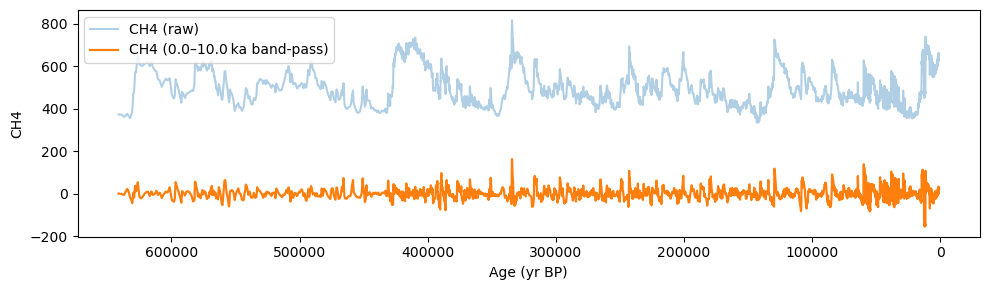

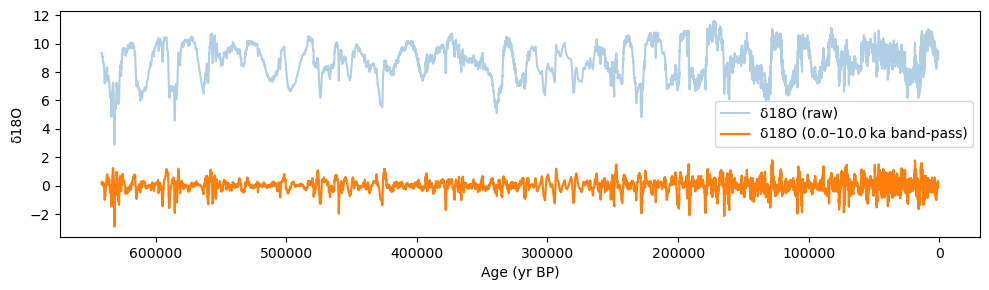

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)


# 0) Load raw data
df_ch4 = pd.read_excel('other_data/CH4_AICC2023.xlsx', sheet_name='Sheet1')
file_path = r"D:\VScode\bipolar_seesaw_CCM\other_data\monsoon.xlsx"
df_d18O = pd.read_excel(file_path)
df_d18O['age'] *= 1000  # to yrs BP
df_d18O['d18O'] = df_d18O['d18O'].values*-1
# renmae column d18O to 'd18O*-1'
df_d18O.rename(columns={'d18O': '-d18O'}, inplace=True)

dt=10
# 1) Build common 10-yr age grid over their overlap
age_min = 1000 # max(df_ch4['age'].min(), df_d18O['age'].min())
age_max = min(df_ch4['age'].max(), df_d18O['age'].max())
ages = np.arange(age_min, age_max + 1, dt)

# 2) Interpolate each onto that grid
ch4 = np.interp(ages, df_ch4['age'], df_ch4['ch4'])
d18O = np.interp(ages, df_d18O['age'], df_d18O['-d18O'])



df_ch4_interp = pd.DataFrame({'age':ages, 'ch4':ch4})
df_d18O_interp = pd.DataFrame({'age':ages, 'd18O':d18O})

# df_filt_ch4, df_filt_d18O = sa.highpass_ch4_d18O(
#     df_ch4_interp,          # DataFrame with columns ['age','ch4']
#     df_d18O_interp,         # columns ['age','d18O']
#     cutoff_period = 10000, # high-pass >10 ka
#     plot = True             # quick comparison plot
# )




df_filt_ch4, df_filt_d18O = sa.bandpass_ch4_d18o(
    df_ch4_interp,
    df_d18O_interp,
    low_period = 100,     # keep variability slower than 300 yr
    high_period = 10_000,  # and faster than 3 ka
    flip_sign = False,
    plot = True
)



In [59]:
df_lr04_interp

age    d18O
0       10000.0 -3.5200
1       10010.0 -3.5208
2       10020.0 -3.5216
3       10030.0 -3.5224
4       10040.0 -3.5232
...         ...     ...
63122  641220.0 -4.8514
63123  641230.0 -4.8501
63124  641240.0 -4.8488
63125  641250.0 -4.8475
63126  641260.0 -4.8462

[63127 rows x 2 columns]

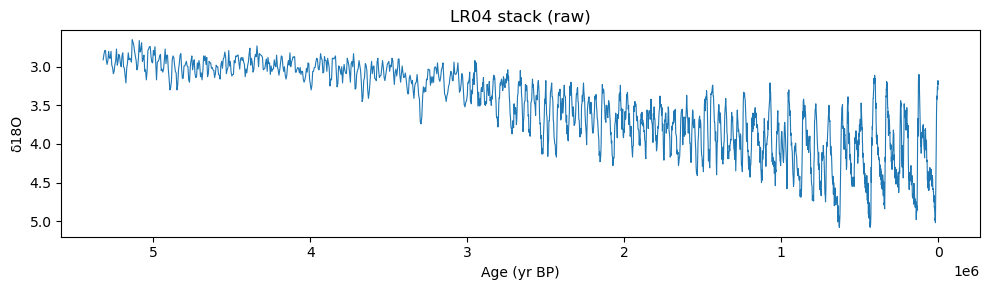

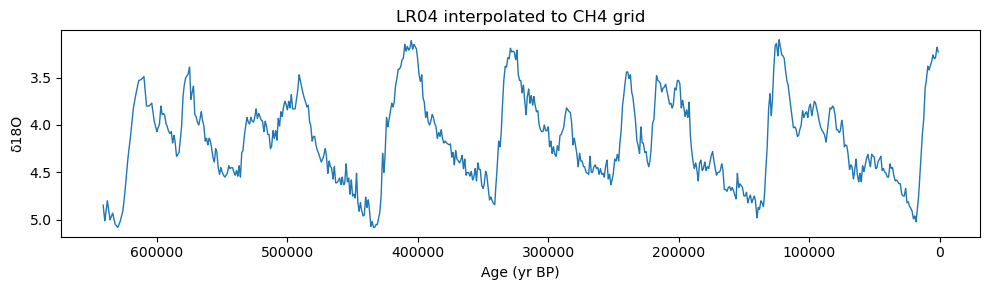

Best σ-multiplier = 0.30   |   F1(cold) = 0.678   |   predicted runs = 36   |   score = 0.670


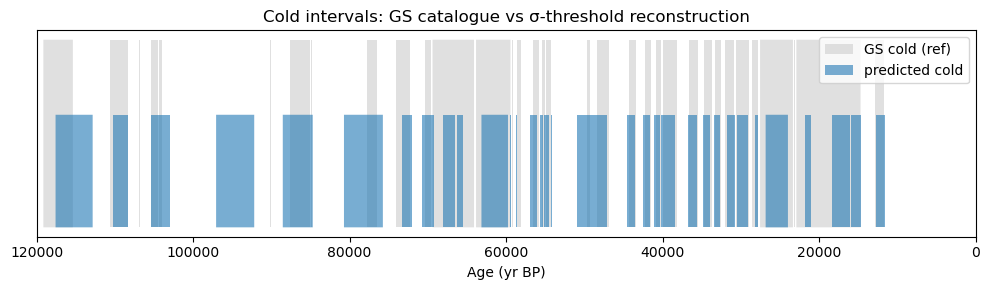

In [67]:
from pyinform import transfer_entropy
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

df_lr04_interp = sa.interpolate_data_lr04(
    df_filt_ch4,      # any DataFrame with an 'age' column
    if_plot=True
)

# crop the data and only keep age>=10,000
df_lr04_interp = df_lr04_interp[df_lr04_interp['age'] >= 10_000].reset_index(drop=True)

df_lr04_interp['d18O']=df_lr04_interp['d18O']*-1

lr04= df_lr04_interp['d18O'].values  # LR04 benthic stack
sq = df_filt_ch4['filt_ch4'].values    # target (residual)

lr04=lr04[::-1] # flip the data so it has correct time direction
sq=sq[::-1] # flip the data so it has correct time direction

ages = df_lr04_interp['age'].values[::-1]  # ages in correct time direction



gs_data = {
    "start": np.array([11703, 14692, 23020, 23340, 27780, 28900, 30840, 32500, 33740, 35480,
                       38220, 40160, 41460, 43340, 46860, 49280, 54220, 55000, 55800, 58040,
                       58280, 59080, 59440, 64100, 69620, 72340, 76440, 84760, 85060, 90040,
                       104040,104520,106750,108280,115370]),
    "end":   np.array([12896, 22900, 23220, 27540, 28600, 30600, 32040, 33360, 34740, 36580,
                       39900, 40800, 42240, 44280, 48340, 49600, 54900, 55400, 56500, 58160,
                       58560, 59300, 63840, 69400, 70380, 74100, 77760, 84960, 87600, 90140,
                       104380,105440,106900,110640,119140])
}
# ------------------------------------------------------------------
# A.  align CH4 to the LR04 age grid  (10 ka – 120 ka)
# ------------------------------------------------------------------
age_min, age_max = 10_000, 120_000
mask_range = (df_filt_ch4['age'] >= age_min) & (df_filt_ch4['age'] <= age_max)

df_ch4_crop = df_filt_ch4.loc[mask_range].reset_index(drop=True)

# ages, lr04, sq all on identical grid and in forward (BP → present) order
ages = df_lr04_interp.loc[
            (df_lr04_interp['age'] >= age_min) &
            (df_lr04_interp['age'] <= age_max),
        'age'
     ].iloc[::-1].values           # reverse to forward time

lr04 = df_lr04_interp.loc[mask_range, 'd18O'].iloc[::-1].values
sq   = df_ch4_crop['filt_ch4'].iloc[::-1].values

# sanity check
assert len(ages) == len(sq) == len(lr04)

# ------------------------------------------------------------------
# B.  build the σ-threshold state series on this aligned grid
# ------------------------------------------------------------------
def build_state(signal, sigma_mult):
    thr = sigma_mult * np.std(signal)
    st  = np.full_like(signal, np.nan, float)
    st[signal <= -thr] = 0
    st[signal >=  thr] = 1
    for i in range(1, len(st)):
        if np.isnan(st[i]):
            st[i] = st[i-1]
    first = np.where(~np.isnan(st))[0][0]
    st[:first] = st[first]
    return st.astype(int)

# GS mask on the same grid
mask_gs = np.zeros_like(ages, dtype=bool)
for s, e in zip(gs_data['start'], gs_data['end']):
    mask_gs |= (ages >= s) & (ages <= e)

# restrict evaluation domain (here identical to full array)
domain = np.full_like(ages, True, dtype=bool)   # already 10–120 ka

# ------------------------------------------------------------------
# C.  σ grid-search as before (now lengths match)
# ------------------------------------------------------------------
sigmas   = np.arange(0.1, 3.05, 0.1)
# best_f1  = -np.inf
# best_mult = None
# best_state = None

def f1_cold(pred_mask, true_mask):
    TP = np.sum(pred_mask & true_mask)
    FP = np.sum(pred_mask & ~true_mask)
    FN = np.sum(~pred_mask & true_mask)
    if TP+FP == 0 or TP+FN == 0: return 0.0
    prec = TP / (TP+FP)
    rec  = TP / (TP+FN)
    return 2*prec*rec / (prec+rec)

# for m in sigmas:
#     st = build_state(sq, m)
#     mask_pred = (st == 0)
#     f1 = f1_cold(mask_pred[domain], mask_gs[domain])
#     if f1 > best_f1:
#         best_f1, best_mult, best_state = f1, m, st

# print(f'Best σ-multiplier = {best_mult:.2f},   F1(cold) = {best_f1:.3f}')


# helper: count distinct 0-runs in a boolean mask
def n_runs(mask):
    # mask must be 1-D boolean array
    edges = np.diff(np.r_[False, mask, False].astype(int))
    return np.sum(edges == 1)

n_gs_runs = len(gs_data['start'])     # 35 stadials
alpha     = 0.25                      # penalty weight  (tune 0–1)

best_score = -np.inf
best_mult  = None
best_state = None

for m in sigmas:
    st = build_state(sq, m)
    cold_pred = (st == 0)

    # F1 on the evaluation domain
    f1 = f1_cold(cold_pred[domain], mask_gs[domain])

    # parsimony penalty
    n_pred_runs = n_runs(cold_pred[domain])
    penalty = alpha * abs(n_pred_runs - n_gs_runs) / n_gs_runs

    score = f1 - penalty

    if score > best_score:
        best_score, best_mult, best_state = score, m, st
        best_f1      = f1
        best_n_pred  = n_pred_runs

print(f'Best σ-multiplier = {best_mult:.2f}'
      f'   |   F1(cold) = {best_f1:.3f}'
      f'   |   predicted runs = {best_n_pred}'
      f'   |   score = {best_score:.3f}')


state = best_state


# ---------------------------------------------------------------
# 2)  visual check of reconstruction vs GS catalogue
# ---------------------------------------------------------------
plt.figure(figsize=(10,3))
plt.fill_between(ages, 0, 1, where=mask_gs, facecolor='lightgrey',
                 step='pre', alpha=.7, label='GS cold (ref)')
plt.fill_between(ages, 0, .6, where=(state==0), facecolor='C0',
                 step='pre', alpha=.6, label='predicted cold')
# plt.plot(ages, 0.4 + 0.05*lr04/np.nanmax(np.abs(lr04)),
#          color='k', lw=0.8, label='LR04 (scaled)')
# plt.gca().invert_xaxis()
# set x lim
plt.xlim(120000, 0)
plt.yticks([])
plt.xlabel('Age (yr BP)')
plt.legend(loc='upper right')
plt.title('Cold intervals: GS catalogue vs σ-threshold reconstruction')
plt.tight_layout(); plt.show()



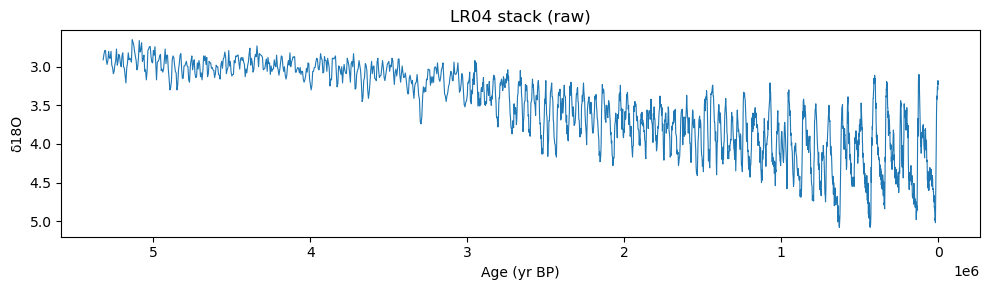

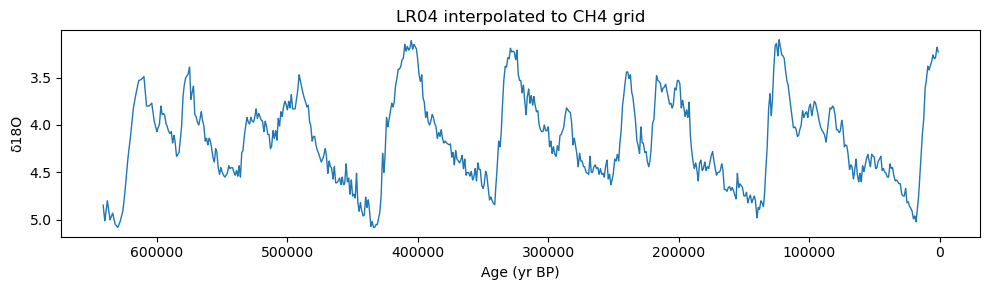

Text(0.5, 0, 'd18O')

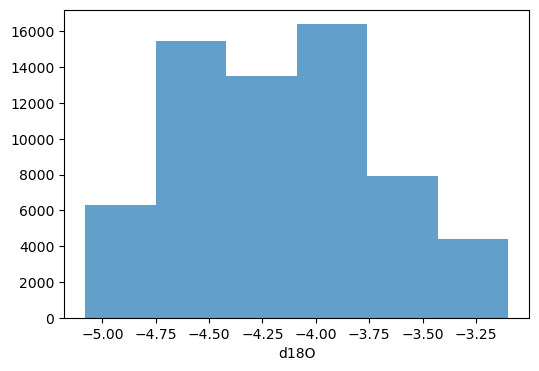

In [77]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

df_lr04_interp = sa.interpolate_data_lr04(
    df_filt_ch4,      # any DataFrame with an 'age' column
    if_plot=True
)


df_lr04_interp['d18O']=df_lr04_interp['d18O']*-1


# plot histogram of d18O
plt.figure(figsize=(6, 4))
plt.hist(df_lr04_interp['d18O'], bins=6, color='C0', alpha=0.7)
plt.xlabel('d18O')

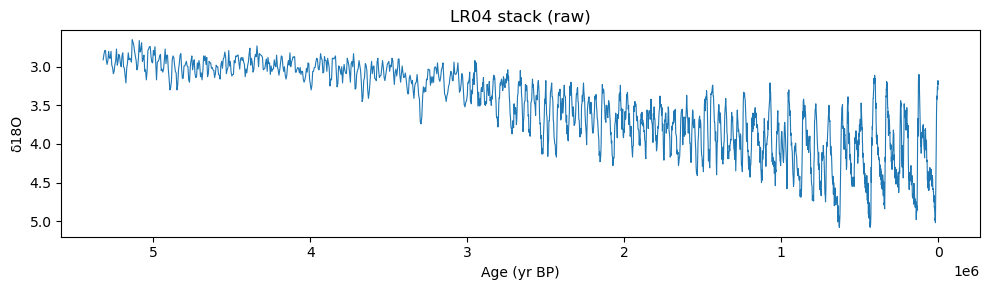

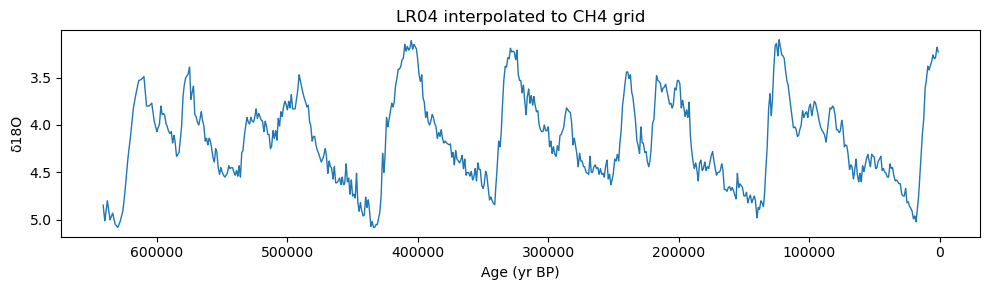

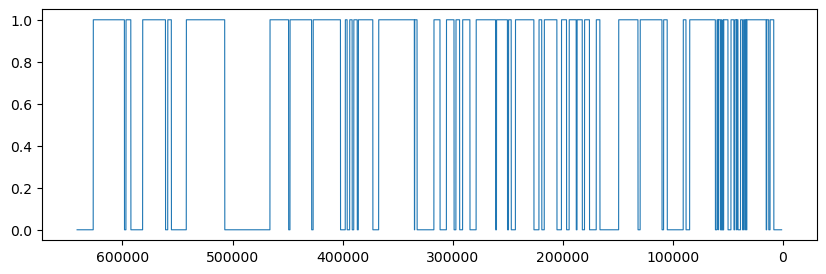

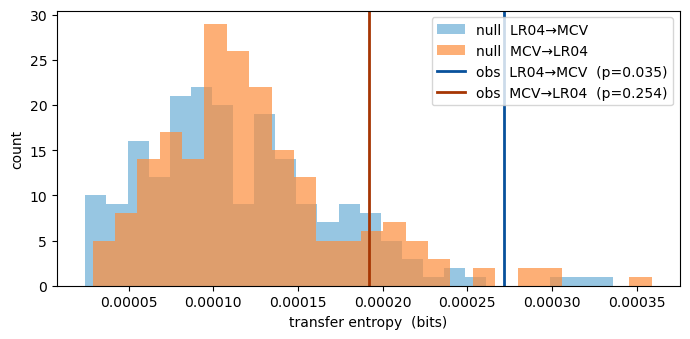

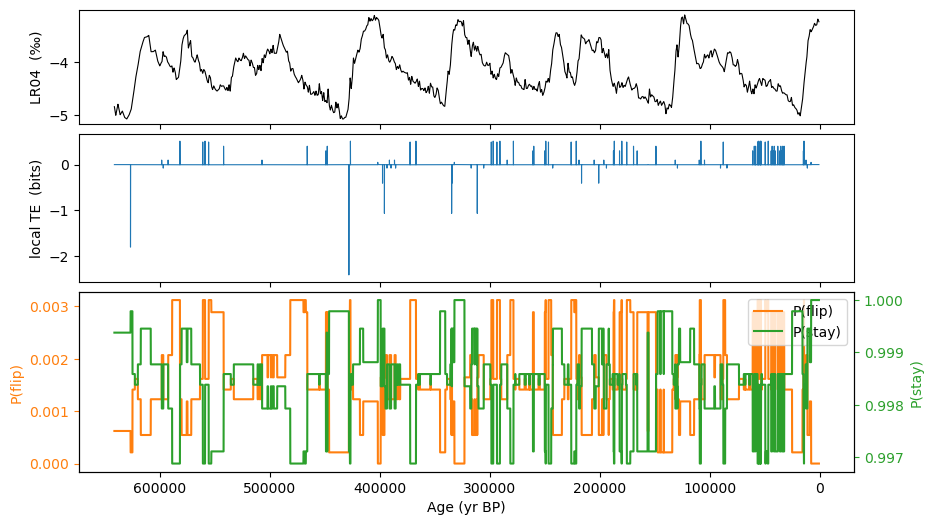

In [75]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

df_lr04_interp = sa.interpolate_data_lr04(
    df_filt_ch4,      # any DataFrame with an 'age' column
    if_plot=True
)


df_lr04_interp['d18O']=df_lr04_interp['d18O']*-1

lr04= df_lr04_interp['d18O'].values  # LR04 benthic stack
sq = df_filt_ch4['filt_ch4'].values    # target (residual)

lr04=lr04[::-1] # flip the data so it has correct time direction
sq=sq[::-1] # flip the data so it has correct time direction





import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyinform import transfer_entropy




sigma      = np.std(sq)                  # 1-σ threshold
state_raw  = np.full_like(sq, fill_value=np.nan, dtype=float)

state_raw[sq <= -1.5*sigma] = 0              # cold  (0)
state_raw[sq >=  1.5*sigma] = 1              # warm  (1)

# hold previous state through the “neutral” belt  (run-length filter)
state = state_raw.copy()
for i in range(1, len(state)):
    if np.isnan(state[i]):
        state[i] = state[i-1]
# still NaN at t=0?  set to the first non-NaN afterwards
first_valid = np.where(~np.isnan(state))[0][0]
state[:first_valid] = state[first_valid]

state = state.astype(int)                # now 0/1 sequence

# plot state
plt.figure(figsize=(10, 3))
plt.plot(df_filt_ch4['age'].values[::-1], state, lw=0.8)
# reverse x
plt.gca().invert_xaxis()

# ------------------------------------------------------------------
# 2.  LR04 → 6 equal-width bins
# ------------------------------------------------------------------
nbins_pre = 6
bins_pre  = np.histogram_bin_edges(lr04, bins=nbins_pre)
x_disc    = np.clip(np.digitize(lr04, bins_pre) - 1, 0, nbins_pre-1)




# ------------------------------------------------------------------
#  A.  global TE in both directions
# ------------------------------------------------------------------
te_xy = transfer_entropy(x_disc[:-1], state[1:], k=1)  # LR04 -> MCV
te_yx = transfer_entropy(state[:-1],  x_disc[1:], k=1) # MCV  -> LR04

# ------------------------------------------------------------------
#  B.  permutation surrogates
# ------------------------------------------------------------------
n_surr = 200
null_xy = np.empty(n_surr)
null_yx = np.empty(n_surr)
rng = np.random.default_rng(0)

for s in range(n_surr):
    xs = rng.permutation(x_disc)
    ys = rng.permutation(state)
    null_xy[s] = transfer_entropy(xs[:-1], state[1:], k=1)
    null_yx[s] = transfer_entropy(ys[:-1], x_disc[1:], k=1)

# two-tailed p-values
cnt_hi_xy = np.sum(null_xy >= te_xy)
cnt_lo_xy = np.sum(null_xy <= te_xy)
p_xy = (2 * min(cnt_hi_xy, cnt_lo_xy) + 1) / (n_surr + 1)

cnt_hi_yx = np.sum(null_yx >= te_yx)
cnt_lo_yx = np.sum(null_yx <= te_yx)
p_yx = (2 * min(cnt_hi_yx, cnt_lo_yx) + 1) / (n_surr + 1)

# ------------------------------------------------------------------
#  C.  plot null distributions + observed TE
# ------------------------------------------------------------------
plt.figure(figsize=(7,3.5))
plt.hist(null_xy, bins=25, color='#6baed6', alpha=.7, label='null  LR04→MCV')
plt.hist(null_yx, bins=25, color='#fd8d3c', alpha=.7, label='null  MCV→LR04')

plt.axvline(te_xy, color='#08519c', lw=2,
            label=f'obs  LR04→MCV  (p={p_xy:.3f})')
plt.axvline(te_yx, color='#a63603', lw=2,
            label=f'obs  MCV→LR04  (p={p_yx:.3f})')

plt.xlabel('transfer entropy  (bits)')
plt.ylabel('count')
plt.legend(frameon=True); plt.tight_layout(); plt.show()


local_te  = transfer_entropy(x_disc, state, k=1, local=True).flatten()
local_te  = local_te[1:]   

x_prev = x_disc[:-1]
y_prev = state[:-1]
y_next = state[1:]

counts = np.zeros((nbins_pre, 2, 2), dtype=int)   # (pre , sq_prev , sq_next)
for xi, yi, zi in zip(x_prev, y_prev, y_next):
    counts[xi, yi, zi] += 1

totals     = counts.sum(axis=2, keepdims=True)
with np.errstate(divide='ignore', invalid='ignore'):
    cond_p = counts / totals                      # P(y_next | x_prev , y_prev)

p_flip = np.array([cond_p[x, y, 1-y] for x,y in zip(x_prev, y_prev)])
p_stay = np.array([cond_p[x, y,   y] for x,y in zip(x_prev, y_prev)])



ages=df_filt_ch4['age'].values[::-1]
# ---------------- align lengths  -----------------
N = min(len(local_te), len(p_flip), len(p_stay), len(ages)-1)
local_te = local_te[:N]
p_flip   = p_flip[:N]
p_stay   = p_stay[:N]
t_plot   = ages[1:1+N]


# ------------------------------------------------------------------
#  D.  LR04, local TE, P(flip)/P(stay) stacked
# ------------------------------------------------------------------
fig = plt.figure(figsize=(10,6))
gs  = fig.add_gridspec(3, 1, height_ratios=[0.7, 0.9, 1.1], hspace=0.07)

# panel A – LR04 (sign-flipped)
axA = fig.add_subplot(gs[0])
axA.plot(ages, lr04, color='k', lw=0.8)
axA.set_ylabel('LR04  (‰)')
axA.invert_xaxis()
axA.tick_params(axis='x', labelbottom=False)

# panel B – local TE
axB = fig.add_subplot(gs[1], sharex=axA)
axB.plot(t_plot, local_te, lw=0.8, color='C0')
axB.set_ylabel('local TE  (bits)')
axB.tick_params(axis='x', labelbottom=False)

# panel C – P(flip) & P(stay)
axC  = fig.add_subplot(gs[2], sharex=axA)
lnF, = axC.plot(t_plot, p_flip, color='C1', label='P(flip)')
axC.set_ylabel('P(flip)', color='C1')
axC.tick_params(axis='y', colors='C1')
axD = axC.twinx()
lnS, = axD.plot(t_plot, p_stay, color='C2', label='P(stay)')
axD.set_ylabel('P(stay)', color='C2')
axD.tick_params(axis='y', colors='C2')
axC.set_xlabel('Age (yr BP)')
axC.legend([lnF, lnS], ['P(flip)', 'P(stay)'], loc='upper right')

plt.show()



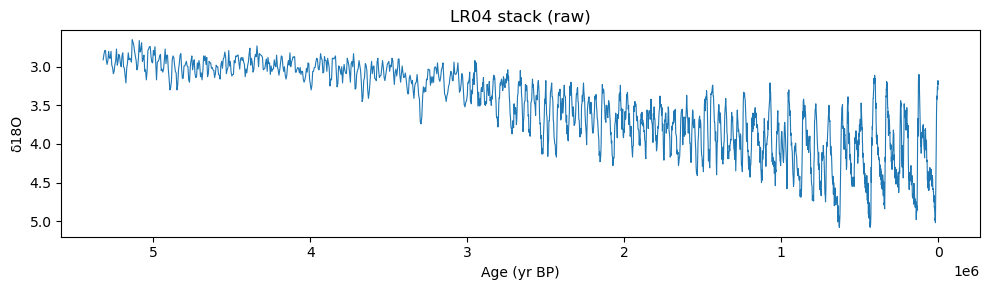

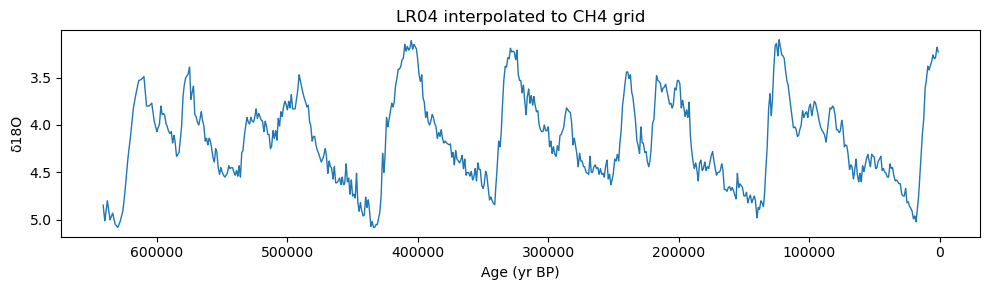

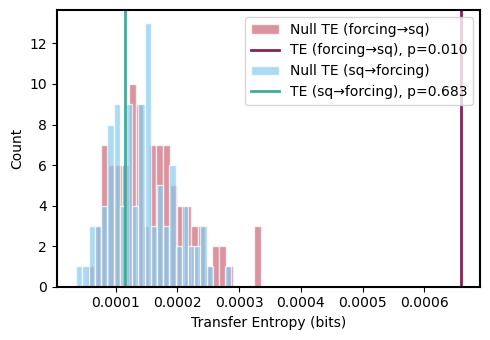

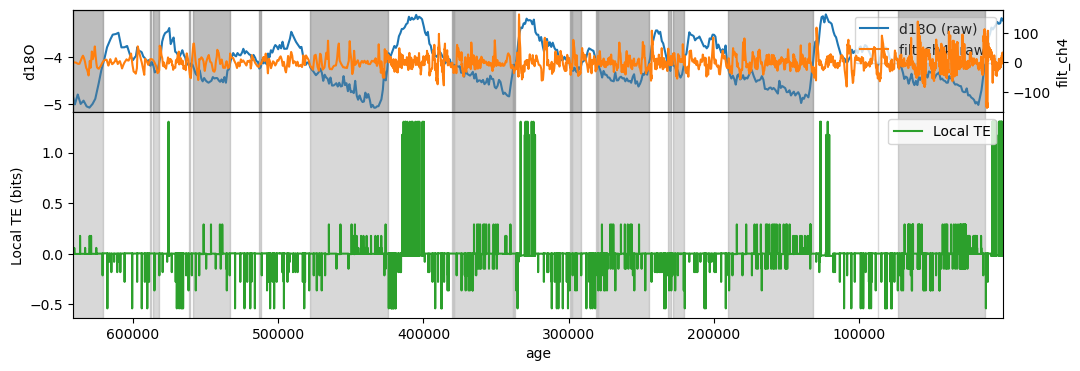

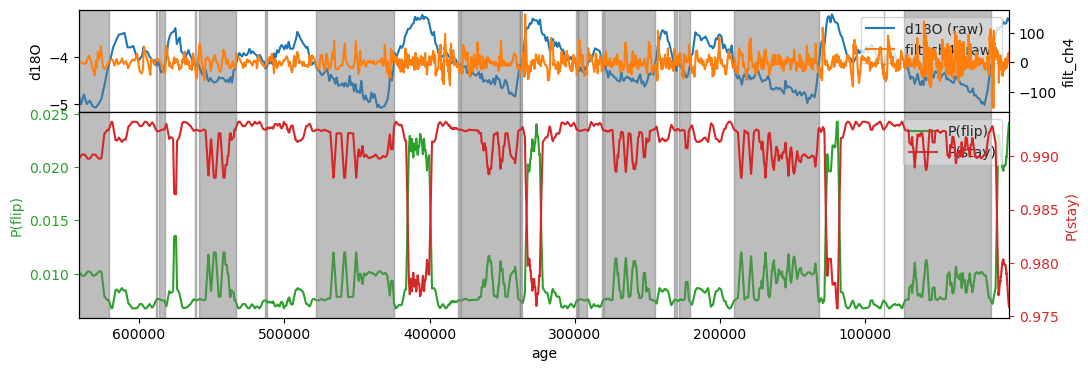

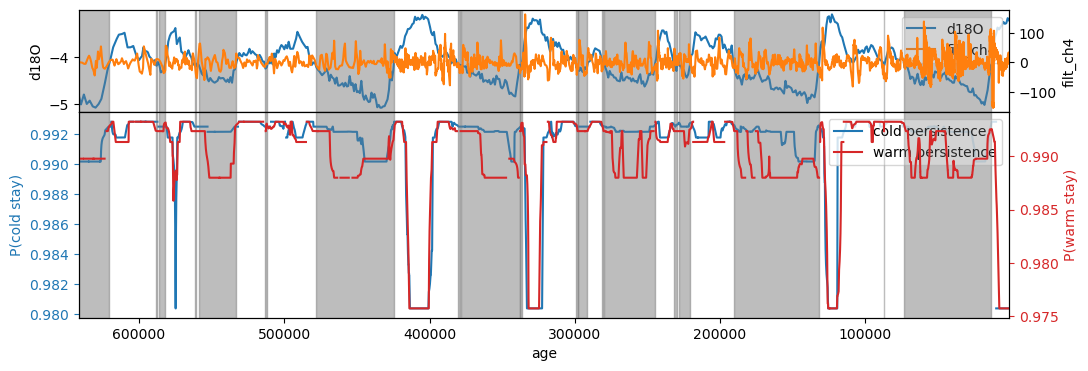

In [79]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

df_lr04_interp = sa.interpolate_data_lr04(
    df_filt_ch4,      # any DataFrame with an 'age' column
    if_plot=True
)


df_lr04_interp['d18O']=df_lr04_interp['d18O']*-1

lr04= df_lr04_interp['d18O'].values  # LR04 benthic stack
sq = df_filt_ch4['filt_ch4'].values    # target (residual)


result,fig=sa.transfer_entropy_surrogate_test(lr04,sq, forcing_bins=6, sq_bins=2, n_surr=100)



LTE = sa.local_TE(df_lr04_interp.copy(), df_filt_ch4.copy(),
                   forcing_column='d18O',
                   target_column='filt_ch4',
                   time_column='age',
                   nbins_pre=6,
                   nbins_target=2)



Lp = sa.local_prob(df_lr04_interp.copy(), df_filt_ch4.copy(),
                   forcing_column='d18O',
                   target_column='filt_ch4',
                   time_column='age',
                   nbins_pre=6,
                   smooth_win=300)


Lp = sa.local_stay_split(df_lr04_interp.copy(), df_filt_ch4.copy(),
                   forcing_column='d18O',
                   target_column='filt_ch4',
                   time_column='age',
                   nbins_pre=6,
                   smooth_win=300)

In [19]:
print(df_lr04_interp['d18O'].max(), 'should be interglacial ‖ warm')
print(df_lr04_interp['d18O'].min(), 'should be glacial ‖ cold')


-3.1 should be interglacial ‖ warm
-5.08 should be glacial ‖ cold


age    lr04
0    97400  4.8397
1    97300  4.8527
2    97200  4.8657
3    97100  4.8787
4    97000  4.8926
..     ...     ...
970    400  3.8472
971    300  3.8352
972    200  3.8232
973    100  3.8112
974      0  3.8010

[975 rows x 2 columns]

In [418]:
import numpy as np
import pandas as pd

def threshold_to_noise(df, 
                       col='d18O', 
                       lower_pct=5, 
                       upper_pct=95, 
                       noise_mean=0,
                       sigma=0.5):
    """
    Replace values of df[col] below the lower_pct‐percentile or 
    above the upper_pct‐percentile with white noise.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame with at least the column `col`.
    col : str
        Name of the column to threshold.
    lower_pct : float
        Lower percentile cutoff (0–100).
    upper_pct : float
        Upper percentile cutoff (0–100).
    noise_mean : float
        Mean of the white‐noise distribution (default = 0).
    
    Returns
    -------
    df_out : pandas.DataFrame
        A copy of df where outliers in `col` are replaced by noise.
    lower_bound, upper_bound : float, float
        The thresholds actually used.
    """
    df_out = df.copy()
    series = df_out[col]
    
    # compute percentile thresholds
    lower_bound = np.percentile(series, lower_pct)
    upper_bound = np.percentile(series, upper_pct)
    
    # compute noise parameters
    # sigma = series.std()
    
    # mask of outliers
    mask = (series < lower_bound) | (series > upper_bound)
    n_outliers = mask.sum()
    
    # generate white noise for those positions
    noise = np.random.normal(loc=noise_mean, scale=sigma, size=n_outliers)
    
    # replace
    df_out.loc[mask, col] = noise
    
    print(f"Replaced {n_outliers} values <{lower_bound:.3f} or >{upper_bound:.3f} with N({noise_mean},{sigma:.3f}²) noise")
    return df_out, lower_bound, upper_bound

Replaced 25612 values <-17.135 or >15.442 with N(0,0.500²) noise
Replaced 25612 values <-0.276 or >0.310 with N(0,0.050²) noise


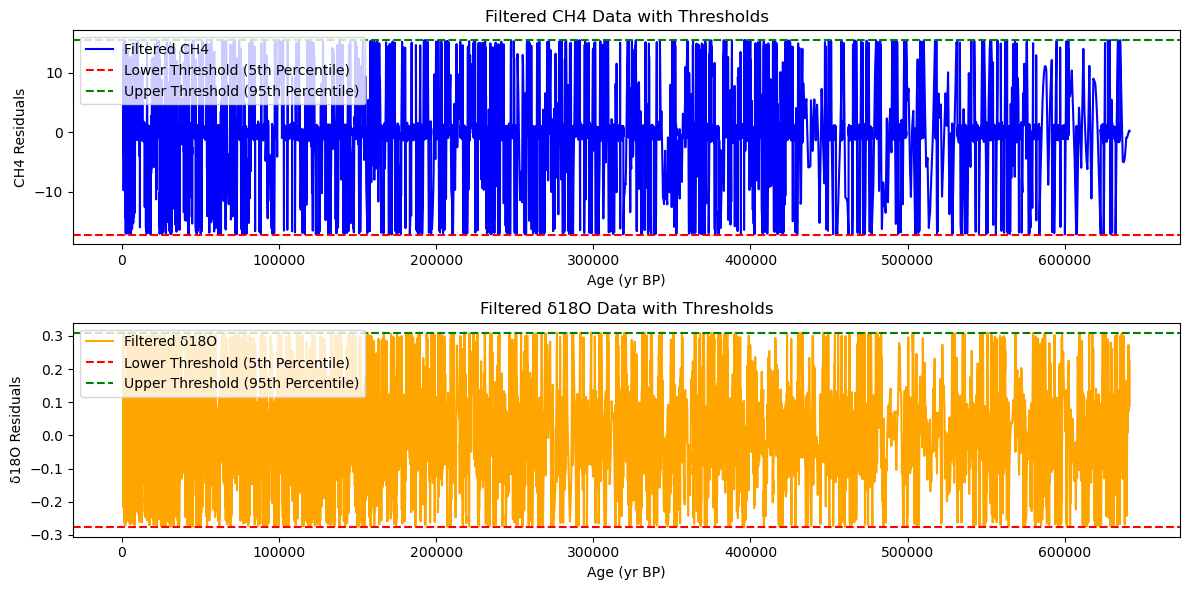

In [429]:


df_filt_ch4, lower_ch4, upper_ch4 = threshold_to_noise(df_filt_ch4.copy(),
                                                        col='filt_ch4',
                                                        lower_pct=20,
                                                        upper_pct=80,
                                                        noise_mean=0,
                                                        sigma=0.5)
df_filt_d18O, lower_d18O, upper_d18O = threshold_to_noise(df_filt_d18O.copy(),
                                                            col='filt_d18O',
                                                            lower_pct=20,
                                                            upper_pct=80,
                                                            noise_mean=0,
                                                            sigma=0.05)

# plot the filtered and thresholded data
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(df_filt_ch4['age'], df_filt_ch4['filt_ch4'], label='Filtered CH4', color='blue')
plt.axhline(lower_ch4, color='red', linestyle='--', label='Lower Threshold (5th Percentile)')
plt.axhline(upper_ch4, color='green', linestyle='--', label='Upper Threshold (95th Percentile)')
plt.title('Filtered CH4 Data with Thresholds')
plt.xlabel('Age (yr BP)')
plt.ylabel('CH4 Residuals')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(df_filt_d18O['age'], df_filt_d18O['filt_d18O'], label='Filtered δ18O', color='orange')
plt.axhline(lower_d18O, color='red', linestyle='--', label='Lower Threshold (5th Percentile)')
plt.axhline(upper_d18O, color='green', linestyle='--', label='Upper Threshold (95th Percentile)')
plt.title('Filtered δ18O Data with Thresholds')
plt.xlabel('Age (yr BP)')
plt.ylabel('δ18O Residuals')
plt.legend()
plt.tight_layout()
plt.show()

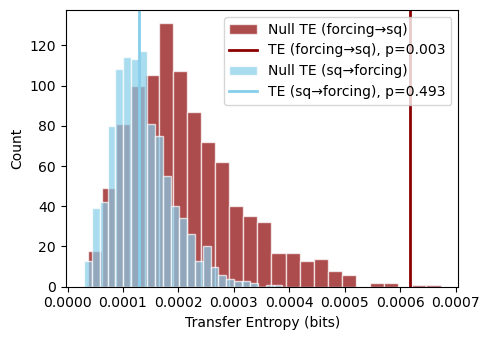

True


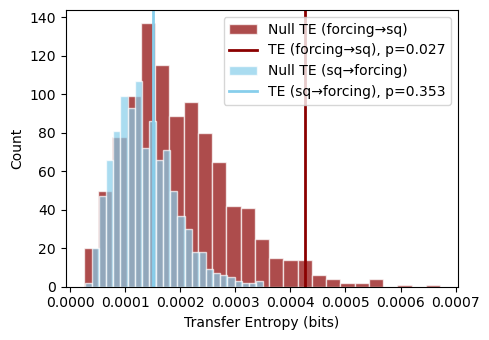

True


In [433]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)





df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(df_filt_ch4.copy(), 10, if_plot=False)


pre = df_pre_i['pre'].values      # source (precession)
obl = df_obl_i['obl'].values    # target (obliquity)
sq = df_sq_i['filt_ch4'].values    # target (residual)


result,fig=sa.transfer_entropy_surrogate_test_v2(pre,sq, forcing_bins=6, sq_bins=2, n_surr=1000)

# fig.savefig('TE_NGRIP.pdf',format='pdf',bbox_inches='tight')
print(result)


result,fig=sa.transfer_entropy_surrogate_test_v2(obl,sq, forcing_bins=6, sq_bins=2, n_surr=1000)
print(result)


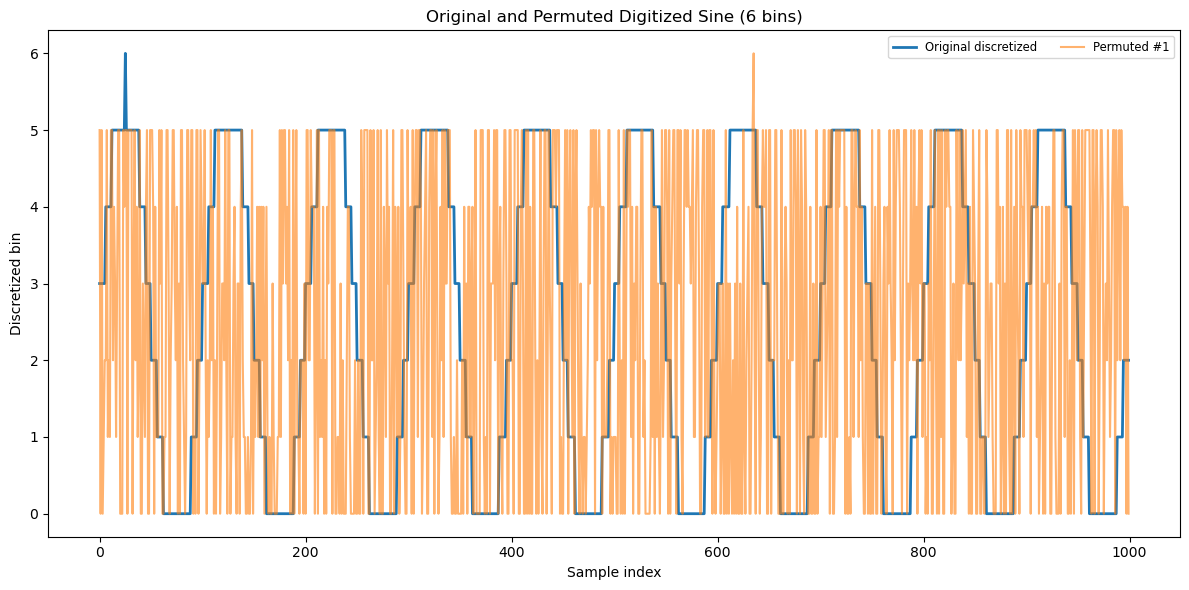

In [439]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a sine wave with 10 cycles
cycles = 10
N = 1000
t = np.linspace(0, cycles * 2 * np.pi, N)
pre = np.sin(t)

# Discretize into 6 bins
edges = np.histogram_bin_edges(pre, bins=6)
pre_disc = np.digitize(pre, edges) - 1

# Generate 10 permuted surrogates
surrogates = [np.random.permutation(pre_disc) for _ in range(10)]

# Plot original and surrogates
plt.figure(figsize=(12, 6))
plt.plot(pre_disc, label='Original discretized', linewidth=2)
for i, s in enumerate(surrogates, 1):
    plt.plot(s, alpha=0.6, label=f'Permuted #{i}')
    if i == 1:
        break
plt.xlabel('Sample index')
plt.ylabel('Discretized bin')
plt.title('Original and Permuted Digitized Sine (6 bins)')
plt.legend(ncol=2, fontsize='small')
plt.tight_layout()
plt.show()


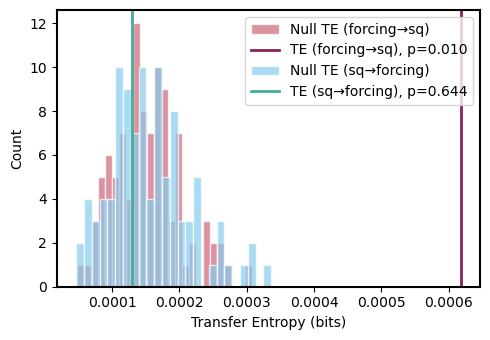

True


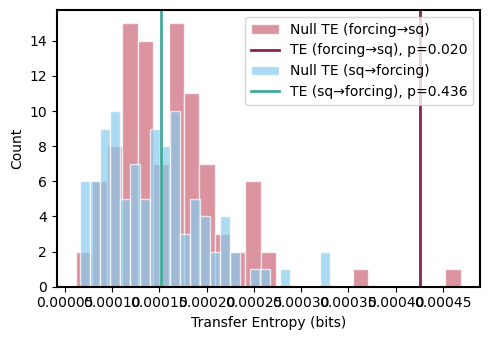

True


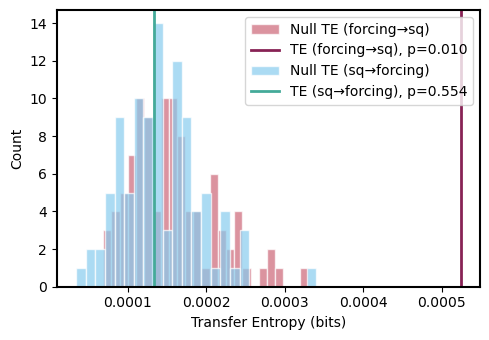

True


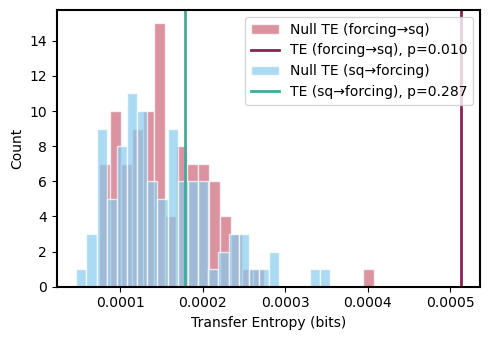

True


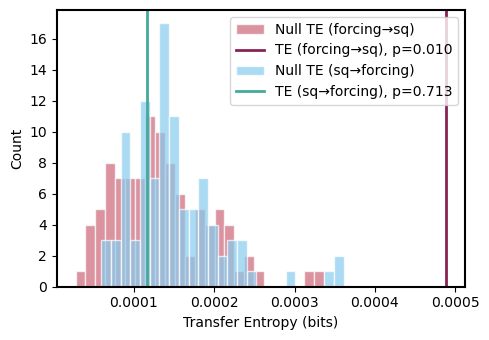

True


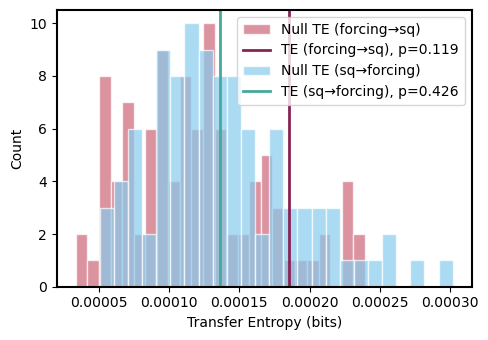

False


In [434]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)





df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(df_filt_ch4.copy(), 10, if_plot=False)


pre = df_pre_i['pre'].values      # source (precession)
obl = df_obl_i['obl'].values    # target (obliquity)
sq = df_sq_i['filt_ch4'].values    # target (residual)


# sq_method='hist',  # options: 'hist', 'quantile', 'kmeans'

result,fig=sa.transfer_entropy_surrogate_test(pre,sq, forcing_bins=6, sq_bins=2, sq_method='hist')
print(result)
result,fig=sa.transfer_entropy_surrogate_test(obl,sq, forcing_bins=6, sq_bins=2, sq_method='hist')
print(result)



result,fig=sa.transfer_entropy_surrogate_test(pre,sq, forcing_bins=6, sq_bins=2, sq_method='quantile')
print(result)
result,fig=sa.transfer_entropy_surrogate_test(obl,sq, forcing_bins=6, sq_bins=2, sq_method='quantile')
print(result)


result,fig=sa.transfer_entropy_surrogate_test(pre,sq, forcing_bins=6, sq_bins=2, sq_method='kmeans')
print(result)
result,fig=sa.transfer_entropy_surrogate_test(obl,sq, forcing_bins=6, sq_bins=2, sq_method='kmeans')
print(result)

In [ ]:
import numpy as np
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)


df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(df_filt_ch4.copy(), 10, if_plot=False)


pre = df_pre_i['pre'].values      # source (precession)
obl = df_obl_i['obl'].values    # target (obliquity)
sq = df_sq_i['filt_ch4'].values    # target (residual)

def convergence_test(x, y, thinning_fractions, **te_kwargs):
    results = []
    N = len(x)
    for frac in thinning_fractions:
        m = int(N * frac)
        idx = np.sort(np.random.choice(N, m, replace=False))
        sig, te = sa.transfer_entropy_surrogate_test(
            x[idx], y[idx], if_plot=False, **te_kwargs
        )
        results.append((frac, sig))
    return results

fractions = np.linspace(0.2,1.0,5)   # 20%, 40%, …100%
print(convergence_test(pre, sq, fractions,
                       forcing_bins=6, sq_bins=2, use_quantile=True))

print(convergence_test(obl, sq, fractions,
                       forcing_bins=6, sq_bins=2, use_quantile=True))



[(0.2, False), (0.4, True), (0.6000000000000001, True), (0.8, True), (1.0, True)]
[(0.2, False), (0.4, True), (0.6000000000000001, True), (0.8, True), (1.0, True)]


In [377]:
import numpy as np
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)


df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(df_filt_ch4.copy(), 10, if_plot=False)


pre = df_pre_i['pre'].values      # source (precession)
obl = df_obl_i['obl'].values    # target (obliquity)
sq = df_sq_i['filt_ch4'].values    # target (residual)

def convergence_test(x, y, thinning_fractions, **te_kwargs):
    results = []
    N = len(x)
    for frac in thinning_fractions:
        m = int(N * frac)
        idx = np.sort(np.random.choice(N, m, replace=False))
        sig, te = sa.transfer_entropy_surrogate_test(
            x[idx], y[idx], if_plot=False, **te_kwargs
        )
        results.append((frac, sig))
    return results

fractions = np.linspace(0.2,1.0,5)   # 20%, 40%, …100%
print(convergence_test(pre, sq, fractions,
                       forcing_bins=6, sq_bins=2, use_quantile=True))

print(convergence_test(obl, sq, fractions,
                       forcing_bins=6, sq_bins=2, use_quantile=True))



[(0.2, False), (0.4, True), (0.6000000000000001, True), (0.8, True), (1.0, True)]
[(0.2, False), (0.4, True), (0.6000000000000001, True), (0.8, True), (1.0, True)]


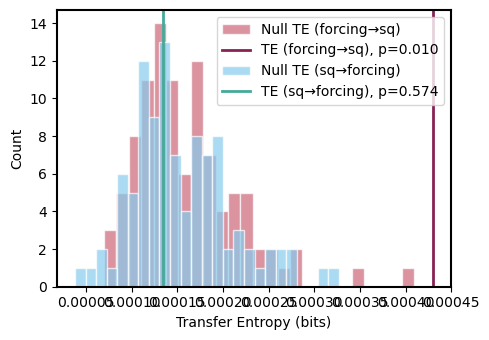

True


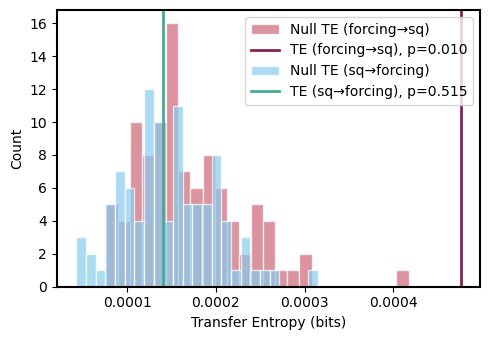

True


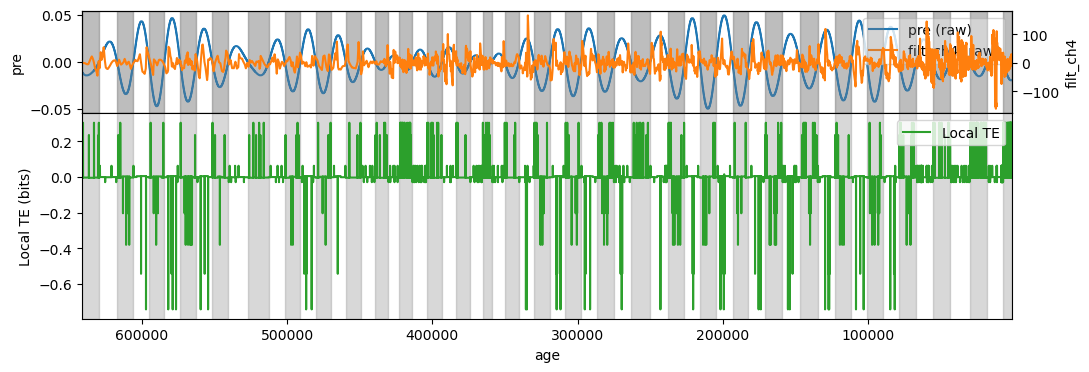

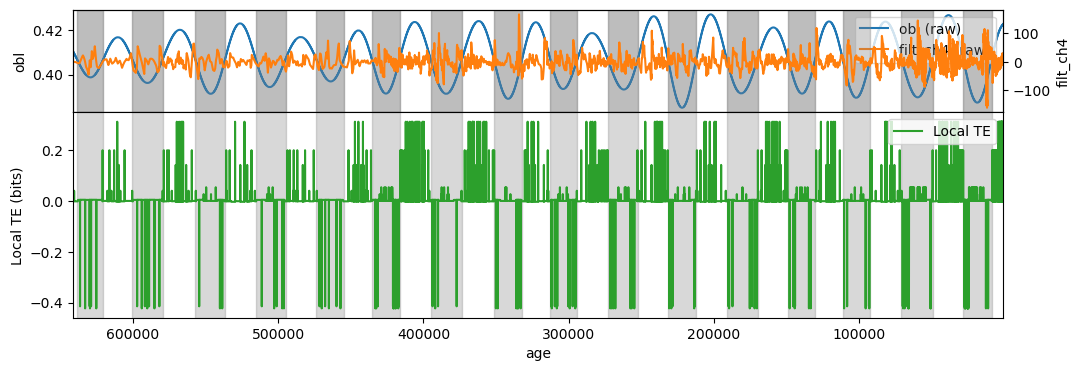

In [2]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)





df_sq_i, df_pre_i, df_obl_i = sa.create_shift_forcing(df_filt_ch4.copy(), 10, if_plot=False)


pre = df_pre_i['pre'].values      # source (precession)
obl = df_obl_i['obl'].values    # target (obliquity)
sq = df_sq_i['filt_ch4'].values    # target (residual)


result,fig=sa.transfer_entropy_surrogate_test(pre,sq, forcing_bins=6, sq_bins=2, n_surr=100)

# fig.savefig('TE_NGRIP.pdf',format='pdf',bbox_inches='tight')
print(result)


result,fig=sa.transfer_entropy_surrogate_test(obl,sq, forcing_bins=6, sq_bins=2, n_surr=100)
print(result)



LTE = sa.local_TE(df_pre_i.copy(), df_sq_i.copy(),
                   forcing_column='pre',
                   target_column='filt_ch4',
                   time_column='age',
                   nbins_pre=4,
                   nbins_target=2)




LTE = sa.local_TE(df_obl_i.copy(), df_sq_i.copy(),
                   forcing_column='obl',
                   target_column='filt_ch4',
                   time_column='age',
                   nbins_pre=4,
                   nbins_target=2)

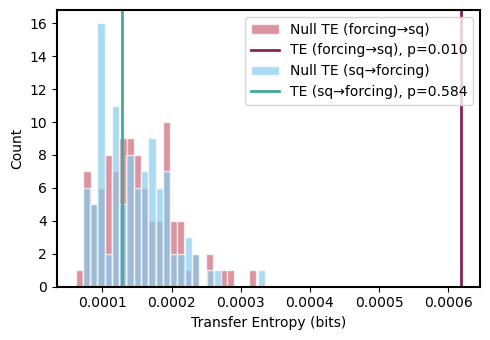

True


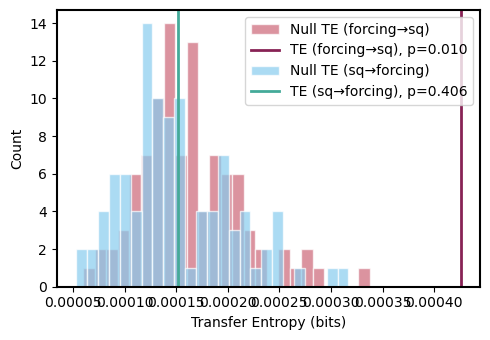

True


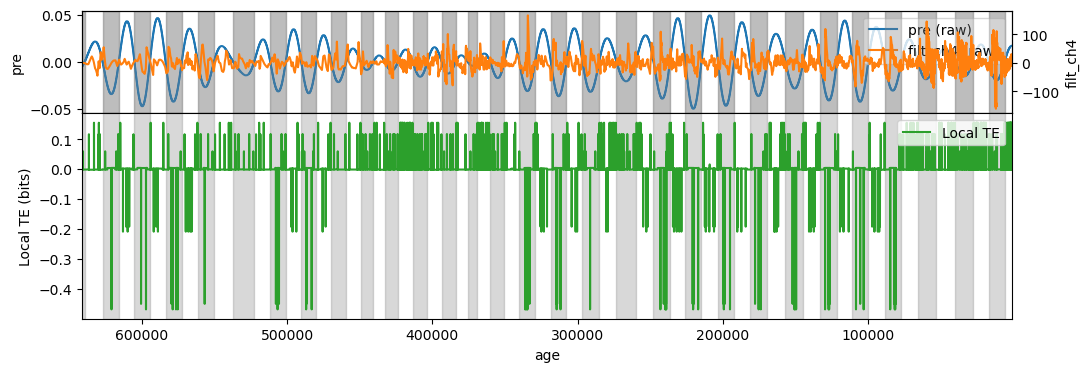

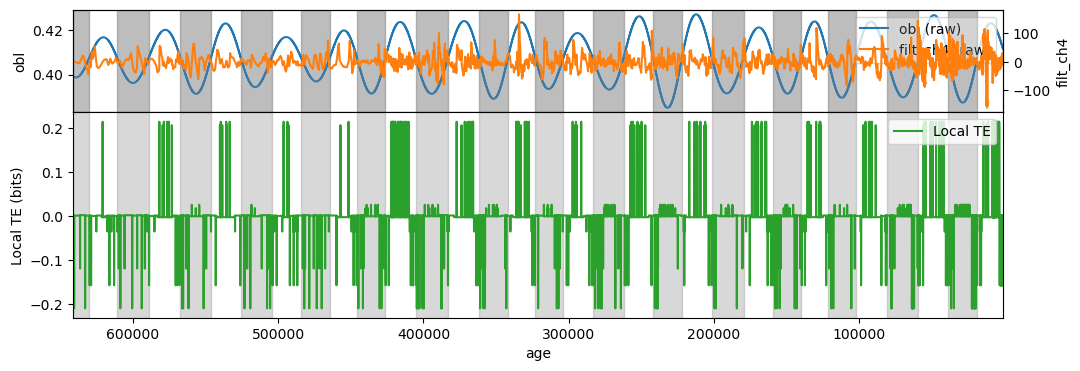

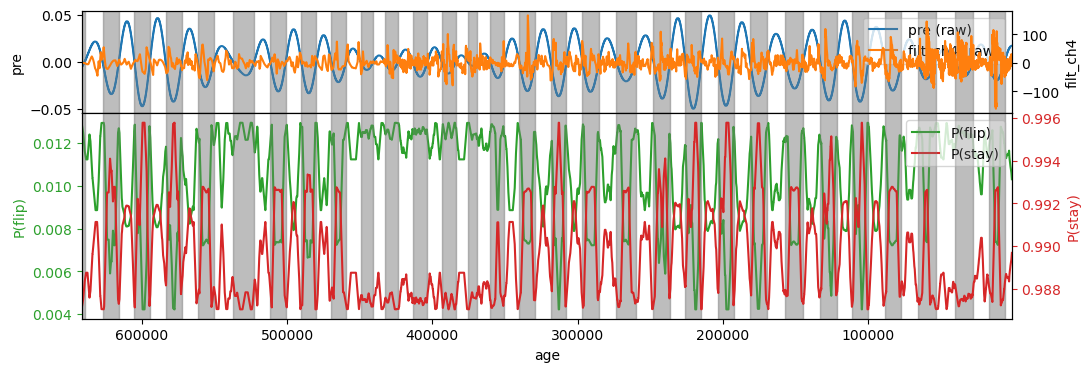

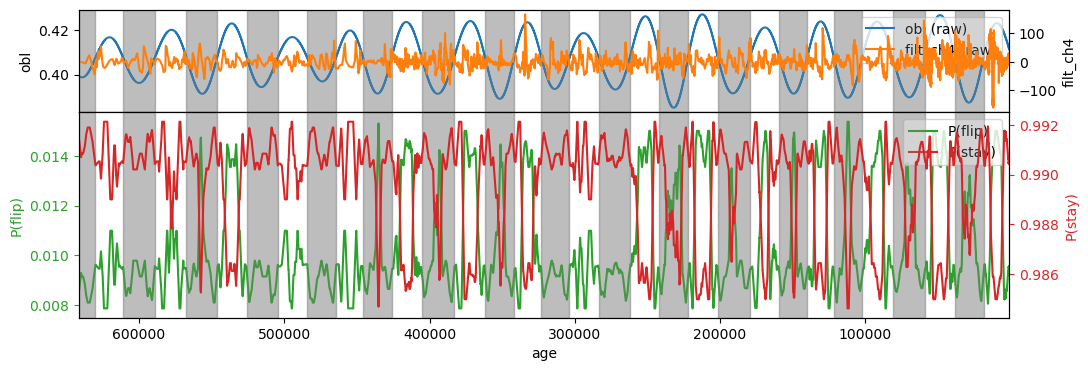

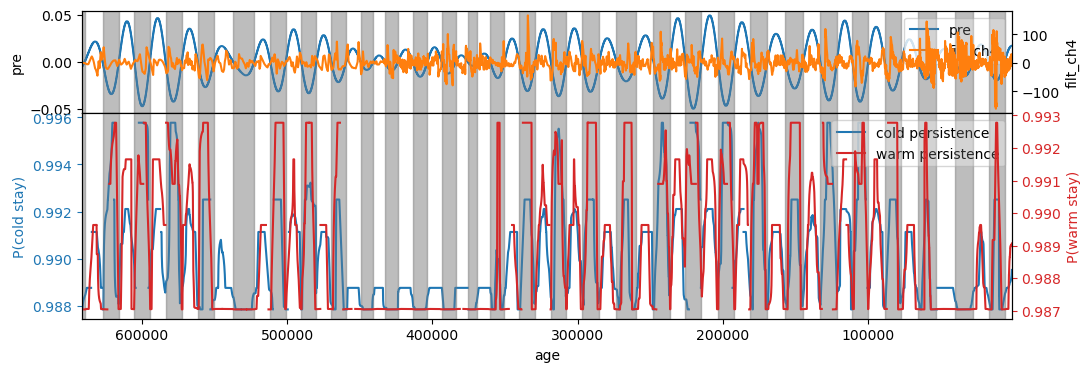

In [4]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)





df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(df_filt_ch4.copy(), 10, if_plot=False)


pre = df_pre_i['pre'].values      # source (precession)
obl = df_obl_i['obl'].values    # target (obliquity)
sq = df_sq_i['filt_ch4'].values    # target (residual)


result,fig=sa.transfer_entropy_surrogate_test(pre,sq, forcing_bins=6, sq_bins=2, n_surr=100)

# fig.savefig('TE_NGRIP.pdf',format='pdf',bbox_inches='tight')
print(result)


result,fig=sa.transfer_entropy_surrogate_test(obl,sq, forcing_bins=6, sq_bins=2, n_surr=100)
print(result)


LTE = sa.local_TE(df_pre_i.copy(), df_sq_i.copy(),
                   forcing_column='pre',
                   target_column='filt_ch4',
                   time_column='age',
                   nbins_pre=4,
                   nbins_target=2)




LTE = sa.local_TE(df_obl_i.copy(), df_sq_i.copy(),
                   forcing_column='obl',
                   target_column='filt_ch4',
                   time_column='age',
                   nbins_pre=4,
                   nbins_target=2)



Lp = sa.local_prob(df_pre_i.copy(), df_sq_i.copy(),
                   forcing_column='pre',
                   target_column='filt_ch4',
                   time_column='age',
                   nbins_pre=6,
                   smooth_win=300)




Lp = sa.local_prob(df_obl_i.copy(), df_sq_i.copy(),
                   forcing_column='obl',
                   target_column='filt_ch4',
                   time_column='age',
                   nbins_pre=6,
                   smooth_win=300)


Lp = sa.local_stay_split(df_pre_i.copy(), df_sq_i.copy(),
                   forcing_column='pre',
                   target_column='filt_ch4',
                   time_column='age',
                   nbins_pre=6,
                   smooth_win=300)

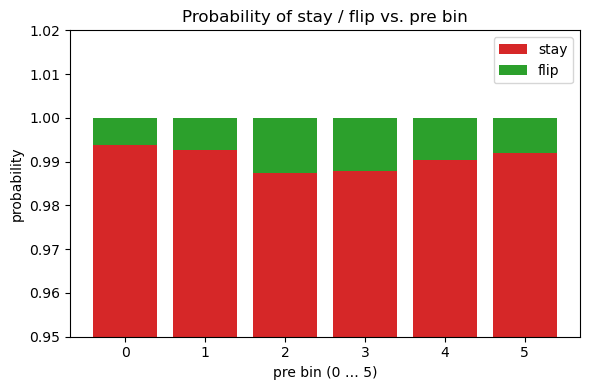

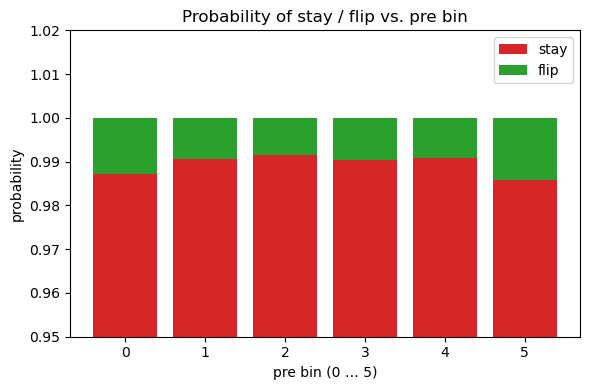

In [43]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

delta = sa.prob_prebins_bar(
    df_pre_i, df_sq_i,
    forcing_column='pre',
    target_column='filt_ch4',
    time_column='age',
    nbins_pre=6
)

delta = sa.prob_prebins_bar(
    df_obl_i, df_sq_i,
    forcing_column='obl',
    target_column='filt_ch4',
    time_column='age',
    nbins_pre=6
)

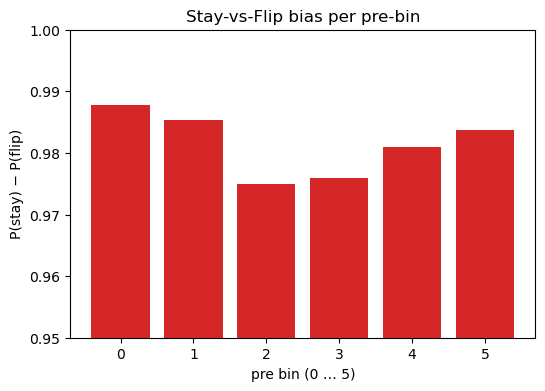

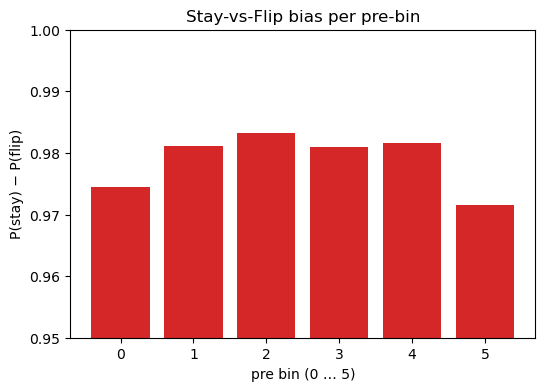

In [4]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

delta = sa.prob_prebins_diffbar(
    df_pre_i, df_sq_i,
    forcing_column='pre',
    target_column='filt_ch4',
    time_column='age',
    nbins_pre=6
)

delta = sa.prob_prebins_diffbar(
    df_obl_i, df_sq_i,
    forcing_column='obl',
    target_column='filt_ch4',
    time_column='age',
    nbins_pre=6
)

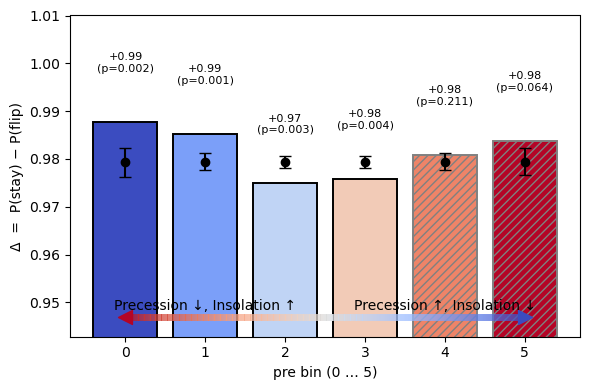

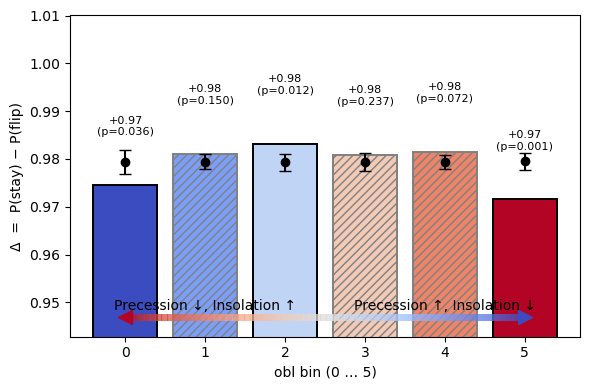

In [44]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)


delta, mu, sigma, p = sa.prob_prebins_diffbar_surr(
        df_pre_i, df_sq_i,
        forcing_column='pre',
        target_column='filt_ch4',
        nbins_pre=6,
        n_surr=1000,
        alpha=0.05,
        random_state=0   # reproducible
)


delta, mu, sigma, p = sa.prob_prebins_diffbar_surr(
        df_obl_i, df_sq_i,
        forcing_column='obl',
        target_column='filt_ch4',
        nbins_pre=6,
        n_surr=1000,
        alpha=0.05,
        random_state=0   # reproducible
)


(64027,) (64027,) (64027,)
      pre=0  pre=1  pre=2  pre=3  pre=4  pre=5
sq=0   2602   5340   8966   8806   5751   2534
sq=1   1648   5260   7795   8344   4825   2156


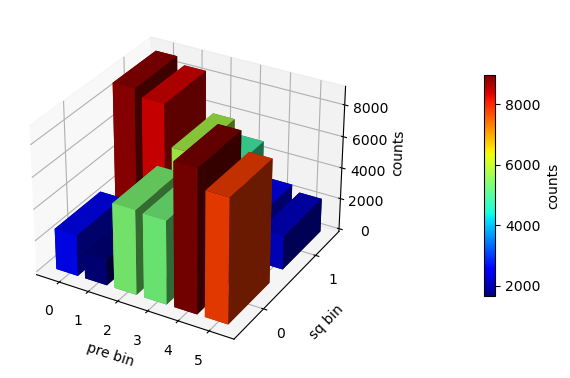

      pre=0  pre=1  pre=2  pre=3  pre=4  pre=5
sq=0   3328   6992   5412   5080   7875   5312
sq=1   2472   6638   5059   4966   6095   4798


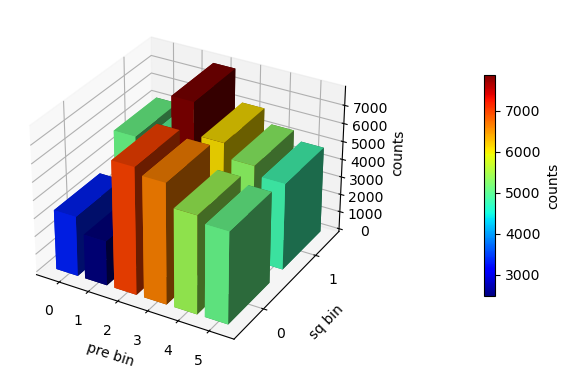

In [37]:
pre = df_pre_i['pre'].values      # source (precession)
obl = df_obl_i['obl'].values    # target (obliquity)
sq = df_sq_i['filt_ch4'].values    # target (residual)

print(sq.shape, pre.shape, obl.shape)

from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

_ = sa.count_sq_pre_contexts_3d(sq, pre, nbins_pre=6)
_ = sa.count_sq_pre_contexts_3d(sq, obl, nbins_pre=6)

In [5]:
pre = df_pre_i['pre'].values      # source (precession)
obl = df_obl_i['obl'].values    # target (obliquity)
sq = df_sq_i['filt_ch4'].values    # target (residual)

print(sq.shape, pre.shape, obl.shape)


import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots



# --- Bin settings ---
bins_sq = 2
bins_pre_obl = 6

# --- Compute 2D histograms (counts) ---
hist_pre_sq, pre_edges, sq_edges = np.histogram2d(pre, sq, bins=[bins_pre_obl, bins_sq])
hist_obl_sq, obl_edges, sq_edges2 = np.histogram2d(obl, sq, bins=[bins_pre_obl, bins_sq])

# --- Compute bin widths and centers ---
pre_centers = (pre_edges[:-1] + pre_edges[1:]) / 2
obl_centers = (obl_edges[:-1] + obl_edges[1:]) / 2
sq_centers  = (sq_edges[:-1]  + sq_edges[1:])  / 2
sq_centers2 = (sq_edges2[:-1] + sq_edges2[1:]) / 2
dx_pre = pre_edges[1] - pre_edges[0]
dx_obl = obl_edges[1] - obl_edges[0]
dy_sq  = sq_edges[1]  - sq_edges[0]

# Function to create a cuboid mesh for each bin
def cuboid_mesh(x0, x1, y0, y1, z0, z1, color):
    # Eight vertices of cuboid
    verts = np.array([
        [x0, y0, z0],
        [x1, y0, z0],
        [x1, y1, z0],
        [x0, y1, z0],
        [x0, y0, z1],
        [x1, y0, z1],
        [x1, y1, z1],
        [x0, y1, z1],
    ])
    # Define 12 triangles (two per face)
    I = [0, 0, 0, 1, 1, 2, 4, 4, 5, 5, 6, 7]
    J = [1, 3, 4, 2, 5, 3, 5, 7, 6, 4, 7, 4]
    K = [2, 2, 5, 5, 6, 6, 7, 6, 7, 7, 3, 0]
    return go.Mesh3d(
        x=verts[:,0], y=verts[:,1], z=verts[:,2],
        i=I, j=J, k=K,
        color=color, opacity=0.6
    )

# --- Build figure with two 3D histogram panels ---
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{'type': 'scene'}, {'type': 'scene'}]],
    subplot_titles=('Histogram: Precession vs Residual', 'Histogram: Obliquity vs Residual')
)

# Add cuboids for pre vs sq
for i, x_c in enumerate(pre_centers):
    for j, y_c in enumerate(sq_centers):
        height = hist_pre_sq[i, j]
        if height > 0:
            fig.add_trace(
                cuboid_mesh(
                    x_c - dx_pre/2, x_c + dx_pre/2,
                    y_c - dy_sq/2, y_c + dy_sq/2,
                    0, height,
                    color='blue'
                ),
                row=1, col=1
            )

# Add cuboids for obl vs sq
for i, x_c in enumerate(obl_centers):
    for j, y_c in enumerate(sq_centers2):
        height = hist_obl_sq[i, j]
        if height > 0:
            fig.add_trace(
                cuboid_mesh(
                    x_c - dx_obl/2, x_c + dx_obl/2,
                    y_c - dy_sq/2, y_c + dy_sq/2,
                    0, height,
                    color='green'
                ),
                row=1, col=2
            )

# Layout tweaks
fig.update_layout(
    title='3D Histogram Bars of Joint Distributions',
    width=1200, height=600,
    scene=dict(xaxis_title='precession', yaxis_title='sq', zaxis_title='Count'),
    scene2=dict(xaxis_title='obliquity', yaxis_title='sq', zaxis_title='Count')
)

fig.show()


(64027,) (64027,) (64027,)


In [300]:
# print the 5%, 25%, 50%, 75%, 95% quantiles of the df_sq_i['filt_ch4'].values
import numpy as np
quantiles = np.percentile(df_sq_i['filt_ch4'].values, [5, 25, 50, 75, 95])
print(f"Quantiles of filtered CH4 residuals: {quantiles}")
# print the difference between the 95% and 5% quantiles
print(f"Difference between 95% and 5% quantiles: {quantiles[4] - quantiles[0]:.3f}")
# print the difference between the 75% and 25% quantiles
print(f"Difference between 75% and 25% quantiles: {quantiles[3] - quantiles[1]:.3f}")

# print the 5%, 25%, 50%, 75%, 95% quantiles of the diff df_sq_i['filt_ch4'].values
diff_quantiles = np.percentile(np.diff(df_sq_i['filt_ch4'].values), [5, 25, 50, 75, 95])
print(f"Quantiles of differences of filtered CH4 residuals: {diff_quantiles}")
# print the difference between the 95% and 5% quantiles of the differences
print(f"Difference between 95% and 5% quantiles of differences: {diff_quantiles[4] - diff_quantiles[0]:.3f}")
# print the difference between the 75% and 25% quantiles of the differences
print(f"Difference between 75% and 25% quantiles of differences: {diff_quantiles[3] - diff_quantiles[1]:.3f}")



# # print the max-min of the differences
# max_diff = np.max(df_sq_i['filt_ch4'].values)
# min_diff = np.min(df_sq_i['filt_ch4'].values)
# # print the difference
# print(f'Max difference: {max_diff:.3f}, Min difference: {min_diff:.3f}')
# # print max - min
# print(f'Max - Min difference: {max_diff - min_diff:.3f}')



# max_diff = np.max(np.diff(df_sq_i['filt_ch4'].values))
# min_diff = np.min(np.diff(df_sq_i['filt_ch4'].values))
# # print the difference
# print(f'Max difference: {max_diff:.3f}, Min difference: {min_diff:.3f}')
# # print max - min
# print(f'Max - Min difference: {max_diff - min_diff:.3f}')

Quantiles of filtered CH4 residuals: [-35.91836007 -13.75394756  -1.3087677   11.34876921  42.99402556]
Difference between 95% and 5% quantiles: 78.912
Difference between 75% and 25% quantiles: 25.103
Quantiles of differences of filtered CH4 residuals: [-6.08985316 -1.21006154  0.16134261  1.51277934  5.88266463]
Difference between 95% and 5% quantiles of differences: 11.973
Difference between 75% and 25% quantiles of differences: 2.723


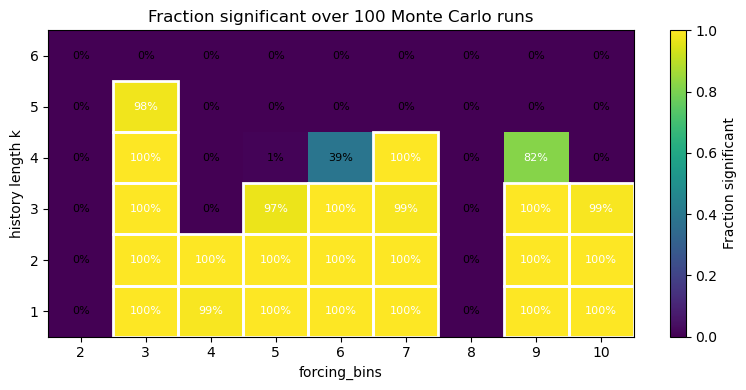

In [392]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)


fractions= sa.mc_TE_heatmap(
    pre =df_pre_i['pre'].values,
    sq =df_sq_i['filt_ch4'].values,
    niter=100,
    n_surr=100,
    alpha=0.05,
    ks=None,
    gbins=None,
    p_thresh=0.9,
    n_jobs=-1,
    if_plot=False,
    plot=True)

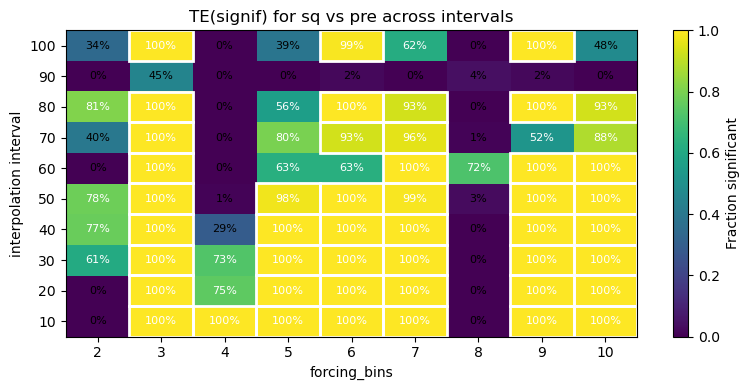

In [393]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

f=sa.mc_TE_heatmap_inter(
    df_sq_i,
    target_column='filt_ch4',
    intervals=None,
    niter=100,
    n_surr=100,
    alpha=0.05,
    k=1,
    gbins=None,
    p_thresh=0.9,
    n_jobs=-1,
    if_plot=False,
    forcing_var='pre',
    plot=True
)

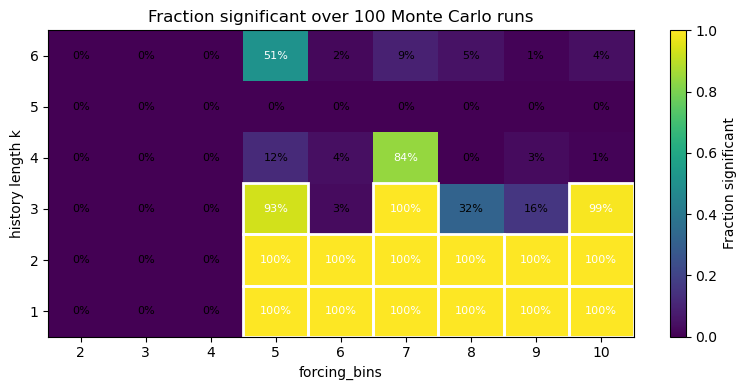

In [394]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)


fractions= sa.mc_TE_heatmap(
    pre =df_obl_i['obl'].values,
    sq =df_sq_i['filt_ch4'].values,
    niter=100,
    n_surr=100,
    alpha=0.05,
    ks=None,
    gbins=None,
    p_thresh=0.9,
    n_jobs=-1,
    if_plot=False,
    plot=True)

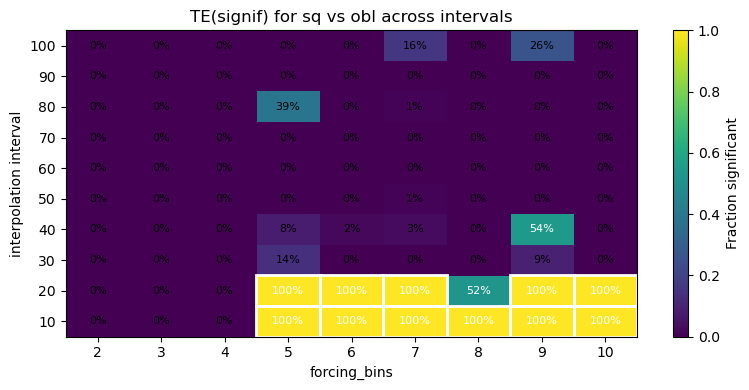

In [395]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

f=sa.mc_TE_heatmap_inter(
    df_sq_i,
    target_column='filt_ch4',
    intervals=None,
    niter=100,
    n_surr=100,
    alpha=0.05,
    k=1,
    gbins=None,
    p_thresh=0.9,
    n_jobs=-1,
    if_plot=False,
    forcing_var='obl',
    plot=True
)

In [407]:
import numpy as np
from toolbox import sq_ana as sa
import importlib
importlib.reload(sa)

# how many random trials?
N = 100

# your maximum age error (as ratio)
max_age_error = 5800 # the maximum age uncertainty of AICC2023 gas age (Bouchet et al., 2023)
max_age_ratio = max_age_error / np.max(df_filt_ch4['age'].values)

# sigma so that ±2σ = ±max_age_ratio
sigma = max_age_ratio / 2.0

# counters
count_pre_sq = 0
count_obl_sq = 0

for _ in range(N):
    # draw a random ratio, truncated to [-max_age_ratio, +max_age_ratio]
    r = np.random.normal(0, sigma)
    r = np.clip(r, -max_age_ratio, max_age_ratio)
    
    # stretch your age axis
    df_sq_stretch = df_filt_ch4.copy()
    df_sq_stretch['age'] = df_sq_stretch['age'].values * (1.0 + r)
    
    # re-interpolate
    df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(
        df_sq_stretch, 20, if_plot=False
    )
    
    pre = df_pre_i['pre'].values
    obl = df_obl_i['obl'].values
    sq  = df_sq_i['filt_ch4'].values
    
    # test pre → sq
    result_pre, _ = sa.transfer_entropy_surrogate_test(
        pre, sq, forcing_bins=6, sq_bins=2, if_plot=False
    )
    if result_pre:
        count_pre_sq += 1
    
    # test obl → sq
    result_obl, _ = sa.transfer_entropy_surrogate_test(
        obl, sq, forcing_bins=6, sq_bins=2, if_plot=False
    )
    if result_obl:
        count_obl_sq += 1

# report
print(f"Out of {N} random age-errors:")
print(f"  pre → sq was significant in {count_pre_sq} runs")
print(f"  obl → sq was significant in {count_obl_sq} runs")


Out of 100 random age-errors:
  pre → sq was significant in 84 runs
  obl → sq was significant in 83 runs


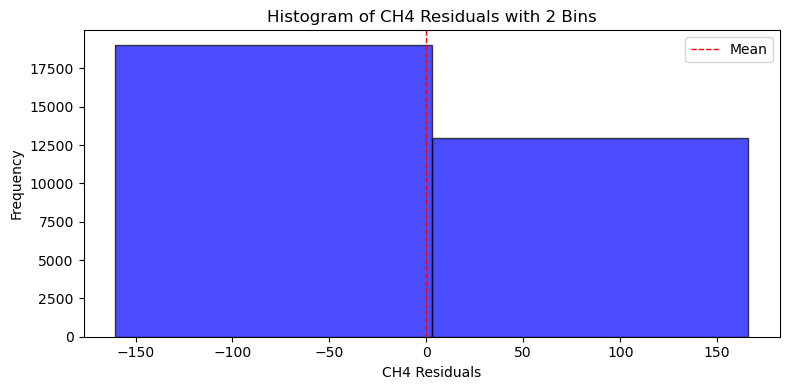

In [5]:
# plot the histogram of sq with bins=2
plt.figure(figsize=(8, 4))
plt.hist(sq, bins=2, color='blue', alpha=0.7, edgecolor='black')
plt.title('Histogram of CH4 Residuals with 2 Bins')
plt.xlabel('CH4 Residuals')
plt.ylabel('Frequency')
plt.axvline(np.mean(sq), color='red', linestyle='dashed', linewidth=1, label='Mean')
plt.legend()
plt.tight_layout()

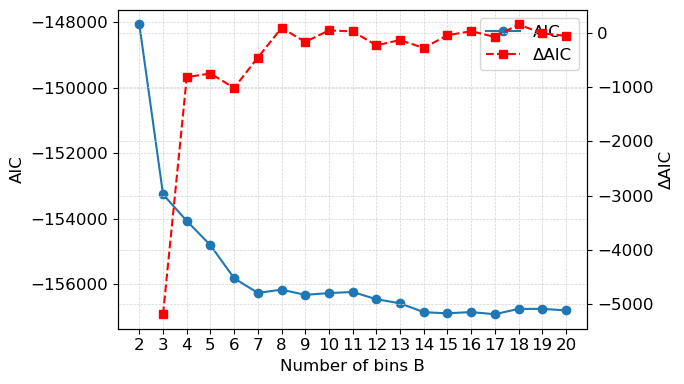

In [157]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

sa.plot_aic_delta(pre)

In [4]:
import numpy as np
import pandas as pd

# Suppose your real pre array is already loaded; here’s synthetic test data:
np.random.seed(42)
pre = np.random.randn(32014)

N = pre.size

# 1) Sturges’ rule
sturges = int(np.ceil(np.log2(N) + 1))

# 2) Scott’s rule
sigma = np.std(pre, ddof=1)
bin_width_scott = 3.5 * sigma / (N ** (1/3))
scott = int(np.ceil((pre.max() - pre.min()) / bin_width_scott))

# 3) Freedman–Diaconis rule
iqr = np.percentile(pre, 75) - np.percentile(pre, 25)
bin_width_fd = 2 * iqr / (N ** (1/3))
fd = int(np.ceil((pre.max() - pre.min()) / bin_width_fd))

# Collect and display
df = pd.DataFrame({
    'Rule': ['Sturges', 'Scott', 'Freedman–Diaconis'],
    'Bin count': [sturges, scott, fd]
})

print(df)


                Rule  Bin count
0            Sturges         16
1              Scott         77
2  Freedman–Diaconis         99


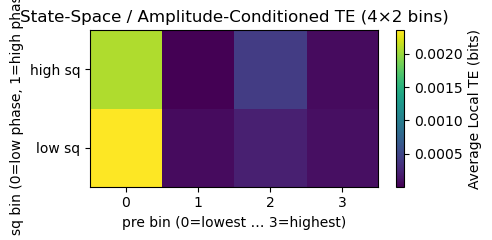

Joint counts (rows = pre_bin 0..3; cols = sq_bin 0..1):
[[1286 1053]
 [2943 2624]
 [3107 2737]
 [1161 1095]]

Marginal counts for pre_bin (0..3):
  pre_bin 0: 2339
  pre_bin 1: 5567
  pre_bin 2: 5844
  pre_bin 3: 2256

Marginal counts for sq_bin (0=low, 1=high):
  sq low (0):  8497
  sq high (1): 7509
Cell (pre=low, sq=low): 1286 samples
   P(sq_next=0 | 0,0) = 0.975
   P(sq_next=1 | 0,0) = 0.025

Cell (pre=high, sq=low): 1161 samples
   P(sq_next=0 | 3,0) = 0.967
   P(sq_next=1 | 3,0) = 0.033
Cell (pre=low, sq=high): 1053 samples
   P(sq_next=0 | 0,1) = 0.029
   P(sq_next=1 | 0,1) = 0.971

Cell (pre=high, sq=high): 1095 samples
   P(sq_next=0 | 3,1) = 0.037
   P(sq_next=1 | 3,1) = 0.963


In [20]:

import numpy as np
import matplotlib.pyplot as plt
from pyinform import transfer_entropy





pre = df_pre_i['pre'].values      # source (precession)
sq = df_sq_i['filt_ch4'].values    # target (residual)
sq  = sq[::-1]
pre = pre[::-1]

# Pre: 4 bins
nbins_pre = 4
bins_pre  = np.histogram_bin_edges(pre, bins=nbins_pre)
pre_disc  = np.digitize(pre, bins_pre) - 1      # 0..3

# SQ: 2 bins (0/1)
sq_disc   = (sq > 0).astype(int)               # 0..1



# --- 2) Compute local TE (k=1) ---
local_te = transfer_entropy(pre_disc, sq_disc, k=1, local=True)

# --- 2a) Flatten and auto-align ---
# Get a 1D array
te_arr = local_te.flatten()

# Number of original samples
N = pre_disc.shape[0]

# Past‐state indices each have length N-1
x_idx = pre_disc[:-1]
y_idx = sq_disc[:-1]

# Decide how to slice te_arr so it lines up with x_idx/y_idx
if te_arr.shape[0] == N:
    # TE[0] corresponds to t=0 → drop it
    te = te_arr[1:]
elif te_arr.shape[0] == N-1:
    # Already aligned
    te = te_arr
else:
    raise ValueError(
        f"Unexpected local_te length: {te_arr.shape[0]} (expected {N} or {N-1})"
    )

# sanity check
assert te.shape[0] == x_idx.shape[0] == y_idx.shape[0], (
    f"Shapes mismatch: te {te.shape}, x_idx {x_idx.shape}, y_idx {y_idx.shape}"
)
# --- 3) Build the heatmap ---
nbins_pre = 4
heatmap = np.full((nbins_pre, 2), np.nan)
for i in range(nbins_pre):
    for j in (0, 1):
        mask = (x_idx == i) & (y_idx == j)
        if mask.any():
            heatmap[i, j] = te[mask].mean()

# --- 4) Plot ---
plt.figure(figsize=(5,2.5))
plt.imshow(heatmap.T, origin='lower', aspect='auto',
           extent=[0, nbins_pre, 0, 2])
plt.colorbar(label='Average Local TE (bits)')
plt.xlabel('pre bin (0=lowest … 3=highest)')
plt.ylabel('sq bin (0=low phase, 1=high phase)')
plt.title('State‐Space / Amplitude‐Conditioned TE (4×2 bins)')
plt.yticks([0.5,1.5], ['low sq','high sq'])
plt.xticks(np.arange(0.5, nbins_pre+0.5), np.arange(nbins_pre))
plt.tight_layout()
plt.show()

nbins_pre = 4
nbins_sq  = 2

# Clip into [0, nbins-1]
x_idx_clipped = np.clip(x_idx, 0, nbins_pre-1)
y_idx_clipped = np.clip(y_idx, 0, nbins_sq -1)

# 1) Joint counts for (pre_bin, sq_bin)
joint_counts = np.zeros((nbins_pre, nbins_sq), dtype=int)
for xi, yi in zip(x_idx_clipped, y_idx_clipped):
    joint_counts[xi, yi] += 1

print("Joint counts (rows = pre_bin 0..3; cols = sq_bin 0..1):")
print(joint_counts)

# 2) Marginal counts for pre alone
pre_counts = np.bincount(x_idx_clipped, minlength=nbins_pre)
print("\nMarginal counts for pre_bin (0..3):")
for i, c in enumerate(pre_counts):
    print(f"  pre_bin {i}: {c}")

# 3) Marginal counts for sq alone
sq_counts = np.bincount(y_idx_clipped, minlength=nbins_sq)
print("\nMarginal counts for sq_bin (0=low, 1=high):")
print(f"  sq low (0):  {sq_counts[0]}")
print(f"  sq high (1): {sq_counts[1]}")



# Clip indices just in case
x_idx_clipped = np.clip(x_idx, 0, nbins_pre-1)
y_idx_clipped = np.clip(y_idx, 0, 1)
z_idx = sq_disc[1:]   # future state of sq, 0 or 1

# Function to compute P(z | x=i, y=j)
def transition_probs(i, j):
    mask = (x_idx_clipped == i) & (y_idx_clipped == j)
    counts = np.bincount(z_idx[mask], minlength=2)
    total = counts.sum()
    return counts / total, total

# Get for the “low-pre & low-sq” cell (i=0, j=0)
probs_00, total_00 = transition_probs(0, 0)
print(f"Cell (pre=low, sq=low): {total_00} samples")
print(f"   P(sq_next=0 | 0,0) = {probs_00[0]:.3f}")
print(f"   P(sq_next=1 | 0,0) = {probs_00[1]:.3f}")

# And for comparison, say “pre=high, sq=low” (i=3, j=0)
probs_30, total_30 = transition_probs(3, 0)
print(f"\nCell (pre=high, sq=low): {total_30} samples")
print(f"   P(sq_next=0 | 3,0) = {probs_30[0]:.3f}")
print(f"   P(sq_next=1 | 3,0) = {probs_30[1]:.3f}")



probs_00, total_00 = transition_probs(0, 1)
print(f"Cell (pre=low, sq=high): {total_00} samples")
print(f"   P(sq_next=0 | 0,1) = {probs_00[0]:.3f}")
print(f"   P(sq_next=1 | 0,1) = {probs_00[1]:.3f}")

# And for comparison, say “pre=high, sq=low” (i=3, j=0)
probs_30, total_30 = transition_probs(3, 1)
print(f"\nCell (pre=high, sq=high): {total_30} samples")
print(f"   P(sq_next=0 | 3,1) = {probs_30[0]:.3f}")
print(f"   P(sq_next=1 | 3,1) = {probs_30[1]:.3f}")

# What the high TE here means

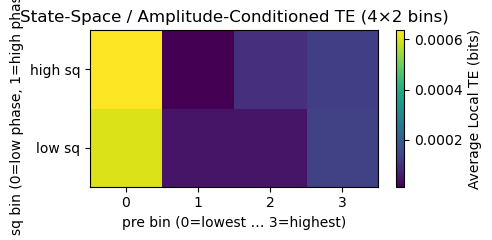

z=0: p=0.993, baseline=0.990, contrib=0.0039 bits
z=1: p=0.007, baseline=0.010, contrib=-0.0033 bits
Surrogate TE₀₀:   0.0000 ± 0.0001
Original TE₀₀:    0.0006


In [335]:

import numpy as np
import matplotlib.pyplot as plt
from pyinform import transfer_entropy





pre = df_pre_i['pre'].values      # source (precession)
sq = df_sq_i['filt_ch4'].values    # target (residual)
sq  = sq[::-1]
pre = pre[::-1]

# Pre: 4 bins
nbins_pre = 4
bins_pre  = np.histogram_bin_edges(pre, bins=nbins_pre)
pre_disc  = np.digitize(pre, bins_pre) - 1      # 0..3

# SQ: 2 bins (0/1)
sq_disc   = (sq > 0).astype(int)               # 0..1



# --- 2) Compute local TE (k=1) ---
local_te = transfer_entropy(pre_disc, sq_disc, k=1, local=True)

# --- 2a) Flatten and auto-align ---
# Get a 1D array
te_arr = local_te.flatten()

# Number of original samples
N = pre_disc.shape[0]

# Past‐state indices each have length N-1
x_idx = pre_disc[:-1]
y_idx = sq_disc[:-1]

# Decide how to slice te_arr so it lines up with x_idx/y_idx
if te_arr.shape[0] == N:
    # TE[0] corresponds to t=0 → drop it
    te = te_arr[1:]
elif te_arr.shape[0] == N-1:
    # Already aligned
    te = te_arr
else:
    raise ValueError(
        f"Unexpected local_te length: {te_arr.shape[0]} (expected {N} or {N-1})"
    )

# sanity check
assert te.shape[0] == x_idx.shape[0] == y_idx.shape[0], (
    f"Shapes mismatch: te {te.shape}, x_idx {x_idx.shape}, y_idx {y_idx.shape}"
)
# --- 3) Build the heatmap ---
nbins_pre = 4
heatmap = np.full((nbins_pre, 2), np.nan)
for i in range(nbins_pre):
    for j in (0, 1):
        mask = (x_idx == i) & (y_idx == j)
        if mask.any():
            heatmap[i, j] = te[mask].mean()

# --- 4) Plot ---
plt.figure(figsize=(5,2.5))
plt.imshow(heatmap.T, origin='lower', aspect='auto',
           extent=[0, nbins_pre, 0, 2])
plt.colorbar(label='Average Local TE (bits)')
plt.xlabel('pre bin (0=lowest … 3=highest)')
plt.ylabel('sq bin (0=low phase, 1=high phase)')
plt.title('State‐Space / Amplitude‐Conditioned TE (4×2 bins)')
plt.yticks([0.5,1.5], ['low sq','high sq'])
plt.xticks(np.arange(0.5, nbins_pre+0.5), np.arange(nbins_pre))
plt.tight_layout()
plt.show()



x_idx_clipped = np.clip(x_idx, 0, nbins_pre-1)
y_idx_clipped = np.clip(y_idx, 0, 1)
z_idx = sq_disc[1:]   # future state of sq, 0 or 1
# 1) global marginal p(z | y=0)
mask_y0 = (y_idx == 0)
counts_y0 = np.bincount(z_idx[mask_y0], minlength=2)
p_z_given_y0 = counts_y0 / counts_y0.sum()

# 2) conditional p(z | x=0, y=0)
mask_00 = (x_idx == 0) & (y_idx == 0)
counts_00 = np.bincount(z_idx[mask_00], minlength=2)
p_z_given_00 = counts_00 / counts_00.sum()

# 3) contribution of each outcome
for z in (0,1):
    contrib = p_z_given_00[z] * np.log2(p_z_given_00[z] / p_z_given_y0[z])
    print(f"z={z}: p={p_z_given_00[z]:.3f}, "
          f"baseline={p_z_given_y0[z]:.3f}, contrib={contrib:.4f} bits")
    



import numpy as np
from pyinform import transfer_entropy

n_surr = 100
te00_surr = np.zeros(n_surr)

for i in range(n_surr):
    # 1) Permute source
    pre_surr = np.random.permutation(pre_disc)

    # 2) Compute local TE
    local_te_s = transfer_entropy(pre_surr, sq_disc, k=1, local=True)
    arr = local_te_s.flatten()

    # 3) Align to length N-1
    if arr.shape[0] == N:
        te_s = arr[1:]
    elif arr.shape[0] == N-1:
        te_s = arr
    else:
        raise ValueError(
            f"Unexpected local_te length: {arr.shape[0]}"
        )

    # 4) Extract the (pre=0, sq=0) cell mean
    mask = (x_idx == 0) & (y_idx == 0)
    te00_surr[i] = te_s[mask].mean()

# Finally compare
print("Surrogate TE₀₀:  ",
      f"{te00_surr.mean():.4f} ± {te00_surr.std():.4f}")
print("Original TE₀₀:   ", f"{heatmap[0,0]:.4f}")


   pre_bin  sq_bin   p(flip)  baseline(flip)  contrib(flip)   p(stay)  \
0        0       0  0.007013        0.009706      -0.003288  0.992987   
1        0       1  0.991956        0.989010       0.004257  0.008044   
2        1       0  0.010531        0.009706       0.001239  0.989469   
3        1       1  0.988545        0.989010      -0.000670  0.011455   
4        2       0  0.010525        0.009706       0.001229  0.989475   
5        2       1  0.987760        0.989010      -0.001802  0.012240   
6        3       0  0.008398        0.009706      -0.001754  0.991602   
7        3       1  0.990380        0.989010       0.001978  0.009620   

   baseline(stay)  contrib(stay)   TE_orig  TE_surr_mean  TE_surr_sd   z_score  
0        0.990294       0.003890  0.000602      0.000053    0.000161  3.408907  
1        0.010990      -0.003622  0.000635      0.000050    0.000164  3.579371  
2        0.990294      -0.001189  0.000050      0.000101    0.000124 -0.415219  
3        0.010990 

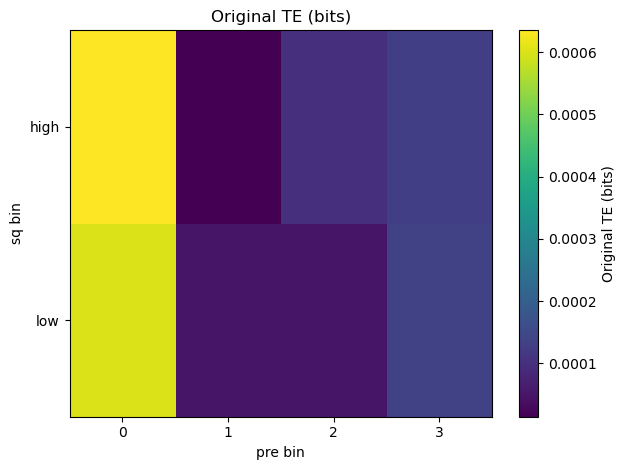

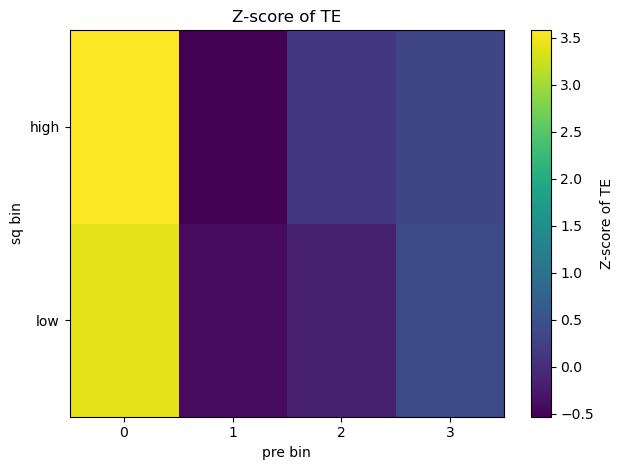

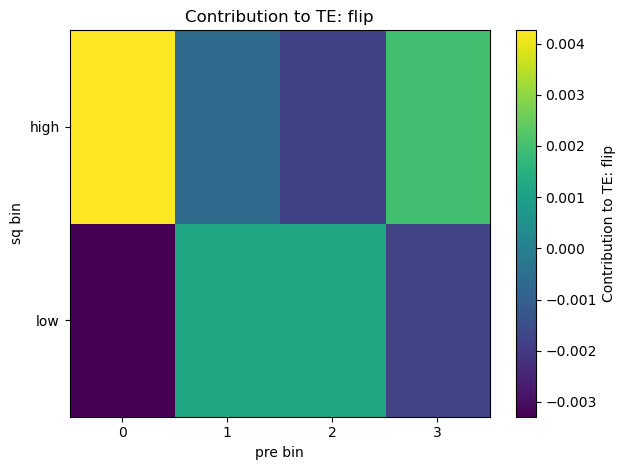

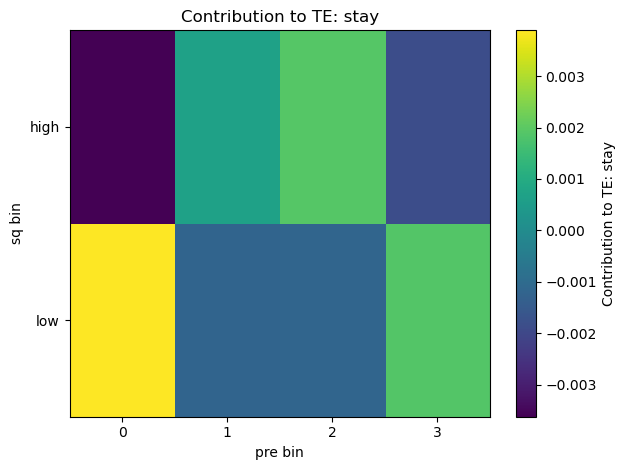

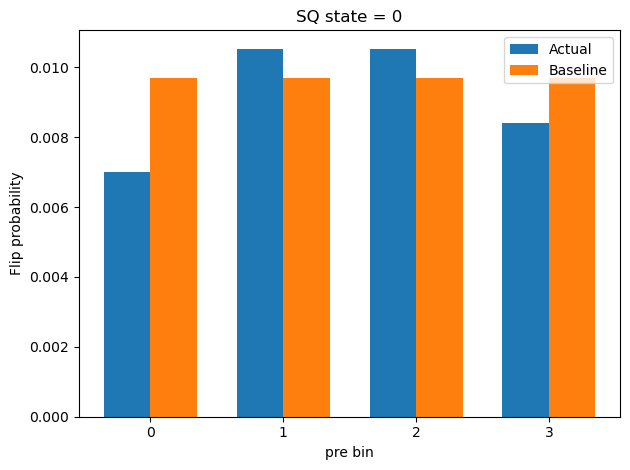

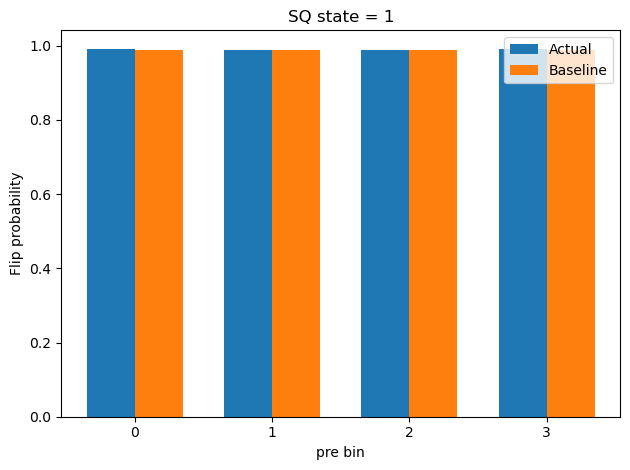

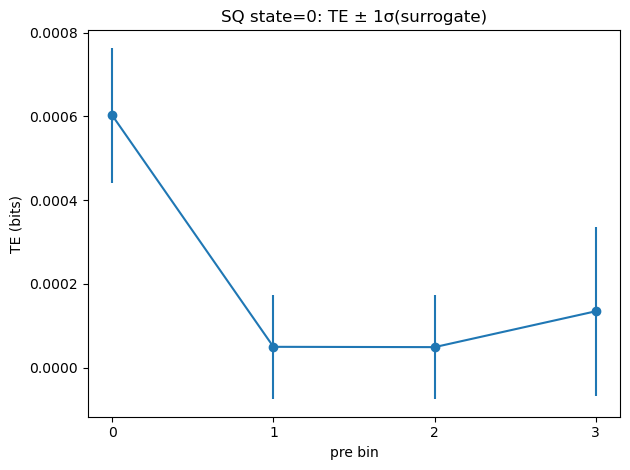

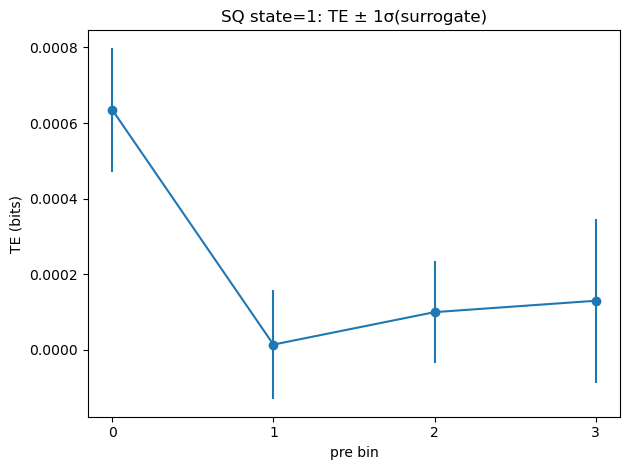

In [ ]:
import numpy as np
from pyinform import transfer_entropy

pre = df_pre_i['pre'].values      # source (precession)
sq = df_sq_i['filt_ch4'].values    # target (residual)
sq  = sq[::-1]
pre = pre[::-1]

# Pre: 4 bins
nbins_pre = 4
bins_pre  = np.histogram_bin_edges(pre, bins=nbins_pre)
pre_disc  = np.digitize(pre, bins_pre) - 1      # 0..3

# SQ: 2 bins (0/1)
sq_disc   = (sq > 0).astype(int)               # 0..1

# --- 2) Compute local TE (k=1) ---
local_te = transfer_entropy(pre_disc, sq_disc, k=1, local=True)

# --- 2a) Flatten and auto-align ---
# Get a 1D array
te_arr = local_te.flatten()

# Number of original samples
N = pre_disc.shape[0]

# Past‐state indices each have length N-1
x_idx = pre_disc[:-1]
y_idx = sq_disc[:-1]

nbins_pre = 4
nbins_sq  = 2

# Precompute the marginal baselines p(z | y=j) for j=0,1
p_z_given_y = {}
for j in (0,1):
    mask_y = (y_idx == j)
    counts = np.bincount(z_idx[mask_y], minlength=2)
    p_z_given_y[j] = counts / counts.sum()

# Compute the original TE heatmap once
local_te = transfer_entropy(pre_disc, sq_disc, k=1, local=True).flatten()
te = local_te[1:] if local_te.shape[0]==N else local_te  # align

heatmap = np.full((nbins_pre, nbins_sq), np.nan)
for i in range(nbins_pre):
    for j in (0,1):
        mask = (x_idx==i)&(y_idx==j)
        if mask.any():
            heatmap[i,j] = te[mask].mean()

# Now loop over all cells
n_surr = 200
results = []

for i in range(nbins_pre):
    for j in (0,1):
        mask_ij = (x_idx==i)&(y_idx==j)
        if not mask_ij.any(): 
            continue

        # 1) Empirical p(z|i,j)
        counts_ij = np.bincount(z_idx[mask_ij], minlength=2)
        p_ij = counts_ij / counts_ij.sum()

        # 2) Contributions
        contribs = []
        for z in (0,1):
            pj = p_z_given_y[j][z]
            pij = p_ij[z]
            if pij>0 and pj>0:
                contribs.append(pij * np.log2(pij/pj))
            else:
                contribs.append(0.0)

        # 3) Surrogate TE distribution in this cell
        te_surr = np.zeros(n_surr)
        for k in range(n_surr):
            pre_s = np.random.permutation(pre_disc)
            local_s = transfer_entropy(pre_s, sq_disc, k=1, local=True).flatten()
            te_k  = local_s[1:] if local_s.shape[0]==N else local_s
            te_surr[k] = te_k[mask_ij].mean()

        mu_surr, sd_surr = te_surr.mean(), te_surr.std()
        te_orig = heatmap[i,j]

        results.append({
            'pre_bin': i,
            'sq_bin' : j,
            'p(stay)' : p_ij[0],
            'p(flip)' : p_ij[1],
            'baseline(stay)': p_z_given_y[j][0],
            'baseline(flip)': p_z_given_y[j][1],
            'contrib(stay)': contribs[0],
            'contrib(flip)': contribs[1],
            'TE_orig': te_orig,
            'TE_surr_mean': mu_surr,
            'TE_surr_sd': sd_surr,
            'z_score': (te_orig-mu_surr)/sd_surr
        })

# Print a nice table
import pandas as pd
df = pd.DataFrame(results)
print(df[['pre_bin','sq_bin',
          'p(flip)','baseline(flip)','contrib(flip)',
          'p(stay)','baseline(stay)','contrib(stay)',
          'TE_orig','TE_surr_mean','TE_surr_sd','z_score']])



import matplotlib.pyplot as plt
import numpy as np


# Pivot the data for heatmap plotting
pivot_te = df.pivot(index='sq_bin', columns='pre_bin', values='TE_orig').values
pivot_z = df.pivot(index='sq_bin', columns='pre_bin', values='z_score').values
pivot_flip = df.pivot(index='sq_bin', columns='pre_bin', values='contrib(flip)').values
pivot_stay = df.pivot(index='sq_bin', columns='pre_bin', values='contrib(stay)').values

# A helper to plot a heatmap
def plot_heatmap(data, title, ylabel='sq bin', xlabel='pre bin'):
    plt.figure()
    plt.imshow(data, origin='lower', aspect='auto',
               extent=[0, data.shape[1], 0, data.shape[0]])
    plt.colorbar(label=title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.yticks([0.5, 1.5], ['low', 'high'])
    plt.xticks(np.arange(0.5, data.shape[1] + 0.5), np.arange(data.shape[1]))
    plt.tight_layout()
    plt.show()

# Plot each metric
plot_heatmap(pivot_te,    'Original TE (bits)')
plot_heatmap(pivot_z,     'Z-score of TE')
plot_heatmap(pivot_flip,  'Contribution to TE: flip')
plot_heatmap(pivot_stay,  'Contribution to TE: stay')




import numpy as np

for sq_state in (0,1):
    sub = df[df['sq_bin']==sq_state]
    x = sub['pre_bin']
    w = 0.35
    plt.figure()
    plt.bar(x - w/2, sub['p(flip)'], width=w)
    plt.bar(x + w/2, sub['baseline(flip)'], width=w)
    plt.xlabel('pre bin')
    plt.ylabel('Flip probability')
    plt.title(f'SQ state = {sq_state}')
    plt.legend(['Actual','Baseline'])
    plt.xticks([0,1,2,3])
    plt.tight_layout()
    plt.show()

for sq_state in (0,1):
    sub = df[df['sq_bin']==sq_state]
    plt.figure()
    plt.errorbar(sub['pre_bin'], sub['TE_orig'],
                 yerr=sub['TE_surr_sd'], fmt='o-')
    plt.xlabel('pre bin')
    plt.ylabel('TE (bits)')
    plt.title(f'SQ state={sq_state}: TE ± 1σ(surrogate)')
    plt.xticks([0,1,2,3])
    plt.tight_layout()
    plt.show()


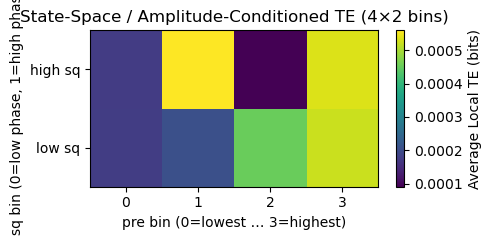

Joint counts (rows = pre_bin 0..3; cols = sq_bin 0..1):
[[1696 1436]
 [2234 2110]
 [2208 1933]
 [2359 2030]]

Marginal counts for pre_bin (0..3):
  pre_bin 0: 3132
  pre_bin 1: 4344
  pre_bin 2: 4141
  pre_bin 3: 4389

Marginal counts for sq_bin (0=low, 1=high):
  sq low (0):  8497
  sq high (1): 7509
Cell (pre=low, sq=low): 1696 samples
   P(sq_next=0 | 0,0) = 0.962
   P(sq_next=1 | 0,0) = 0.038

Cell (pre=high, sq=low): 2359 samples
   P(sq_next=0 | 3,0) = 0.960
   P(sq_next=1 | 3,0) = 0.040
Cell (pre=low, sq=high): 1436 samples
   P(sq_next=0 | 0,1) = 0.042
   P(sq_next=1 | 0,1) = 0.958

Cell (pre=high, sq=high): 2030 samples
   P(sq_next=0 | 3,1) = 0.045
   P(sq_next=1 | 3,1) = 0.955


In [21]:

import numpy as np
import matplotlib.pyplot as plt
from pyinform import transfer_entropy





pre = df_obl_i['obl'].values      # source (precession)
sq = df_sq_i['filt_ch4'].values    # target (residual)
sq  = sq[::-1]
pre = pre[::-1]

# Pre: 4 bins
nbins_pre = 4
bins_pre  = np.histogram_bin_edges(pre, bins=nbins_pre)
pre_disc  = np.digitize(pre, bins_pre) - 1      # 0..3

# SQ: 2 bins (0/1)
sq_disc   = (sq > 0).astype(int)               # 0..1



# --- 2) Compute local TE (k=1) ---
local_te = transfer_entropy(pre_disc, sq_disc, k=1, local=True)

# --- 2a) Flatten and auto-align ---
# Get a 1D array
te_arr = local_te.flatten()

# Number of original samples
N = pre_disc.shape[0]

# Past‐state indices each have length N-1
x_idx = pre_disc[:-1]
y_idx = sq_disc[:-1]

# Decide how to slice te_arr so it lines up with x_idx/y_idx
if te_arr.shape[0] == N:
    # TE[0] corresponds to t=0 → drop it
    te = te_arr[1:]
elif te_arr.shape[0] == N-1:
    # Already aligned
    te = te_arr
else:
    raise ValueError(
        f"Unexpected local_te length: {te_arr.shape[0]} (expected {N} or {N-1})"
    )

# sanity check
assert te.shape[0] == x_idx.shape[0] == y_idx.shape[0], (
    f"Shapes mismatch: te {te.shape}, x_idx {x_idx.shape}, y_idx {y_idx.shape}"
)
# --- 3) Build the heatmap ---
nbins_pre = 4
heatmap = np.full((nbins_pre, 2), np.nan)
for i in range(nbins_pre):
    for j in (0, 1):
        mask = (x_idx == i) & (y_idx == j)
        if mask.any():
            heatmap[i, j] = te[mask].mean()

# --- 4) Plot ---
plt.figure(figsize=(5,2.5))
plt.imshow(heatmap.T, origin='lower', aspect='auto',
           extent=[0, nbins_pre, 0, 2])
plt.colorbar(label='Average Local TE (bits)')
plt.xlabel('pre bin (0=lowest … 3=highest)')
plt.ylabel('sq bin (0=low phase, 1=high phase)')
plt.title('State‐Space / Amplitude‐Conditioned TE (4×2 bins)')
plt.yticks([0.5,1.5], ['low sq','high sq'])
plt.xticks(np.arange(0.5, nbins_pre+0.5), np.arange(nbins_pre))
plt.tight_layout()
plt.show()

nbins_pre = 4
nbins_sq  = 2

# Clip into [0, nbins-1]
x_idx_clipped = np.clip(x_idx, 0, nbins_pre-1)
y_idx_clipped = np.clip(y_idx, 0, nbins_sq -1)

# 1) Joint counts for (pre_bin, sq_bin)
joint_counts = np.zeros((nbins_pre, nbins_sq), dtype=int)
for xi, yi in zip(x_idx_clipped, y_idx_clipped):
    joint_counts[xi, yi] += 1

print("Joint counts (rows = pre_bin 0..3; cols = sq_bin 0..1):")
print(joint_counts)

# 2) Marginal counts for pre alone
pre_counts = np.bincount(x_idx_clipped, minlength=nbins_pre)
print("\nMarginal counts for pre_bin (0..3):")
for i, c in enumerate(pre_counts):
    print(f"  pre_bin {i}: {c}")

# 3) Marginal counts for sq alone
sq_counts = np.bincount(y_idx_clipped, minlength=nbins_sq)
print("\nMarginal counts for sq_bin (0=low, 1=high):")
print(f"  sq low (0):  {sq_counts[0]}")
print(f"  sq high (1): {sq_counts[1]}")



# Clip indices just in case
x_idx_clipped = np.clip(x_idx, 0, nbins_pre-1)
y_idx_clipped = np.clip(y_idx, 0, 1)
z_idx = sq_disc[1:]   # future state of sq, 0 or 1

# Function to compute P(z | x=i, y=j)
def transition_probs(i, j):
    mask = (x_idx_clipped == i) & (y_idx_clipped == j)
    counts = np.bincount(z_idx[mask], minlength=2)
    total = counts.sum()
    return counts / total, total

# Get for the “low-pre & low-sq” cell (i=0, j=0)
probs_00, total_00 = transition_probs(0, 0)
print(f"Cell (pre=low, sq=low): {total_00} samples")
print(f"   P(sq_next=0 | 0,0) = {probs_00[0]:.3f}")
print(f"   P(sq_next=1 | 0,0) = {probs_00[1]:.3f}")

# And for comparison, say “pre=high, sq=low” (i=3, j=0)
probs_30, total_30 = transition_probs(3, 0)
print(f"\nCell (pre=high, sq=low): {total_30} samples")
print(f"   P(sq_next=0 | 3,0) = {probs_30[0]:.3f}")
print(f"   P(sq_next=1 | 3,0) = {probs_30[1]:.3f}")



probs_00, total_00 = transition_probs(0, 1)
print(f"Cell (pre=low, sq=high): {total_00} samples")
print(f"   P(sq_next=0 | 0,1) = {probs_00[0]:.3f}")
print(f"   P(sq_next=1 | 0,1) = {probs_00[1]:.3f}")

# And for comparison, say “pre=high, sq=low” (i=3, j=0)
probs_30, total_30 = transition_probs(3, 1)
print(f"\nCell (pre=high, sq=high): {total_30} samples")
print(f"   P(sq_next=0 | 3,1) = {probs_30[0]:.3f}")
print(f"   P(sq_next=1 | 3,1) = {probs_30[1]:.3f}")

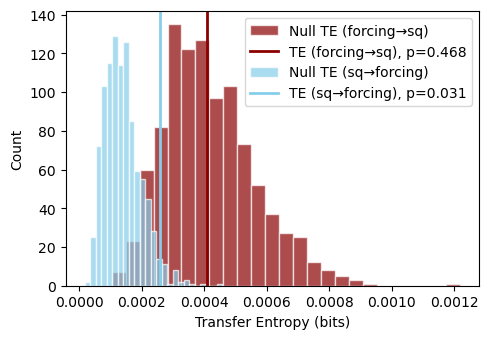

False


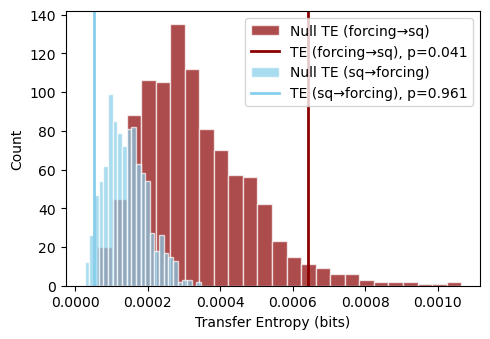

True


In [416]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)





df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(df_filt_d18O.copy(), 10, if_plot=False)


pre = df_pre_i['pre'].values      # source (precession)
obl = df_obl_i['obl'].values    # target (obliquity)
sq = df_sq_i['filt_d18O'].values    # target (residual)


result,fig=sa.transfer_entropy_surrogate_test_v2(pre,sq, forcing_bins=6, sq_bins=2, n_surr=1000)

# fig.savefig('TE_NGRIP.pdf',format='pdf',bbox_inches='tight')
print(result)


result,fig=sa.transfer_entropy_surrogate_test_v2(obl,sq, forcing_bins=6, sq_bins=2, n_surr=1000)
print(result)


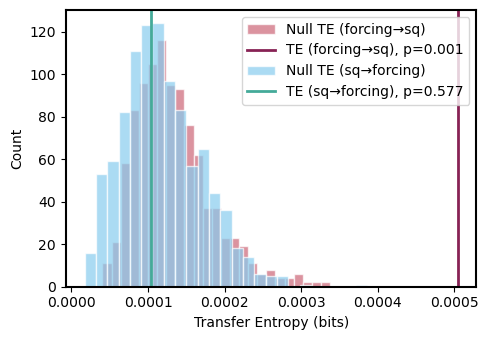

True


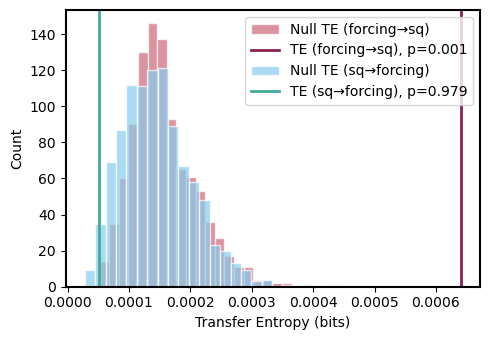

True


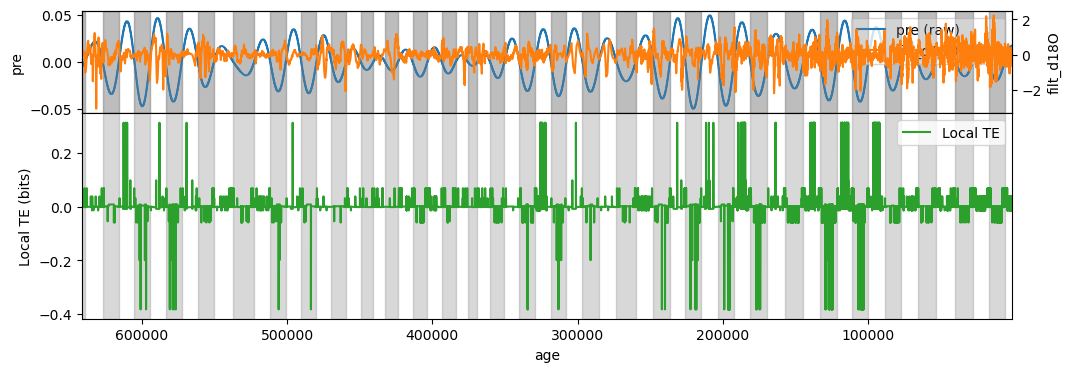

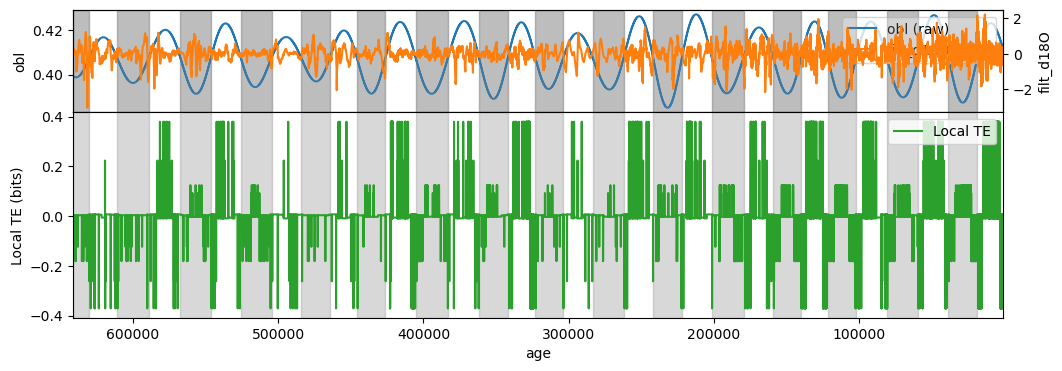

In [441]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

# age_ratio = 10000 / np.max(df_filt_ch4['age'].values)
# print(f"Age ratio: {age_ratio:.2f} (10000/Max Age)")
# df_filt_d18O['age'] = df_filt_d18O['age'].values * age_ratio

df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(df_filt_d18O.copy(), 10, if_plot=False)


pre = df_pre_i['pre'].values      # source (precession)
obl = df_obl_i['obl'].values    # target (obliquity)
sq = df_sq_i['filt_d18O'].values    # target (residual)


result,fig=sa.transfer_entropy_surrogate_test(pre,sq, forcing_bins=5, sq_bins=2, n_surr=1000)

# fig.savefig('TE_NGRIP.pdf',format='pdf',bbox_inches='tight')
print(result)
result,fig=sa.transfer_entropy_surrogate_test(obl,sq, forcing_bins=6, sq_bins=2, n_surr=1000)
print(result)


LTE = sa.local_TE(df_pre_i.copy(), df_sq_i.copy(),
                   forcing_column='pre',
                   target_column='filt_d18O',
                   time_column='age',
                   nbins_pre=5,
                   nbins_target=2)

LTE = sa.local_TE(df_obl_i.copy(), df_sq_i.copy(),
                   forcing_column='obl',
                   target_column='filt_d18O',
                   time_column='age',
                   nbins_pre=4,
                   nbins_target=2)

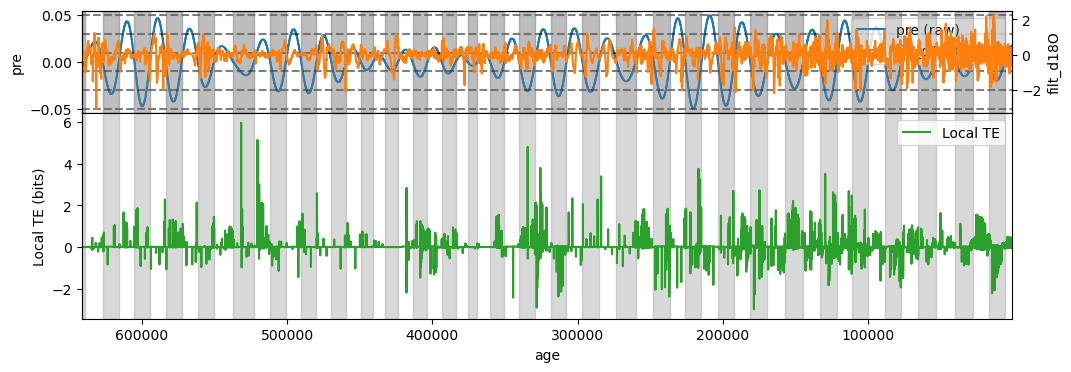

In [442]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

LTE = sa.moving_TE(df_pre_i.copy(), df_sq_i.copy(),
                   forcing_column='pre',
                   target_column='filt_d18O',
                   time_column='age',
                   nbins_pre=5,
                   nbins_target=2,
                   window_length=2000)



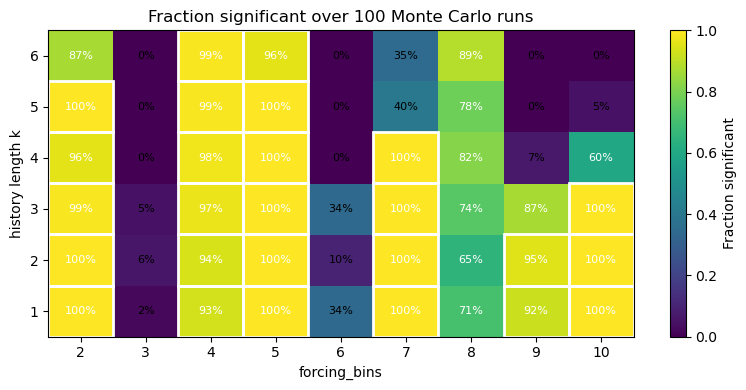

In [411]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)


fractions= sa.mc_TE_heatmap(
    pre =df_pre_i['pre'].values,
    sq =df_sq_i['filt_d18O'].values,
    niter=100,
    n_surr=100,
    alpha=0.05,
    ks=None,
    gbins=None,
    p_thresh=0.9,
    n_jobs=-1,
    if_plot=False,
    plot=True)

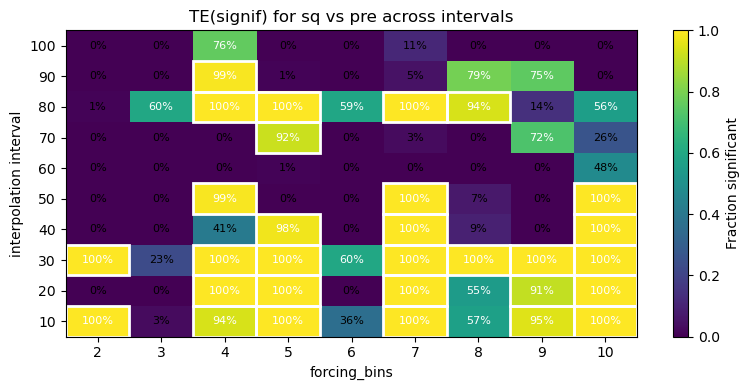

In [412]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

f=sa.mc_TE_heatmap_inter(
    df_sq_i,
    target_column='filt_d18O',
    intervals=None,
    niter=100,
    n_surr=100,
    alpha=0.05,
    k=1,
    gbins=None,
    p_thresh=0.9,
    n_jobs=-1,
    if_plot=False,
    forcing_var='pre',
    plot=True
)

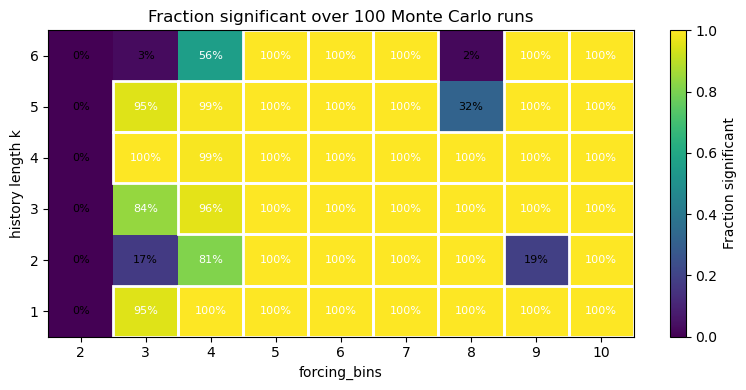

In [413]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)


fractions= sa.mc_TE_heatmap(
    pre =df_obl_i['obl'].values,
    sq =df_sq_i['filt_d18O'].values,
    niter=100,
    n_surr=100,
    alpha=0.05,
    ks=None,
    gbins=None,
    p_thresh=0.9,
    n_jobs=-1,
    if_plot=False,
    plot=True)

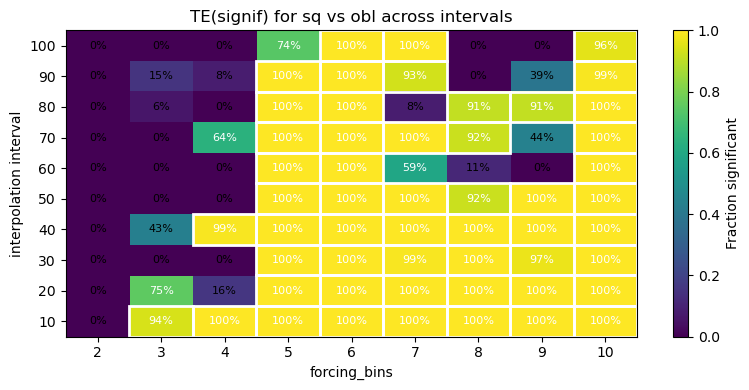

In [414]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

f=sa.mc_TE_heatmap_inter(
    df_sq_i,
    target_column='filt_d18O',
    intervals=None,
    niter=100,
    n_surr=100,
    alpha=0.05,
    k=1,
    gbins=None,
    p_thresh=0.9,
    n_jobs=-1,
    if_plot=False,
    forcing_var='obl',
    plot=True
)

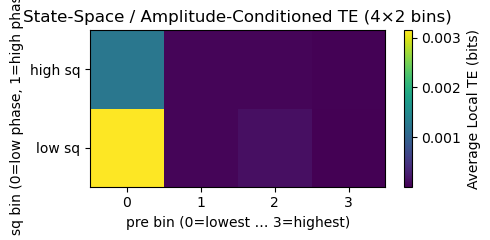

Joint counts (rows = pre_bin 0..3; cols = sq_bin 0..1):
[[1568 1597]
 [3559 3976]
 [4698 5623]
 [5185 5807]]

Marginal counts for pre_bin (0..3):
  pre_bin 0: 3165
  pre_bin 1: 7535
  pre_bin 2: 10321
  pre_bin 3: 10992

Marginal counts for sq_bin (0=low, 1=high):
  sq low (0):  15010
  sq high (1): 17003
Cell (pre=low, sq=low): 1568 samples
   P(sq_next=0 | 0,0) = 0.970
   P(sq_next=1 | 0,0) = 0.030

Cell (pre=high, sq=low): 5185 samples
   P(sq_next=0 | 3,0) = 0.955
   P(sq_next=1 | 3,0) = 0.045
Cell (pre=low, sq=high): 1597 samples
   P(sq_next=0 | 0,1) = 0.030
   P(sq_next=1 | 0,1) = 0.970

Cell (pre=high, sq=high): 5807 samples
   P(sq_next=0 | 3,1) = 0.039
   P(sq_next=1 | 3,1) = 0.961


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from pyinform import transfer_entropy





pre = df_pre_i['pre'].values      # source (precession)
sq = df_sq_i['filt_d18O'].values    # target (residual)
sq  = sq[::-1]
pre = pre[::-1]

# Pre: 4 bins
nbins_pre = 4
bins_pre  = np.histogram_bin_edges(pre, bins=nbins_pre)
pre_disc  = np.digitize(pre, bins_pre) - 1      # 0..3

# SQ: 2 bins (0/1)
sq_disc   = (sq > 0).astype(int)               # 0..1



# --- 2) Compute local TE (k=1) ---
local_te = transfer_entropy(pre_disc, sq_disc, k=1, local=True)

# --- 2a) Flatten and auto-align ---
# Get a 1D array
te_arr = local_te.flatten()

# Number of original samples
N = pre_disc.shape[0]

# Past‐state indices each have length N-1
x_idx = pre_disc[:-1]
y_idx = sq_disc[:-1]

# Decide how to slice te_arr so it lines up with x_idx/y_idx
if te_arr.shape[0] == N:
    # TE[0] corresponds to t=0 → drop it
    te = te_arr[1:]
elif te_arr.shape[0] == N-1:
    # Already aligned
    te = te_arr
else:
    raise ValueError(
        f"Unexpected local_te length: {te_arr.shape[0]} (expected {N} or {N-1})"
    )

# sanity check
assert te.shape[0] == x_idx.shape[0] == y_idx.shape[0], (
    f"Shapes mismatch: te {te.shape}, x_idx {x_idx.shape}, y_idx {y_idx.shape}"
)
# --- 3) Build the heatmap ---
nbins_pre = 4
heatmap = np.full((nbins_pre, 2), np.nan)
for i in range(nbins_pre):
    for j in (0, 1):
        mask = (x_idx == i) & (y_idx == j)
        if mask.any():
            heatmap[i, j] = te[mask].mean()

# --- 4) Plot ---
plt.figure(figsize=(5,2.5))
plt.imshow(heatmap.T, origin='lower', aspect='auto',
           extent=[0, nbins_pre, 0, 2])
plt.colorbar(label='Average Local TE (bits)')
plt.xlabel('pre bin (0=lowest … 3=highest)')
plt.ylabel('sq bin (0=low phase, 1=high phase)')
plt.title('State‐Space / Amplitude‐Conditioned TE (4×2 bins)')
plt.yticks([0.5,1.5], ['low sq','high sq'])
plt.xticks(np.arange(0.5, nbins_pre+0.5), np.arange(nbins_pre))
plt.tight_layout()
plt.show()

nbins_pre = 4
nbins_sq  = 2

# Clip into [0, nbins-1]
x_idx_clipped = np.clip(x_idx, 0, nbins_pre-1)
y_idx_clipped = np.clip(y_idx, 0, nbins_sq -1)

# 1) Joint counts for (pre_bin, sq_bin)
joint_counts = np.zeros((nbins_pre, nbins_sq), dtype=int)
for xi, yi in zip(x_idx_clipped, y_idx_clipped):
    joint_counts[xi, yi] += 1

print("Joint counts (rows = pre_bin 0..3; cols = sq_bin 0..1):")
print(joint_counts)

# 2) Marginal counts for pre alone
pre_counts = np.bincount(x_idx_clipped, minlength=nbins_pre)
print("\nMarginal counts for pre_bin (0..3):")
for i, c in enumerate(pre_counts):
    print(f"  pre_bin {i}: {c}")

# 3) Marginal counts for sq alone
sq_counts = np.bincount(y_idx_clipped, minlength=nbins_sq)
print("\nMarginal counts for sq_bin (0=low, 1=high):")
print(f"  sq low (0):  {sq_counts[0]}")
print(f"  sq high (1): {sq_counts[1]}")



# Clip indices just in case
x_idx_clipped = np.clip(x_idx, 0, nbins_pre-1)
y_idx_clipped = np.clip(y_idx, 0, 1)
z_idx = sq_disc[1:]   # future state of sq, 0 or 1

# Function to compute P(z | x=i, y=j)
def transition_probs(i, j):
    mask = (x_idx_clipped == i) & (y_idx_clipped == j)
    counts = np.bincount(z_idx[mask], minlength=2)
    total = counts.sum()
    return counts / total, total

# Get for the “low-pre & low-sq” cell (i=0, j=0)
probs_00, total_00 = transition_probs(0, 0)
print(f"Cell (pre=low, sq=low): {total_00} samples")
print(f"   P(sq_next=0 | 0,0) = {probs_00[0]:.3f}")
print(f"   P(sq_next=1 | 0,0) = {probs_00[1]:.3f}")

# And for comparison, say “pre=high, sq=low” (i=3, j=0)
probs_30, total_30 = transition_probs(3, 0)
print(f"\nCell (pre=high, sq=low): {total_30} samples")
print(f"   P(sq_next=0 | 3,0) = {probs_30[0]:.3f}")
print(f"   P(sq_next=1 | 3,0) = {probs_30[1]:.3f}")



probs_00, total_00 = transition_probs(0, 1)
print(f"Cell (pre=low, sq=high): {total_00} samples")
print(f"   P(sq_next=0 | 0,1) = {probs_00[0]:.3f}")
print(f"   P(sq_next=1 | 0,1) = {probs_00[1]:.3f}")

# And for comparison, say “pre=high, sq=low” (i=3, j=0)
probs_30, total_30 = transition_probs(3, 1)
print(f"\nCell (pre=high, sq=high): {total_30} samples")
print(f"   P(sq_next=0 | 3,1) = {probs_30[0]:.3f}")
print(f"   P(sq_next=1 | 3,1) = {probs_30[1]:.3f}")

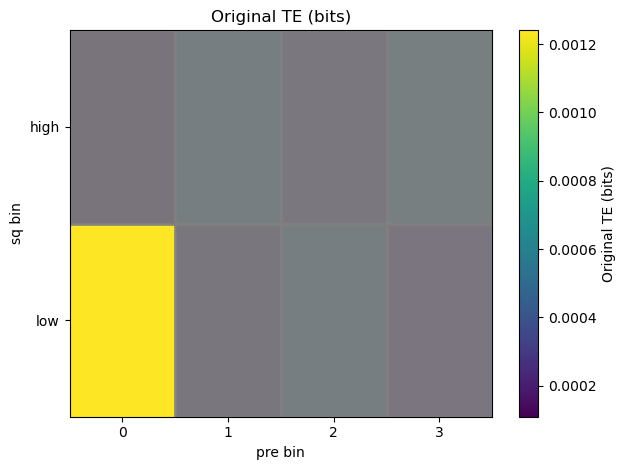

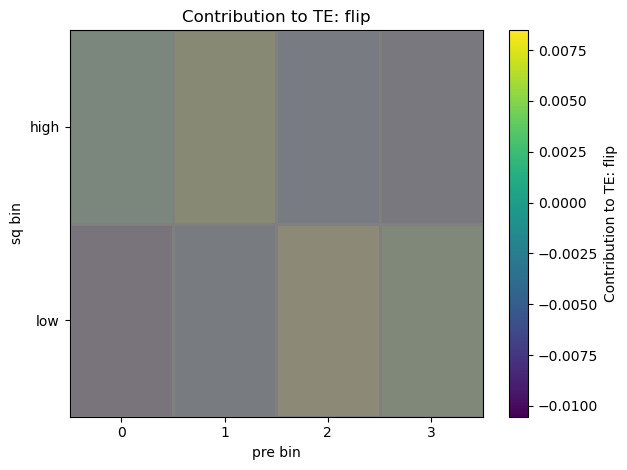

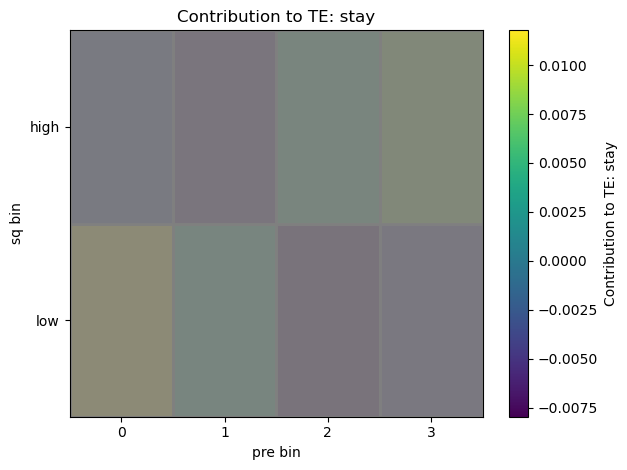

In [262]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyinform import transfer_entropy
from matplotlib.patches import Rectangle


pre = df_pre_i['pre'].values      # source (precession)
sq = df_sq_i['filt_d18O'].values    # target (residual)
sq  = sq[::-1]
pre = pre[::-1]

# Pre: 4 bins
nbins_pre = 4
bins_pre  = np.histogram_bin_edges(pre, bins=nbins_pre)
pre_disc  = np.digitize(pre, bins_pre) - 1      # 0..3

# SQ: 2 bins (0/1)
sq   = (sq > 0).astype(int)               # 0..1






# Setup indices and future state
N = len(pre_disc)
x_idx = pre_disc[:-1]
y_idx = sq[:-1]
z_idx = sq[1:]

# Compute marginal baselines p(z | y)
p_z_given_y = {}
for j in (0,1):
    counts = np.bincount(z_idx[y_idx==j], minlength=2)
    p_z_given_y[j] = counts / counts.sum()

# Compute observed cell statistics
local_te = transfer_entropy(pre_disc, sq, k=1, local=True).flatten()
te = local_te[1:] if len(local_te)==N else local_te
results = []

# Number of surrogates
n_surr = 200

# Loop over cells
for i in range(nbins_pre):
    for j in (0,1):
        mask = (x_idx==i) & (y_idx==j)
        if not mask.any():
            continue
        
        # observed stats
        te_orig = te[mask].mean()
        counts_ij = np.bincount(z_idx[mask], minlength=2)
        p_ij = counts_ij / counts_ij.sum()
        contrib_stay = p_ij[0]*np.log2(p_ij[0]/p_z_given_y[j][0]) if p_ij[0]>0 else 0
        contrib_flip = p_ij[1]*np.log2(p_ij[1]/p_z_given_y[j][1]) if p_ij[1]>0 else 0
        
        # containers for surrogate distributions
        te_surr_vals = np.zeros(n_surr)
        stay_surr_vals = np.zeros(n_surr)
        flip_surr_vals = np.zeros(n_surr)
        
        for k in range(n_surr):
            pre_rand = np.random.permutation(pre_disc)
            local_s = transfer_entropy(pre_rand, sq, k=1, local=True).flatten()
            te_s = local_s[1:] if len(local_s)==N else local_s
            
            # surrogate TE
            te_surr_vals[k] = te_s[mask].mean()
            # surrogate contributions
            counts_s = np.bincount(z_idx[mask], minlength=2)  # z_idx unchanged by shuffling y,z unaffected
            p_sij = counts_s / counts_s.sum()
            stay_surr_vals[k] = p_sij[0]*np.log2(p_sij[0]/p_z_given_y[j][0]) if p_sij[0]>0 else 0
            flip_surr_vals[k] = p_sij[1]*np.log2(p_sij[1]/p_z_given_y[j][1]) if p_sij[1]>0 else 0
        
        # p-values (one-sided upper tail)
        p_te   = (np.sum(te_surr_vals >= te_orig) + 1) / (n_surr + 1)
        p_stay = (np.sum(stay_surr_vals >= contrib_stay) + 1) / (n_surr + 1)
        p_flip = (np.sum(flip_surr_vals >= contrib_flip) + 1) / (n_surr + 1)
        
        results.append({
            'pre_bin': i, 'sq_bin': j,
            'TE_orig': te_orig,   'p_TE': p_te,
            'stay': contrib_stay,  'p_stay': p_stay,
            'flip': contrib_flip,  'p_flip': p_flip
        })

df = pd.DataFrame(results)

# === Visualization Function ===

def plot_with_significance(df, value_col, p_col, title):
    grid = df.pivot(index='sq_bin', columns='pre_bin', values=value_col).values
    pvals= df.pivot(index='sq_bin', columns='pre_bin', values=p_col).values
    
    fig, ax = plt.subplots()
    im = ax.imshow(grid, origin='lower', aspect='auto', extent=[0,4,0,2])
    fig.colorbar(im, ax=ax, label=title)
    ax.set_xlabel('pre bin'); ax.set_ylabel('sq bin')
    ax.set_yticks([0.5,1.5]); ax.set_yticklabels(['low','high'])
    ax.set_xticks(np.arange(0.5,4.5)); ax.set_xticklabels(np.arange(4))
    ax.set_title(title)
    
    # Overlay non-significant cells (p>=0.05) with grey boxes
    for i in range(grid.shape[1]):
        for j in range(grid.shape[0]):
            if pvals[j,i] >= 0.05:
                rect = Rectangle((i, j), 1, 1, color='grey', alpha=0.9, linewidth=2)
                ax.add_patch(rect)
    
    plt.tight_layout()
    plt.show()

# Plot the three heatmaps with significance overlays
plot_with_significance(df, 'TE_orig', 'p_TE',    'Original TE (bits)')
plot_with_significance(df, 'flip',    'p_flip',  'Contribution to TE: flip')
plot_with_significance(df, 'stay',    'p_stay',  'Contribution to TE: stay')


   pre_bin  sq_bin   p(flip)  baseline(flip)  contrib(flip)   p(stay)  \
0        0       0  0.034687        0.042814      -0.010534  0.965313   
1        0       1  0.964594        0.962275       0.003349  0.035406   
2        1       0  0.039235        0.042814      -0.004941  0.960765   
3        1       1  0.967240        0.962275       0.007181  0.032760   
4        2       0  0.048346        0.042814       0.008475  0.951654   
5        2       1  0.958606        0.962275      -0.005283  0.041394   
6        3       0  0.046189        0.042814       0.005056  0.953811   
7        3       1  0.956838        0.962275      -0.007823  0.043162   

   baseline(stay)  contrib(stay)   TE_orig  TE_surr_mean  TE_surr_sd   z_score  
0        0.957186       0.011775  0.001240      0.000184    0.000391  2.698672  
1        0.037725      -0.003240  0.000109      0.000174    0.000418 -0.156397  
2        0.957186       0.005173  0.000232      0.000177    0.000281  0.195092  
3        0.037725 

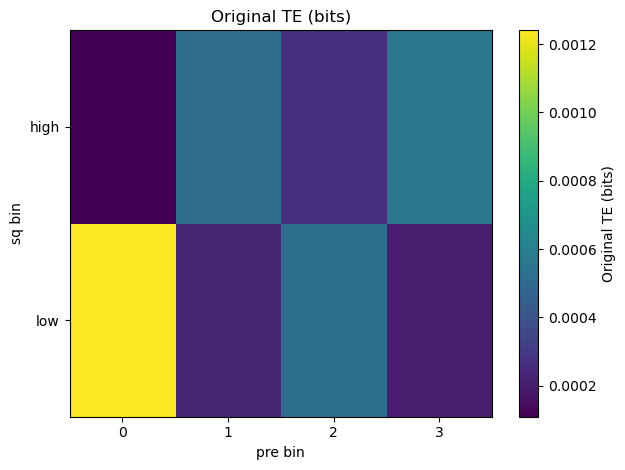

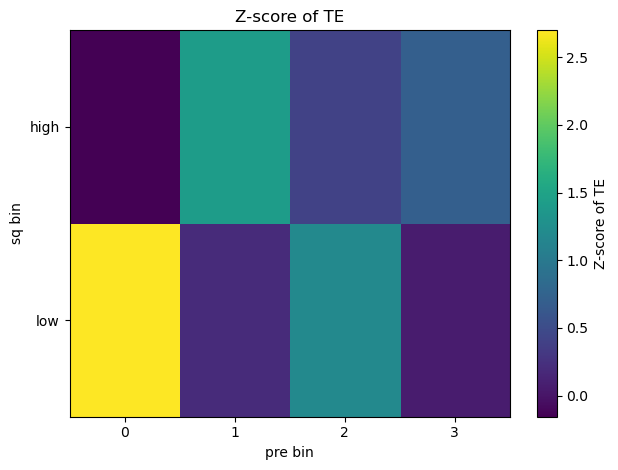

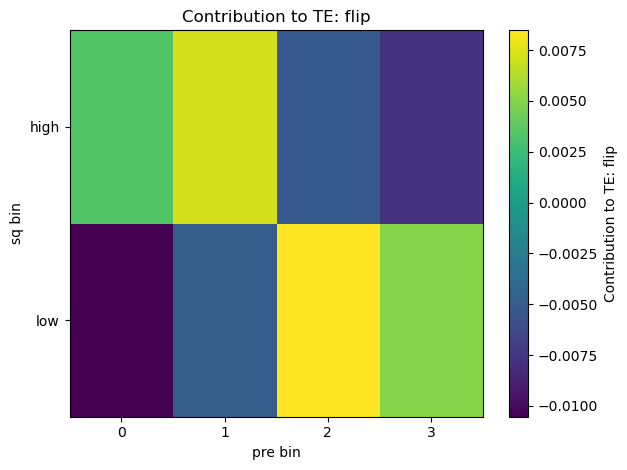

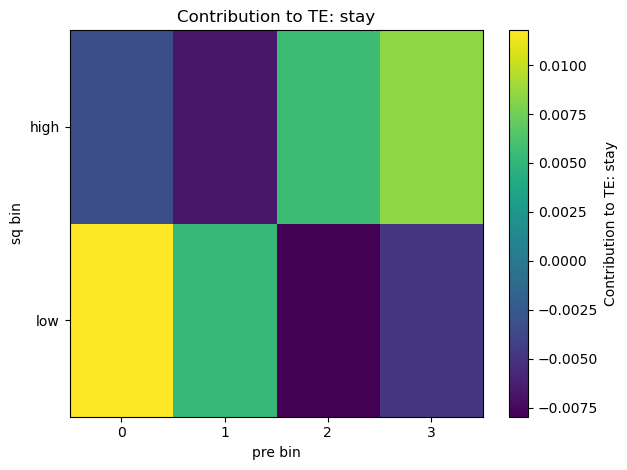

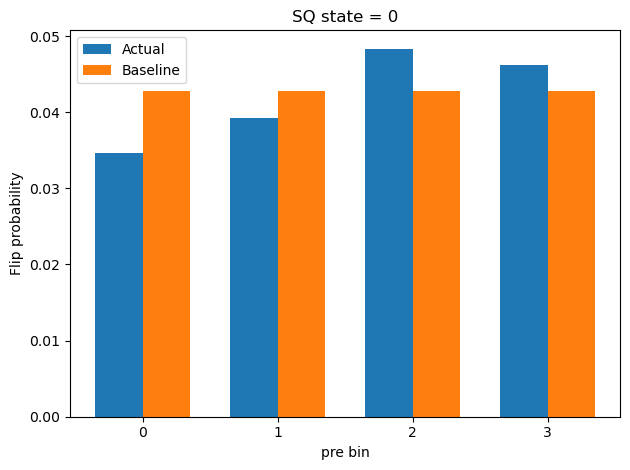

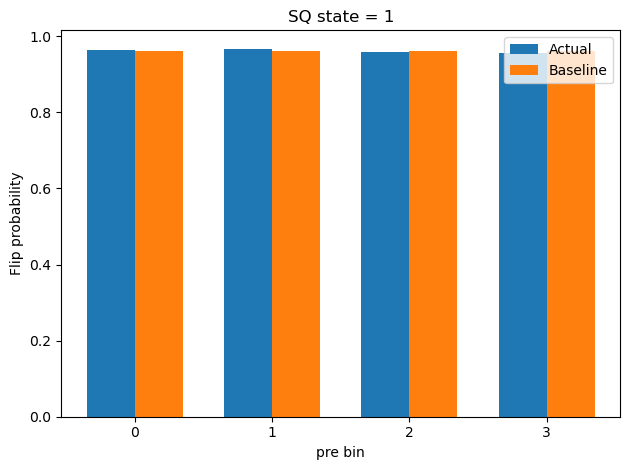

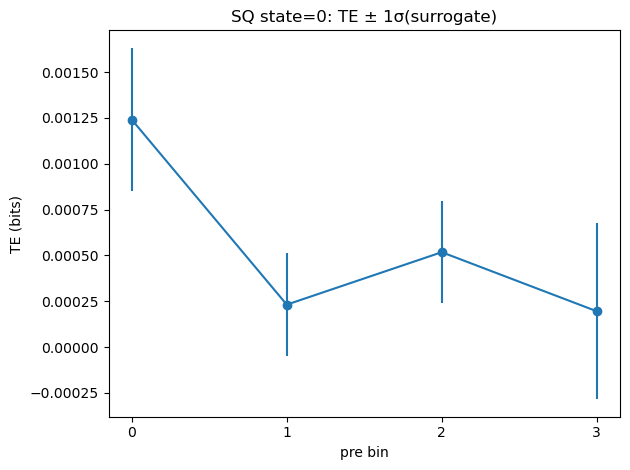

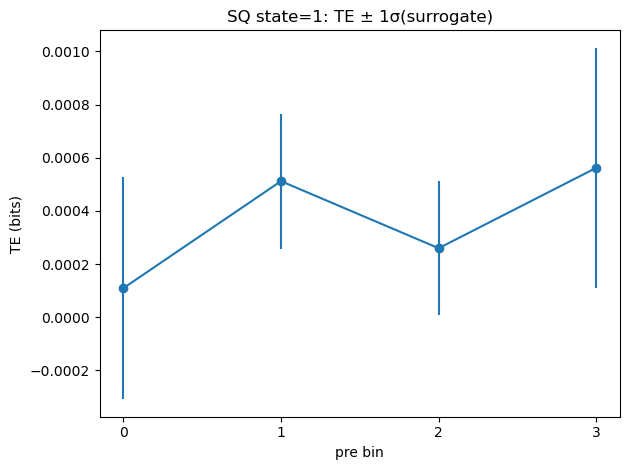

In [254]:
import numpy as np
from pyinform import transfer_entropy

pre = df_pre_i['pre'].values      # source (precession)
sq = df_sq_i['filt_d18O'].values    # target (residual)
sq  = sq[::-1]
pre = pre[::-1]

# Pre: 4 bins
nbins_pre = 4
bins_pre  = np.histogram_bin_edges(pre, bins=nbins_pre)
pre_disc  = np.digitize(pre, bins_pre) - 1      # 0..3

# SQ: 2 bins (0/1)
sq_disc   = (sq > 0).astype(int)               # 0..1

# --- 2) Compute local TE (k=1) ---
local_te = transfer_entropy(pre_disc, sq_disc, k=1, local=True)

# --- 2a) Flatten and auto-align ---
# Get a 1D array
te_arr = local_te.flatten()

# Number of original samples
N = pre_disc.shape[0]

# Past‐state indices each have length N-1
x_idx = pre_disc[:-1]
y_idx = sq_disc[:-1]

nbins_pre = 4
nbins_sq  = 2

# Precompute the marginal baselines p(z | y=j) for j=0,1
p_z_given_y = {}
for j in (0,1):
    mask_y = (y_idx == j)
    counts = np.bincount(z_idx[mask_y], minlength=2)
    p_z_given_y[j] = counts / counts.sum()

# Compute the original TE heatmap once
local_te = transfer_entropy(pre_disc, sq_disc, k=1, local=True).flatten()
te = local_te[1:] if local_te.shape[0]==N else local_te  # align

heatmap = np.full((nbins_pre, nbins_sq), np.nan)
for i in range(nbins_pre):
    for j in (0,1):
        mask = (x_idx==i)&(y_idx==j)
        if mask.any():
            heatmap[i,j] = te[mask].mean()

# Now loop over all cells
n_surr = 200
results = []

for i in range(nbins_pre):
    for j in (0,1):
        mask_ij = (x_idx==i)&(y_idx==j)
        if not mask_ij.any(): 
            continue

        # 1) Empirical p(z|i,j)
        counts_ij = np.bincount(z_idx[mask_ij], minlength=2)
        p_ij = counts_ij / counts_ij.sum()

        # 2) Contributions
        contribs = []
        for z in (0,1):
            pj = p_z_given_y[j][z]
            pij = p_ij[z]
            if pij>0 and pj>0:
                contribs.append(pij * np.log2(pij/pj))
            else:
                contribs.append(0.0)

        # 3) Surrogate TE distribution in this cell
        te_surr = np.zeros(n_surr)
        for k in range(n_surr):
            pre_s = np.random.permutation(pre_disc)
            local_s = transfer_entropy(pre_s, sq_disc, k=1, local=True).flatten()
            te_k  = local_s[1:] if local_s.shape[0]==N else local_s
            te_surr[k] = te_k[mask_ij].mean()

        mu_surr, sd_surr = te_surr.mean(), te_surr.std()
        te_orig = heatmap[i,j]

        results.append({
            'pre_bin': i,
            'sq_bin' : j,
            'p(stay)' : p_ij[0],
            'p(flip)' : p_ij[1],
            'baseline(stay)': p_z_given_y[j][0],
            'baseline(flip)': p_z_given_y[j][1],
            'contrib(stay)': contribs[0],
            'contrib(flip)': contribs[1],
            'TE_orig': te_orig,
            'TE_surr_mean': mu_surr,
            'TE_surr_sd': sd_surr,
            'z_score': (te_orig-mu_surr)/sd_surr
        })

# Print a nice table
import pandas as pd
df = pd.DataFrame(results)
print(df[['pre_bin','sq_bin',
          'p(flip)','baseline(flip)','contrib(flip)',
          'p(stay)','baseline(stay)','contrib(stay)',
          'TE_orig','TE_surr_mean','TE_surr_sd','z_score']])



import matplotlib.pyplot as plt
import numpy as np

# Assume `df` is the DataFrame with your results
# Pivot the data for heatmap plotting
pivot_te = df.pivot(index='sq_bin', columns='pre_bin', values='TE_orig').values
pivot_z = df.pivot(index='sq_bin', columns='pre_bin', values='z_score').values
pivot_flip = df.pivot(index='sq_bin', columns='pre_bin', values='contrib(flip)').values
pivot_stay = df.pivot(index='sq_bin', columns='pre_bin', values='contrib(stay)').values

# A helper to plot a heatmap
def plot_heatmap(data, title, ylabel='sq bin', xlabel='pre bin'):
    plt.figure()
    plt.imshow(data, origin='lower', aspect='auto',
               extent=[0, data.shape[1], 0, data.shape[0]])
    plt.colorbar(label=title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.yticks([0.5, 1.5], ['low', 'high'])
    plt.xticks(np.arange(0.5, data.shape[1] + 0.5), np.arange(data.shape[1]))
    plt.tight_layout()
    plt.show()

# Plot each metric
plot_heatmap(pivot_te,    'Original TE (bits)')
plot_heatmap(pivot_z,     'Z-score of TE')
plot_heatmap(pivot_flip,  'Contribution to TE: flip')
plot_heatmap(pivot_stay,  'Contribution to TE: stay')




import numpy as np

for sq_state in (0,1):
    sub = df[df['sq_bin']==sq_state]
    x = sub['pre_bin']
    w = 0.35
    plt.figure()
    plt.bar(x - w/2, sub['p(flip)'], width=w)
    plt.bar(x + w/2, sub['baseline(flip)'], width=w)
    plt.xlabel('pre bin')
    plt.ylabel('Flip probability')
    plt.title(f'SQ state = {sq_state}')
    plt.legend(['Actual','Baseline'])
    plt.xticks([0,1,2,3])
    plt.tight_layout()
    plt.show()

for sq_state in (0,1):
    sub = df[df['sq_bin']==sq_state]
    plt.figure()
    plt.errorbar(sub['pre_bin'], sub['TE_orig'],
                 yerr=sub['TE_surr_sd'], fmt='o-')
    plt.xlabel('pre bin')
    plt.ylabel('TE (bits)')
    plt.title(f'SQ state={sq_state}: TE ± 1σ(surrogate)')
    plt.xticks([0,1,2,3])
    plt.tight_layout()
    plt.show()


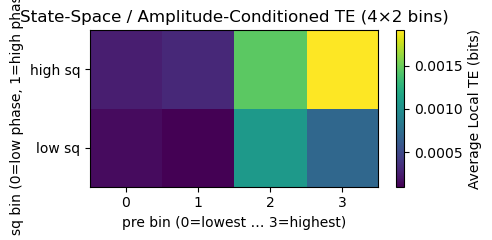

Joint counts (rows = pre_bin 0..3; cols = sq_bin 0..1):
[[3023 3242]
 [3924 4762]
 [3678 4614]
 [4385 4385]]

Marginal counts for pre_bin (0..3):
  pre_bin 0: 6265
  pre_bin 1: 8686
  pre_bin 2: 8292
  pre_bin 3: 8770

Marginal counts for sq_bin (0=low, 1=high):
  sq low (0):  15010
  sq high (1): 17003
Cell (pre=low, sq=low): 3023 samples
   P(sq_next=0 | 0,0) = 0.954
   P(sq_next=1 | 0,0) = 0.046

Cell (pre=high, sq=low): 4385 samples
   P(sq_next=0 | 3,0) = 0.951
   P(sq_next=1 | 3,0) = 0.049
Cell (pre=low, sq=high): 3242 samples
   P(sq_next=0 | 0,1) = 0.041
   P(sq_next=1 | 0,1) = 0.959

Cell (pre=high, sq=high): 4385 samples
   P(sq_next=0 | 3,1) = 0.048
   P(sq_next=1 | 3,1) = 0.952


In [119]:

import numpy as np
import matplotlib.pyplot as plt
from pyinform import transfer_entropy





pre = df_obl_i['obl'].values      # source (precession)
sq = df_sq_i['filt_d18O'].values    # target (residual)
sq  = sq[::-1]
pre = pre[::-1]

# Pre: 4 bins
nbins_pre = 4
bins_pre  = np.histogram_bin_edges(pre, bins=nbins_pre)
pre_disc  = np.digitize(pre, bins_pre) - 1      # 0..3

# SQ: 2 bins (0/1)
sq_disc   = (sq > 0).astype(int)               # 0..1



# --- 2) Compute local TE (k=1) ---
local_te = transfer_entropy(pre_disc, sq_disc, k=1, local=True)

# --- 2a) Flatten and auto-align ---
# Get a 1D array
te_arr = local_te.flatten()

# Number of original samples
N = pre_disc.shape[0]

# Past‐state indices each have length N-1
x_idx = pre_disc[:-1]
y_idx = sq_disc[:-1]

# Decide how to slice te_arr so it lines up with x_idx/y_idx
if te_arr.shape[0] == N:
    # TE[0] corresponds to t=0 → drop it
    te = te_arr[1:]
elif te_arr.shape[0] == N-1:
    # Already aligned
    te = te_arr
else:
    raise ValueError(
        f"Unexpected local_te length: {te_arr.shape[0]} (expected {N} or {N-1})"
    )

# sanity check
assert te.shape[0] == x_idx.shape[0] == y_idx.shape[0], (
    f"Shapes mismatch: te {te.shape}, x_idx {x_idx.shape}, y_idx {y_idx.shape}"
)
# --- 3) Build the heatmap ---
nbins_pre = 4
heatmap = np.full((nbins_pre, 2), np.nan)
for i in range(nbins_pre):
    for j in (0, 1):
        mask = (x_idx == i) & (y_idx == j)
        if mask.any():
            heatmap[i, j] = te[mask].mean()

# --- 4) Plot ---
plt.figure(figsize=(5,2.5))
plt.imshow(heatmap.T, origin='lower', aspect='auto',
           extent=[0, nbins_pre, 0, 2])
plt.colorbar(label='Average Local TE (bits)')
plt.xlabel('pre bin (0=lowest … 3=highest)')
plt.ylabel('sq bin (0=low phase, 1=high phase)')
plt.title('State‐Space / Amplitude‐Conditioned TE (4×2 bins)')
plt.yticks([0.5,1.5], ['low sq','high sq'])
plt.xticks(np.arange(0.5, nbins_pre+0.5), np.arange(nbins_pre))
plt.tight_layout()
plt.show()

nbins_pre = 4
nbins_sq  = 2

# Clip into [0, nbins-1]
x_idx_clipped = np.clip(x_idx, 0, nbins_pre-1)
y_idx_clipped = np.clip(y_idx, 0, nbins_sq -1)

# 1) Joint counts for (pre_bin, sq_bin)
joint_counts = np.zeros((nbins_pre, nbins_sq), dtype=int)
for xi, yi in zip(x_idx_clipped, y_idx_clipped):
    joint_counts[xi, yi] += 1

print("Joint counts (rows = pre_bin 0..3; cols = sq_bin 0..1):")
print(joint_counts)

# 2) Marginal counts for pre alone
pre_counts = np.bincount(x_idx_clipped, minlength=nbins_pre)
print("\nMarginal counts for pre_bin (0..3):")
for i, c in enumerate(pre_counts):
    print(f"  pre_bin {i}: {c}")

# 3) Marginal counts for sq alone
sq_counts = np.bincount(y_idx_clipped, minlength=nbins_sq)
print("\nMarginal counts for sq_bin (0=low, 1=high):")
print(f"  sq low (0):  {sq_counts[0]}")
print(f"  sq high (1): {sq_counts[1]}")



# Clip indices just in case
x_idx_clipped = np.clip(x_idx, 0, nbins_pre-1)
y_idx_clipped = np.clip(y_idx, 0, 1)
z_idx = sq_disc[1:]   # future state of sq, 0 or 1

# Function to compute P(z | x=i, y=j)
def transition_probs(i, j):
    mask = (x_idx_clipped == i) & (y_idx_clipped == j)
    counts = np.bincount(z_idx[mask], minlength=2)
    total = counts.sum()
    return counts / total, total

# Get for the “low-pre & low-sq” cell (i=0, j=0)
probs_00, total_00 = transition_probs(0, 0)
print(f"Cell (pre=low, sq=low): {total_00} samples")
print(f"   P(sq_next=0 | 0,0) = {probs_00[0]:.3f}")
print(f"   P(sq_next=1 | 0,0) = {probs_00[1]:.3f}")

# And for comparison, say “pre=high, sq=low” (i=3, j=0)
probs_30, total_30 = transition_probs(3, 0)
print(f"\nCell (pre=high, sq=low): {total_30} samples")
print(f"   P(sq_next=0 | 3,0) = {probs_30[0]:.3f}")
print(f"   P(sq_next=1 | 3,0) = {probs_30[1]:.3f}")



probs_00, total_00 = transition_probs(0, 1)
print(f"Cell (pre=low, sq=high): {total_00} samples")
print(f"   P(sq_next=0 | 0,1) = {probs_00[0]:.3f}")
print(f"   P(sq_next=1 | 0,1) = {probs_00[1]:.3f}")

# And for comparison, say “pre=high, sq=low” (i=3, j=0)
probs_30, total_30 = transition_probs(3, 1)
print(f"\nCell (pre=high, sq=high): {total_30} samples")
print(f"   P(sq_next=0 | 3,1) = {probs_30[0]:.3f}")
print(f"   P(sq_next=1 | 3,1) = {probs_30[1]:.3f}")

# Testing the effect of temporal uncertainty

In [415]:
import numpy as np
from toolbox import sq_ana as sa
import importlib
importlib.reload(sa)

# how many random trials?
N = 100

# your maximum age error (as ratio)
max_age_error = 10000
max_age_ratio = max_age_error / np.max(df_filt_d18O['age'].values)

# sigma so that ±2σ = ±max_age_ratio
sigma = max_age_ratio / 2.0

# counters
count_pre_sq = 0
count_obl_sq = 0

for _ in range(N):
    # draw a random ratio, truncated to [-max_age_ratio, +max_age_ratio]
    r = np.random.normal(0, sigma)
    r = np.clip(r, -max_age_ratio, max_age_ratio)
    
    # stretch your age axis
    df_sq_stretch = df_filt_d18O.copy()
    df_sq_stretch['age'] = df_sq_stretch['age'].values * (1.0 + r)
    
    # re-interpolate
    df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(
        df_sq_stretch, 20, if_plot=False
    )
    
    pre = df_pre_i['pre'].values
    obl = df_obl_i['obl'].values
    sq  = df_sq_i['filt_d18O'].values
    
    # test pre → sq
    result_pre, _ = sa.transfer_entropy_surrogate_test(
        pre, sq, forcing_bins=6, sq_bins=2, if_plot=False
    )
    if result_pre:
        count_pre_sq += 1
    
    # test obl → sq
    result_obl, _ = sa.transfer_entropy_surrogate_test(
        obl, sq, forcing_bins=6, sq_bins=2, if_plot=False
    )
    if result_obl:
        count_obl_sq += 1

# report
print(f"Out of {N} random age-errors:")
print(f"  pre → sq was significant in {count_pre_sq} runs")
print(f"  obl → sq was significant in {count_obl_sq} runs")


Out of 100 random age-errors:
  pre → sq was significant in 76 runs
  obl → sq was significant in 100 runs


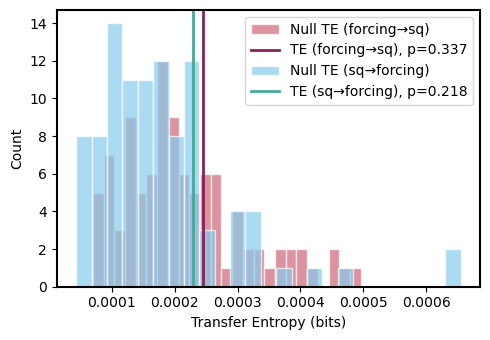

False


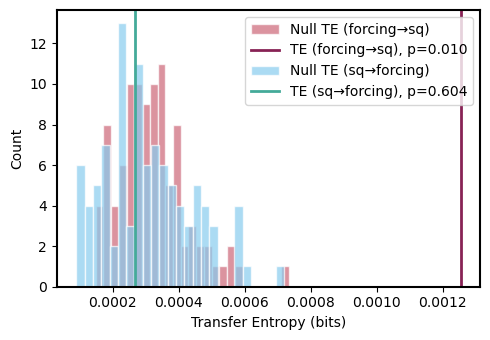

True


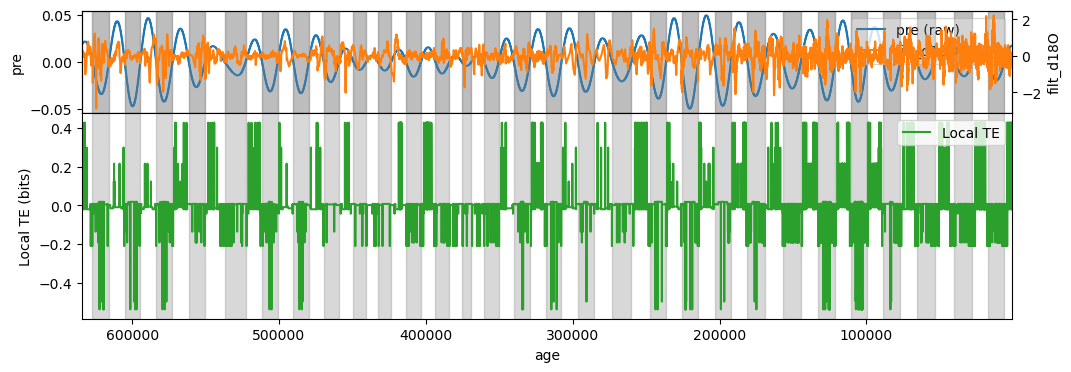

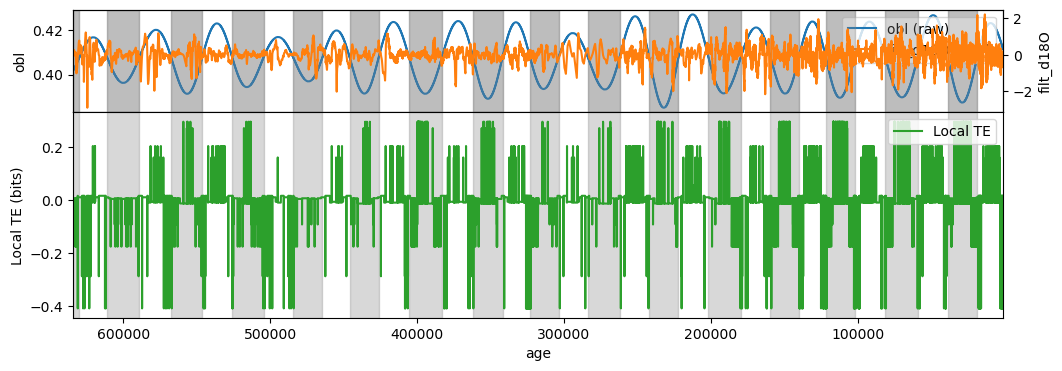

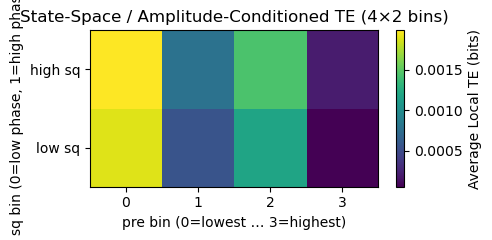

Joint counts (rows = pre_bin 0..3; cols = sq_bin 0..1):
[[2246 2434]
 [5000 6035]
 [5451 5987]
 [2149 2361]]

Marginal counts for pre_bin (0..3):
  pre_bin 0: 4680
  pre_bin 1: 11035
  pre_bin 2: 11438
  pre_bin 3: 4510

Marginal counts for sq_bin (0=low, 1=high):
  sq low (0):  14846
  sq high (1): 16817
Cell (pre=low, sq=low): 2246 samples
   P(sq_next=0 | 0,0) = 0.967
   P(sq_next=1 | 0,0) = 0.033

Cell (pre=high, sq=low): 2149 samples
   P(sq_next=0 | 3,0) = 0.955
   P(sq_next=1 | 3,0) = 0.045
Cell (pre=low, sq=high): 2434 samples
   P(sq_next=0 | 0,1) = 0.028
   P(sq_next=1 | 0,1) = 0.972

Cell (pre=high, sq=high): 2361 samples
   P(sq_next=0 | 3,1) = 0.041
   P(sq_next=1 | 3,1) = 0.959


In [ ]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)



max_age_error =7000
max_age_ratio = max_age_error/np.max(df_filt_d18O['age'].values)

df_sq_stretch = df_filt_d18O.copy()
df_sq_stretch['age'] = df_sq_stretch['age'].values * (1-max_age_ratio)

df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(df_sq_stretch.copy(), 20, if_plot=False)


# pre = df_pre_i['pre'].values      # source (precession)
# sq = df_sq_i['filt_d18O'].values    # target (residual)


# result,fig=sa.transfer_entropy_surrogate_test(pre,sq, forcing_bins=6, sq_bins=2, if_plot=True)







pre = df_pre_i['pre'].values      # source (precession)
obl = df_obl_i['obl'].values    # target (obliquity)
sq = df_sq_i['filt_d18O'].values    # target (residual)


result,fig=sa.transfer_entropy_surrogate_test(pre,sq, forcing_bins=6, sq_bins=2)

# fig.savefig('TE_NGRIP.pdf',format='pdf',bbox_inches='tight')
print(result)
result,fig=sa.transfer_entropy_surrogate_test(obl,sq, forcing_bins=6)
print(result)


LTE = sa.local_TE(df_pre_i.copy(), df_sq_i.copy(),
                   forcing_column='pre',
                   target_column='filt_d18O',
                   time_column='age',
                   nbins_pre=5,
                   nbins_target=2)

LTE = sa.local_TE(df_obl_i.copy(), df_sq_i.copy(),
                   forcing_column='obl',
                   target_column='filt_d18O',
                   time_column='age',
                   nbins_pre=4,
                   nbins_target=2)








import numpy as np
import matplotlib.pyplot as plt
from pyinform import transfer_entropy





pre = df_pre_i['pre'].values      # source (precession)
sq = df_sq_i['filt_d18O'].values    # target (residual)
sq  = sq[::-1]
pre = pre[::-1]

# Pre: 4 bins
nbins_pre = 4
bins_pre  = np.histogram_bin_edges(pre, bins=nbins_pre)
pre_disc  = np.digitize(pre, bins_pre) - 1      # 0..3

# SQ: 2 bins (0/1)
sq_disc   = (sq > 0).astype(int)               # 0..1



# --- 2) Compute local TE (k=1) ---
local_te = transfer_entropy(pre_disc, sq_disc, k=1, local=True)

# --- 2a) Flatten and auto-align ---
# Get a 1D array
te_arr = local_te.flatten()

# Number of original samples
N = pre_disc.shape[0]

# Past‐state indices each have length N-1
x_idx = pre_disc[:-1]
y_idx = sq_disc[:-1]

# Decide how to slice te_arr so it lines up with x_idx/y_idx
if te_arr.shape[0] == N:
    # TE[0] corresponds to t=0 → drop it
    te = te_arr[1:]
elif te_arr.shape[0] == N-1:
    # Already aligned
    te = te_arr
else:
    raise ValueError(
        f"Unexpected local_te length: {te_arr.shape[0]} (expected {N} or {N-1})"
    )

# sanity check
assert te.shape[0] == x_idx.shape[0] == y_idx.shape[0], (
    f"Shapes mismatch: te {te.shape}, x_idx {x_idx.shape}, y_idx {y_idx.shape}"
)
# --- 3) Build the heatmap ---
nbins_pre = 4
heatmap = np.full((nbins_pre, 2), np.nan)
for i in range(nbins_pre):
    for j in (0, 1):
        mask = (x_idx == i) & (y_idx == j)
        if mask.any():
            heatmap[i, j] = te[mask].mean()

# --- 4) Plot ---
plt.figure(figsize=(5,2.5))
plt.imshow(heatmap.T, origin='lower', aspect='auto',
           extent=[0, nbins_pre, 0, 2])
plt.colorbar(label='Average Local TE (bits)')
plt.xlabel('pre bin (0=lowest … 3=highest)')
plt.ylabel('sq bin (0=low phase, 1=high phase)')
plt.title('State‐Space / Amplitude‐Conditioned TE (4×2 bins)')
plt.yticks([0.5,1.5], ['low sq','high sq'])
plt.xticks(np.arange(0.5, nbins_pre+0.5), np.arange(nbins_pre))
plt.tight_layout()
plt.show()

nbins_pre = 4
nbins_sq  = 2

# Clip into [0, nbins-1]
x_idx_clipped = np.clip(x_idx, 0, nbins_pre-1)
y_idx_clipped = np.clip(y_idx, 0, nbins_sq -1)

# 1) Joint counts for (pre_bin, sq_bin)
joint_counts = np.zeros((nbins_pre, nbins_sq), dtype=int)
for xi, yi in zip(x_idx_clipped, y_idx_clipped):
    joint_counts[xi, yi] += 1

print("Joint counts (rows = pre_bin 0..3; cols = sq_bin 0..1):")
print(joint_counts)

# 2) Marginal counts for pre alone
pre_counts = np.bincount(x_idx_clipped, minlength=nbins_pre)
print("\nMarginal counts for pre_bin (0..3):")
for i, c in enumerate(pre_counts):
    print(f"  pre_bin {i}: {c}")

# 3) Marginal counts for sq alone
sq_counts = np.bincount(y_idx_clipped, minlength=nbins_sq)
print("\nMarginal counts for sq_bin (0=low, 1=high):")
print(f"  sq low (0):  {sq_counts[0]}")
print(f"  sq high (1): {sq_counts[1]}")



# Clip indices just in case
x_idx_clipped = np.clip(x_idx, 0, nbins_pre-1)
y_idx_clipped = np.clip(y_idx, 0, 1)
z_idx = sq_disc[1:]   # future state of sq, 0 or 1

# Function to compute P(z | x=i, y=j)
def transition_probs(i, j):
    mask = (x_idx_clipped == i) & (y_idx_clipped == j)
    counts = np.bincount(z_idx[mask], minlength=2)
    total = counts.sum()
    return counts / total, total

# Get for the “low-pre & low-sq” cell (i=0, j=0)
probs_00, total_00 = transition_probs(0, 0)
print(f"Cell (pre=low, sq=low): {total_00} samples")
print(f"   P(sq_next=0 | 0,0) = {probs_00[0]:.3f}")
print(f"   P(sq_next=1 | 0,0) = {probs_00[1]:.3f}")

# And for comparison, say “pre=high, sq=low” (i=3, j=0)
probs_30, total_30 = transition_probs(3, 0)
print(f"\nCell (pre=high, sq=low): {total_30} samples")
print(f"   P(sq_next=0 | 3,0) = {probs_30[0]:.3f}")
print(f"   P(sq_next=1 | 3,0) = {probs_30[1]:.3f}")



probs_00, total_00 = transition_probs(0, 1)
print(f"Cell (pre=low, sq=high): {total_00} samples")
print(f"   P(sq_next=0 | 0,1) = {probs_00[0]:.3f}")
print(f"   P(sq_next=1 | 0,1) = {probs_00[1]:.3f}")

# And for comparison, say “pre=high, sq=low” (i=3, j=0)
probs_30, total_30 = transition_probs(3, 1)
print(f"\nCell (pre=high, sq=high): {total_30} samples")
print(f"   P(sq_next=0 | 3,1) = {probs_30[0]:.3f}")
print(f"   P(sq_next=1 | 3,1) = {probs_30[1]:.3f}")

In [126]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Re-generate synthetic data
np.random.seed(42)
N = 100
t = np.arange(N)
pre = np.sin(2 * np.pi * t / 20)
sq = np.zeros(N, dtype=int)
for i in range(1, N):
    p = 0.8 if pre[i-1] > 0 else 0.2
    sq[i] = 1 if np.random.rand() < p else 0

# Discretize
pre_bins = np.linspace(pre.min(), pre.max(), 5)
sq_bins = np.linspace(sq.min(), sq.max(), 3)
pre_d = np.digitize(pre, pre_bins) - 1
sq_d = np.digitize(sq, sq_bins) - 1

# Calculate probabilities for TE
counts_xyz, counts_xy, counts_zy, counts_z = {}, {}, {}, {}
for i in range(1, N):
    x_t, x_tm1, y_tm1 = sq_d[i], sq_d[i-1], pre_d[i-1]
    counts_xyz[(x_t, x_tm1, y_tm1)] = counts_xyz.get((x_t, x_tm1, y_tm1), 0) + 1
    counts_xy[(x_t, x_tm1)]        = counts_xy.get((x_t, x_tm1), 0) + 1
    counts_zy[(x_tm1, y_tm1)]      = counts_zy.get((x_tm1, y_tm1), 0) + 1
    counts_z[x_tm1]                = counts_z.get(x_tm1, 0) + 1

num_list, den_list, te_list = [], [], []
for i in range(1, N):
    x_t, x_tm1, y_tm1 = sq_d[i], sq_d[i-1], pre_d[i-1]
    num = counts_xyz[(x_t, x_tm1, y_tm1)] / counts_zy[(x_tm1, y_tm1)]
    den = counts_xy[(x_t, x_tm1)] / counts_z[x_tm1]
    te  = np.log2(num / den)
    num_list.append(num)
    den_list.append(den)
    te_list.append(te)

# Create subplot figure
fig = make_subplots(
    rows=2, cols=1, shared_xaxes=True,
    row_heights=[0.4, 0.6],
    subplot_titles=("pre & sq", "Local TE")
)

# Upper panel: pre and sq as line+circle markers
fig.add_trace(go.Scatter(
    x=t, y=pre, mode='lines', name='pre'
), row=1, col=1)
fig.add_trace(go.Scatter(
    x=t, y=sq, mode='lines+markers', marker_symbol='circle', name='sq'
), row=1, col=1)

# Add horizontal lines at bin boundaries for pre
for y in pre_bins:
    fig.add_hline(
        y=y, row=1, col=1,
        line=dict(dash='dash'), opacity=0.5,
        annotation_text=f"{y:.2f}", annotation_position="right"
    )

# Lower panel: TE line and initial marker
fig.add_trace(go.Scatter(
    x=t, y=[None] + te_list, mode='lines', name='Local TE'
), row=2, col=1)
fig.add_trace(go.Scatter(
    x=[t[1]], y=[te_list[0]], mode='markers+text',
    text=[f"Num={num_list[0]:.2f}<br>Den={den_list[0]:.2f}<br>TE={te_list[0]:.2f}"],
    textposition="top center",
    name='Current TE'
), row=2, col=1)

# Frames: updating only the 'Current TE' trace (trace index 3)
frames = []
for idx in range(1, N):
    frames.append(go.Frame(
        data=[go.Scatter(
            x=[t[idx]],
            y=[te_list[idx-1]],
            text=[f"Num={num_list[idx-1]:.2f}<br>Den={den_list[idx-1]:.2f}<br>TE={te_list[idx-1]:.2f}"]
        )],
        traces=[3],
        name=str(idx)
    ))

# Slider steps
steps = [
    {
        "method": "animate", "label": str(idx),
        "args": [[str(idx)], {"mode": "immediate", "frame": {"duration": 0, "redraw": True}}]
    }
    for idx in range(1, N)
]

# Update layout
fig.update_layout(
    sliders=[dict(active=0, currentvalue={"visible": False}, pad={"t": 50}, steps=steps)],
    height=600, width=800, showlegend=False,
    xaxis2=dict(title="Time (t)"),
    yaxis1=dict(title="Value"),
    yaxis2=dict(title="TE (bits)"),
    title_text="Local TE with Bin Boundaries and Improved Slider",
    uirevision='constant'
)

fig.frames = frames
fig.show()


In [124]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Re-generate synthetic data
np.random.seed(42)
N = 100
t = np.arange(N)
pre = np.sin(2 * np.pi * t / 20)
sq = np.zeros(N, dtype=int)
for i in range(1, N):
    p = 0.8 if pre[i-1] > 0 else 0.2
    sq[i] = 1 if np.random.rand() < p else 0

# Discretize
pre_bins = np.linspace(pre.min(), pre.max(), 5)
sq_bins = np.linspace(sq.min(), sq.max(), 3)
pre_d = np.digitize(pre, pre_bins) - 1
sq_d = np.digitize(sq, sq_bins) - 1

# Calculate probabilities for TE
counts_xyz, counts_xy, counts_zy, counts_z = {}, {}, {}, {}
for i in range(1, N):
    x_t, x_tm1, y_tm1 = sq_d[i], sq_d[i-1], pre_d[i-1]
    counts_xyz[(x_t, x_tm1, y_tm1)] = counts_xyz.get((x_t, x_tm1, y_tm1), 0) + 1
    counts_xy[(x_t, x_tm1)]        = counts_xy.get((x_t, x_tm1), 0) + 1
    counts_zy[(x_tm1, y_tm1)]      = counts_zy.get((x_tm1, y_tm1), 0) + 1
    counts_z[x_tm1]                = counts_z.get(x_tm1, 0) + 1

num_list, den_list, te_list = [], [], []
for i in range(1, N):
    x_t, x_tm1, y_tm1 = sq_d[i], sq_d[i-1], pre_d[i-1]
    num = counts_xyz[(x_t, x_tm1, y_tm1)] / counts_zy[(x_tm1, y_tm1)]
    den = counts_xy[(x_t, x_tm1)] / counts_z[x_tm1]
    te  = np.log2(num / den)
    num_list.append(num)
    den_list.append(den)
    te_list.append(te)

# Create subplot figure
fig = go.Figure(make_subplots(
    rows=2, cols=1, shared_xaxes=True,
    row_heights=[0.4, 0.6],
    subplot_titles=("pre & sq", "Local TE")
))

# Upper panel
fig.add_trace(go.Scatter(x=t, y=pre, mode='lines', name='pre'), row=1, col=1)
fig.add_trace(go.Scatter(x=t, y=sq, mode='markers', name='sq', marker_symbol='square'), row=1, col=1)

# Lower panel: TE line and initial marker
fig.add_trace(go.Scatter(x=t, y=[None] + te_list, mode='lines', name='Local TE'), row=2, col=1)
fig.add_trace(go.Scatter(
    x=[t[1]], 
    y=[te_list[0]], 
    mode='markers+text',
    text=[f"Num={num_list[0]:.2f}<br>Den={den_list[0]:.2f}<br>TE={te_list[0]:.2f}"],
    textposition="top center",
    name='Current TE'
), row=2, col=1)

# Frames: updating only the 'Current TE' trace (trace index 3)
frames = []
for idx in range(1, N):
    frames.append(go.Frame(
        data=[go.Scatter(
            x=[t[idx]], 
            y=[te_list[idx-1]], 
            text=[f"Num={num_list[idx-1]:.2f}<br>Den={den_list[idx-1]:.2f}<br>TE={te_list[idx-1]:.2f}"]
        )],
        traces=[3],  # target the 4th trace (Current TE)
        name=str(idx)
    ))

# Slider steps
steps = [
    {"method": "animate", "label": str(idx),
     "args": [[str(idx)], {"mode": "immediate", "frame": {"duration": 0, "redraw": True}}]}
    for idx in range(1, N)
]

fig.update_layout(
    sliders=[dict(active=0, currentvalue={"visible": False}, pad={"t": 50}, steps=steps)],
    height=600, width=800, showlegend=False,
    xaxis2=dict(title="Time (t)"),
    yaxis1=dict(title="Value"),
    yaxis2=dict(title="TE (bits)"),
    title_text="Local TE with Corrected Slider Behavior"
)

fig.frames = frames
fig.show()


In [121]:
import numpy as np
import plotly.graph_objects as go

# Set seed for reproducibility
np.random.seed(42)

# Generate example data
N = 100
t = np.arange(N)
pre = np.sin(2 * np.pi * t / 20)  # Period of 20
sq = np.zeros(N, dtype=int)
for i in range(1, N):
    p = 0.8 if pre[i-1] > 0 else 0.2
    sq[i] = 1 if np.random.rand() < p else 0

# Discretize signals
pre_bins = np.linspace(pre.min(), pre.max(), 5)  # 4 bins
sq_bins = np.linspace(sq.min(), sq.max(), 3)     # 2 bins
pre_d = np.digitize(pre, pre_bins) - 1
sq_d = np.digitize(sq, sq_bins) - 1

# Compute counts for probabilities
counts_xyz = {}  # counts of (x_t, x_{t-1}, y_{t-1})
counts_xy  = {}  # counts of (x_t, x_{t-1})
counts_zy  = {}  # counts of (x_{t-1}, y_{t-1})
counts_z   = {}  # counts of (x_{t-1})

for i in range(1, N):
    x_t    = sq_d[i]
    x_tm1  = sq_d[i-1]
    y_tm1  = pre_d[i-1]
    
    counts_xyz[(x_t, x_tm1, y_tm1)] = counts_xyz.get((x_t, x_tm1, y_tm1), 0) + 1
    counts_xy[(x_t, x_tm1)]        = counts_xy.get((x_t, x_tm1), 0) + 1
    counts_zy[(x_tm1, y_tm1)]      = counts_zy.get((x_tm1, y_tm1), 0) + 1
    counts_z[x_tm1]                = counts_z.get(x_tm1, 0) + 1

# Calculate local Transfer Entropy components
num_list = []
den_list = []
te_list  = []

for i in range(1, N):
    x_t   = sq_d[i]
    x_tm1 = sq_d[i-1]
    y_tm1 = pre_d[i-1]
    
    # Numerator: P(x_t | x_{t-1}, y_{t-1})
    num = counts_xyz[(x_t, x_tm1, y_tm1)] / counts_zy[(x_tm1, y_tm1)]
    # Denominator: P(x_t | x_{t-1})
    den = counts_xy[(x_t, x_tm1)] / counts_z[x_tm1]
    # Local TE (log base 2)
    te  = np.log2(num / den)
    
    num_list.append(num)
    den_list.append(den)
    te_list.append(te)

# Create Plotly animation frames
frames = []
for idx in range(1, N):
    frames.append(go.Frame(
        data=[
            go.Scatter(x=t, y=[None] + te_list, mode='lines', name='Local TE'),
            go.Scatter(x=[idx], y=[te_list[idx-1]], mode='markers', name='Point')
        ],
        layout=go.Layout(
            annotations=[
                go.layout.Annotation(
                    x=idx, y=te_list[idx-1],
                    text=f"t={idx}<br>Numerator={num_list[idx-1]:.2f}<br>Denominator={den_list[idx-1]:.2f}<br>TE={te_list[idx-1]:.2f}",
                    showarrow=True, arrowhead=2
                )
            ]
        ),
        name=str(idx)
    ))

# Initial figure
fig = go.Figure(
    data=[
        go.Scatter(x=t, y=[None] + te_list, mode='lines', name='Local TE'),
        go.Scatter(x=[1], y=[te_list[0]], mode='markers', name='Point')
    ],
    layout=go.Layout(
        title="Local Transfer Entropy from pre → sq",
        xaxis_title="Time (t)",
        yaxis_title="Local TE (bits)",
        updatemenus=[dict(
            type="buttons",
            buttons=[dict(label="Play",
                          method="animate",
                          args=[None, {"frame": {"duration": 200, "redraw": True},
                                       "fromcurrent": True}])]
        )]
    ),
    frames=frames
)

fig.show()


In [81]:
x_idx.shape

(32013,)

In [82]:
te.shape

(32012,)

In [83]:
y_idx.shape

(32013,)

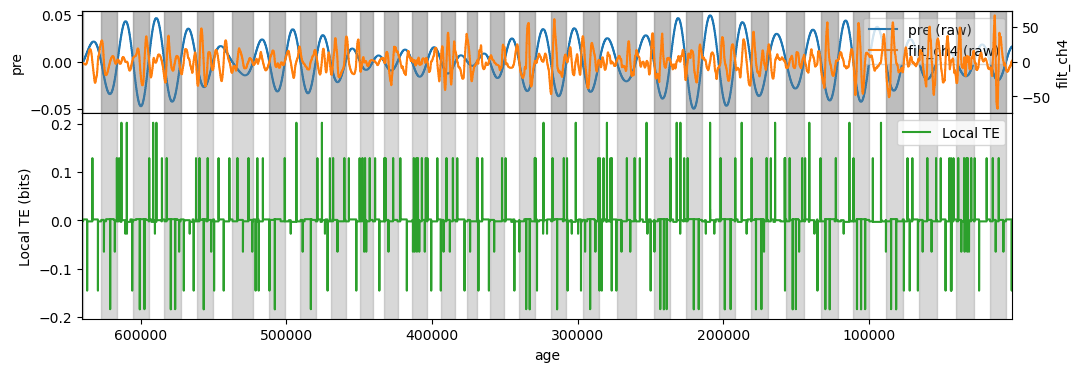

In [152]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

# smooth the filt_ch4 with a window of 100 pt
# df_sq_i['filt_ch4'] = df_sq_i['filt_ch4'].rolling(window=100).mean()

# df_sq_i['filt_ch4']=df_sq_i['filt_ch4']*-1
LTE = sa.local_TE(df_pre_i.copy(), df_sq_i.copy(),
                   forcing_column='pre',
                   target_column='filt_ch4',
                   time_column='age',
                   nbins_pre=4,
                   nbins_target=4)

In [ ]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(df_filt_ch4.copy(), 20, if_plot=False)


pre = df_pre_i['pre'].values      # source (precession)
obl = df_obl_i['obl'].values    # target (obliquity)
sq = df_sq_i['fit_ch4'].values    # target (residual)


result,fig=sa.transfer_entropy_surrogate_test(pre,sq, forcing_bins=4, sq_bins=4)
print(result)


# df_sq_i['filt_ch4']=df_sq_i['filt_ch4']*-1
LTE = sa.local_TE(df_pre_i.copy(), df_sq_i.copy(),
                   forcing_column='pre',
                   target_column='fit_ch4',
                   time_column='age',
                   nbins_pre=4,
                   nbins_target=2)

KeyError: 'fit_ch4'

In [61]:
# check if there is nan in df_sq_i
print(df_sq_i.isna().sum())
# chec k if there is nan in df_pre_i
print(df_pre_i.isna().sum())


age         0
filt_ch4    0
dtype: int64
age    0
pre    0
dtype: int64


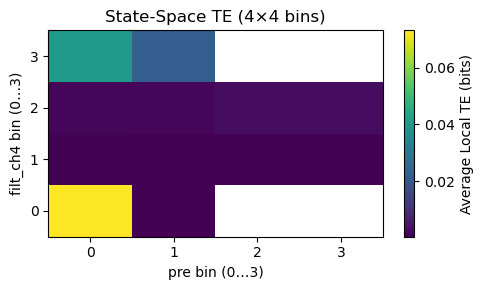

Joint counts (rows=pre_bin, cols=sq_bin):
[[   5 2772 1814   89]
 [  69 6578 4378  101]
 [   0 6964 4733    0]
 [   0 2647 1863    0]]

Marginal counts for pre_bins:
  pre_bin 0: 4680
  pre_bin 1: 11126
  pre_bin 2: 11697
  pre_bin 3: 4510

Marginal counts for sq_bins:
  sq low (0): 74
  sq high (1): 18961
  sq high (2): 12788
  sq high (3): 190

Cell (pre=low, sq=low): 5 samples
  P(sq_next=0)=0.800, P(sq_next=1)=0.200

Cell (pre=high, sq=low): 0 samples
  P(sq_next=0)=0.000, P(sq_next=1)=0.000


In [66]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

results = sa.analyze_state_space_TE(
    df_pre_i,
    df_sq_i,
    forcing_column='pre',
    target_column='filt_ch4',
    nbins_pre=4,
    nbins_sq=4
)

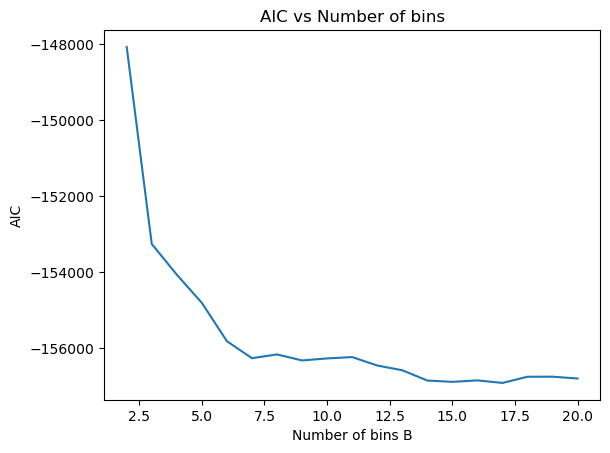

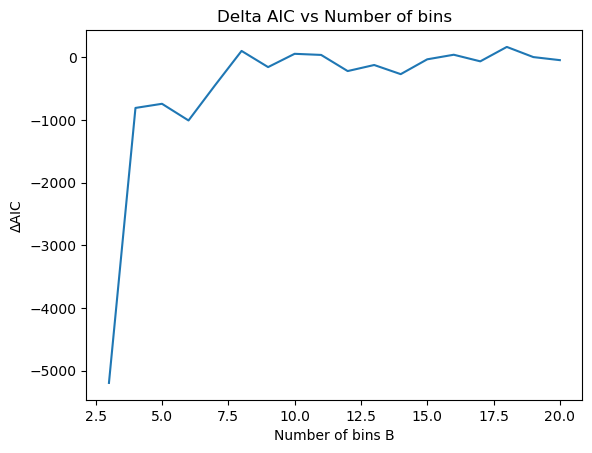

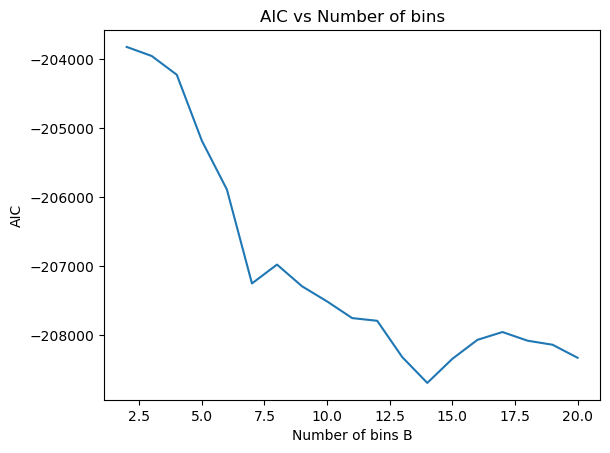

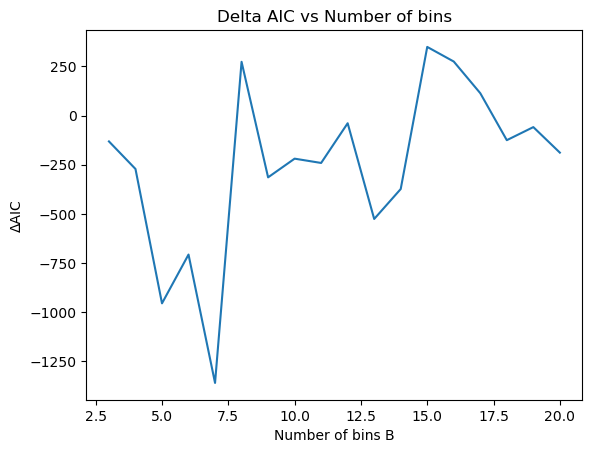

In [45]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

sa.plot_aic_delta(df_pre_i['pre'].values)
sa.plot_aic_delta(df_obl_i['obl'].values)

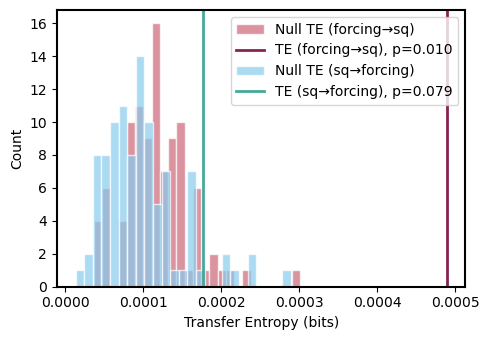

True


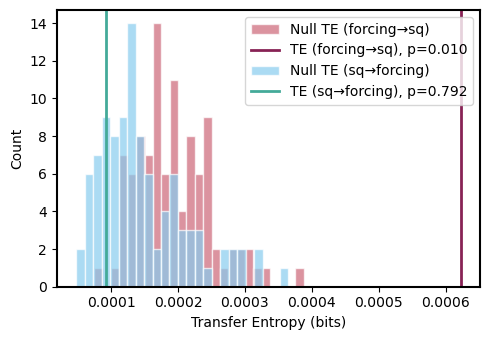

True


In [140]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(df_filt_d18O.copy(), 10, if_plot=False)


pre = df_pre_i['pre'].values      # source (precession)
obl = df_obl_i['obl'].values    # target (obliquity)
sq = df_sq_i['filt_d18O'].values    # target (residual)


result,fig=sa.transfer_entropy_surrogate_test(pre,sq, forcing_bins=4)

# fig.savefig('TE_NGRIP.pdf',format='pdf',bbox_inches='tight')

print(result)
result,fig=sa.transfer_entropy_surrogate_test(obl,sq, forcing_bins=6)
print(result)

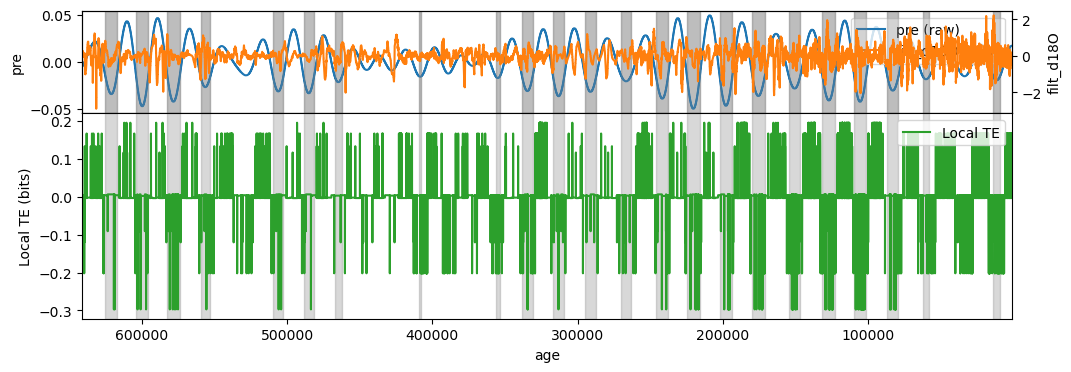

In [143]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

LTE = sa.local_TE(df_pre_i, df_sq_i,
                   forcing_column='pre',
                   target_column='filt_d18O',
                   time_column='age',
                   nbins_pre=4,
                   nbins_target=2)

641264.4
-16.501


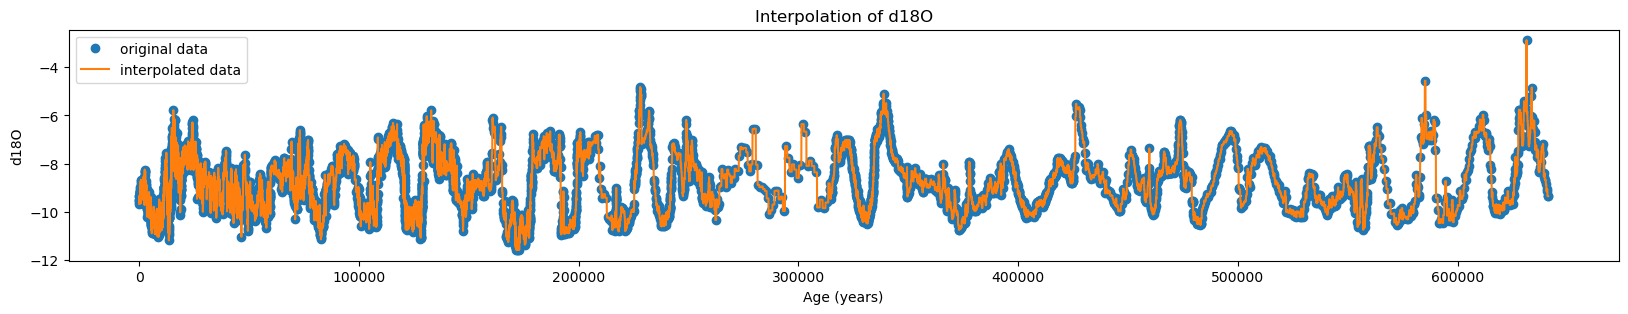

In [1]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

file_path = r"D:\VScode\bipolar_seesaw_CCM\other_data\monsoon.xlsx"
df = pd.read_excel(file_path)
df['age'] = df['age'] * 1000
print(np.max(df['age']))
print(np.min(df['age']))

col = df.columns[1] 

df = df[['age', col]].sort_values('age').reset_index(drop=True)



new_age = np.arange(0, 641260, 20)



f_interp = interp1d(df['age'], df[col],
                    kind='nearest',
                    bounds_error=False,
                    fill_value=1)
new_df = pd.DataFrame({'age': new_age,
                        col: f_interp(new_age)})

# plot df and new_df
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 3))
plt.plot(df['age'], df[col], 'o', label='original data')
plt.plot(new_df['age'], new_df[col], '-', label='interpolated data')
plt.xlabel('Age (years)')
plt.ylabel(col)
plt.title('Interpolation of ' + col)
plt.legend()
plt.show()

In [2]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt

def remove_orbital_component(df, col_name='d18O', cutoff=1/20000, order=4):
    """
    High-pass filter the specified column of a DataFrame to remove frequencies 
    below `cutoff` (yr⁻¹) and return a new DataFrame with 'age' and '{col_name}_hp'.

    Parameters
    ----------
    df : pandas.DataFrame
        Must have columns 'age' (evenly spaced in years) and `col_name`.
    col_name : str
        Name of the column to filter (default 'd18O').
    cutoff : float
        Cutoff frequency in yr⁻¹ (default 1/20000).
    order : int
        Order of the Butterworth filter (default 4).

    Returns
    -------
    pandas.DataFrame
        Two columns:
        - 'age' : same as input
        - '{col_name}_hp' : the high-pass filtered series
    """
    if 'age' not in df.columns or col_name not in df.columns:
        raise ValueError(f"DataFrame must contain 'age' and '{col_name}' columns.")

    age = df['age'].to_numpy()
    signal = df[col_name].to_numpy()

    # Ensure uniform sampling
    dt = np.diff(age)
    if not np.allclose(dt, dt[0]):
        raise ValueError("Age steps must be uniform to define a constant sampling rate.")
    fs = 1.0 / dt[0]         # samples per year
    nyq = fs / 2.0           # Nyquist frequency
    wn = cutoff / nyq        # normalized cutoff

    if wn <= 0 or wn >= 1:
        raise ValueError(f"Normalized cutoff wn={wn:.3e} invalid; check your cutoff and sampling rate.")

    # Design & apply zero-phase high-pass Butterworth
    b, a = butter(order, wn, btype='high', analog=False)
    filtered = filtfilt(b, a, signal)

    # Build output DataFrame with dynamic column name
    return pd.DataFrame({
        'age': age,
        f'{col_name}_hp': filtered
    })


import numpy as np
import pandas as pd

def threshold_to_noise(df, 
                       col='d18O', 
                       lower_pct=5, 
                       upper_pct=95, 
                       noise_mean=0,
                       sigma=0.5):
    """
    Replace values of df[col] below the lower_pct‐percentile or 
    above the upper_pct‐percentile with white noise.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame with at least the column `col`.
    col : str
        Name of the column to threshold.
    lower_pct : float
        Lower percentile cutoff (0–100).
    upper_pct : float
        Upper percentile cutoff (0–100).
    noise_mean : float
        Mean of the white‐noise distribution (default = 0).
    
    Returns
    -------
    df_out : pandas.DataFrame
        A copy of df where outliers in `col` are replaced by noise.
    lower_bound, upper_bound : float, float
        The thresholds actually used.
    """
    df_out = df.copy()
    series = df_out[col]
    
    # compute percentile thresholds
    lower_bound = np.percentile(series, lower_pct)
    upper_bound = np.percentile(series, upper_pct)
    
    # compute noise parameters
    # sigma = series.std()
    
    # mask of outliers
    mask = (series < lower_bound) | (series > upper_bound)
    n_outliers = mask.sum()
    
    # generate white noise for those positions
    noise = np.random.normal(loc=noise_mean, scale=sigma, size=n_outliers)
    
    # replace
    df_out.loc[mask, col] = noise
    
    print(f"Replaced {n_outliers} values <{lower_bound:.3f} or >{upper_bound:.3f} with N({noise_mean},{sigma:.3f}²) noise")
    return df_out, lower_bound, upper_bound


import numpy as np
import pandas as pd
from scipy.signal import find_peaks, lombscargle
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

def plot_envelopes_and_psd(df):
    """
    For a DataFrame with two columns (age and signal), this function:
      1. Calculates upper and lower envelopes via peak/trough interpolation.
      2. Plots the original signal with its envelopes.
      3. Computes the Lomb-Scargle periodogram of both envelopes.
      4. Plots the PSD (log-log) of upper and lower envelopes.
    """
    # extract age and signal
    age = df.iloc[:, 0].values
    signal = df.iloc[:, 1].values

    # find local maxima (peaks) and minima (troughs)
    peaks, _ = find_peaks(signal)
    troughs, _ = find_peaks(-signal)

    # interpolate to get continuous envelopes
    up_env = interp1d(age[peaks], signal[peaks], kind='cubic',
                      bounds_error=False, fill_value='extrapolate')(age)
    lo_env = interp1d(age[troughs], signal[troughs], kind='cubic',
                      bounds_error=False, fill_value='extrapolate')(age)

    # 1) Plot original signal with envelopes
    plt.figure()
    plt.plot(age, signal, label='Original')
    plt.plot(age, up_env, label='Upper envelope')
    plt.plot(age, lo_env, label='Lower envelope')
    plt.xlabel('Age (yr)')
    plt.ylabel('Signal')
    plt.legend()
    plt.title('Signal with Upper and Lower Envelopes')
    plt.show()

    # 2) Compute Lomb-Scargle PSD for envelopes
    # define frequency array: from low freq ~1e-4 to Nyquist = 1/(2*dt)
    dt = np.mean(np.diff(age))
    nyquist = 1/(2*dt)
    freqs = np.linspace(1e-4, nyquist, 1000)
    ang_freqs = 2 * np.pi * freqs

    p_up = lombscargle(age, up_env, ang_freqs)
    p_lo = lombscargle(age, lo_env, ang_freqs)

    # 3) Plot PSD on log-log scale
    plt.figure()
    plt.loglog(freqs, p_up, label='Upper envelope PSD')
    plt.loglog(freqs, p_lo, label='Lower envelope PSD')
    plt.xlabel('Frequency (1/yr)')
    plt.ylabel('Lomb-Scargle Power')
    plt.legend()
    plt.title('Lomb-Scargle PSD of Envelopes')
    plt.show()




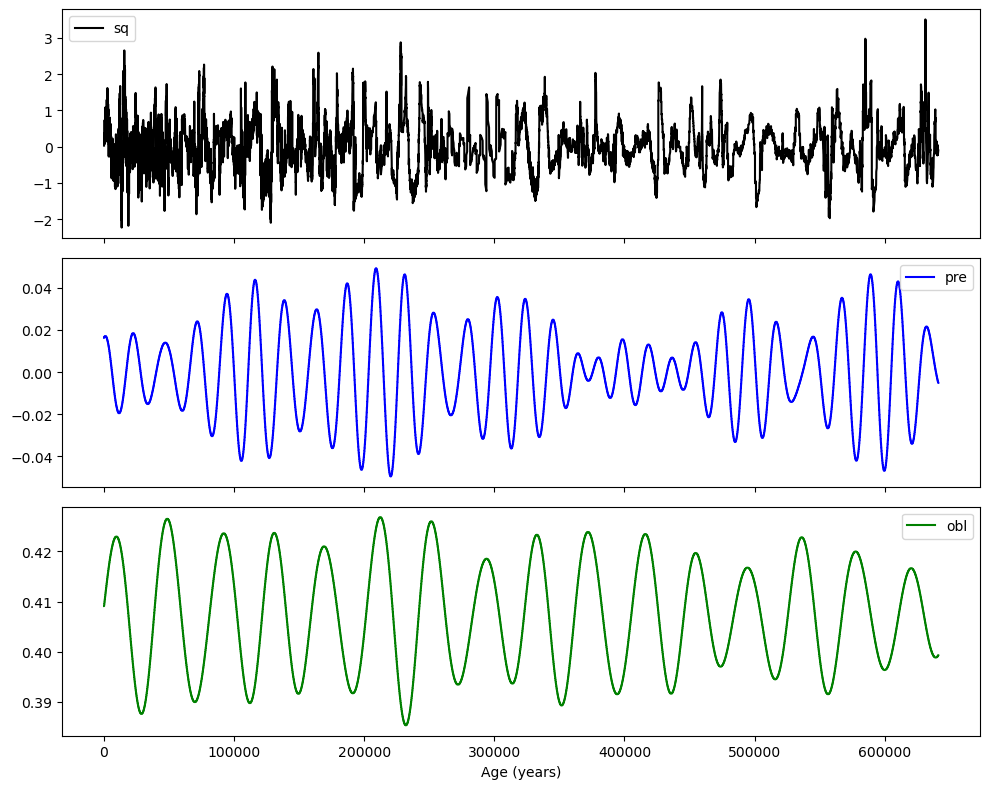

          age   d18O_hp
0           0  0.027887
1          20  0.109018
2          40  0.190153
3          60  0.361292
4          80  0.362436
...       ...       ...
32058  641160 -0.133319
32059  641180 -0.126093
32060  641200 -0.118917
32061  641220 -0.111791
32062  641240 -0.104716

[32063 rows x 2 columns]
          age       pre
0           0  0.016280
1          20  0.016280
2          40  0.016280
3          60  0.016431
4          80  0.016431
...       ...       ...
32058  641160 -0.005173
32059  641180 -0.005173
32060  641200 -0.005173
32061  641220 -0.005173
32062  641240 -0.005173

[32063 rows x 2 columns]
Length of df_sq_rs: 32063


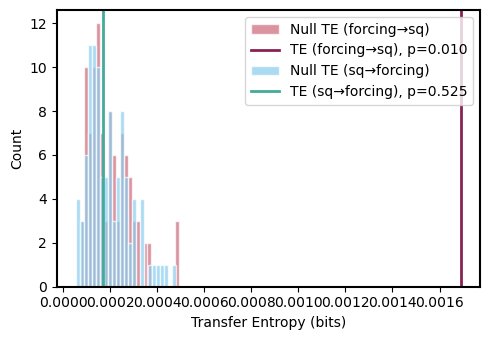

(True, <Figure size 500x350 with 1 Axes>)

In [3]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

df_hp = remove_orbital_component(new_df, col_name='d18O')

df_sq, df_pre, df_obl = sa.interpolate_data_forcing(df_hp, 20, if_plot=True)
print(df_sq)
print(df_pre)
# print the length of df_sq_rs and df_pre_rs
print('Length of df_sq_rs:', len(df_sq))


from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)


pre = df_pre['pre'].values      # source (precession)
sq = df_sq['d18O_hp'].values    # target (residual)


result =sa.transfer_entropy_surrogate_test(pre,sq,forcing_bins=4)
result

Replaced 12826 values <-0.848 or >0.869 with N(0,0.100²) noise


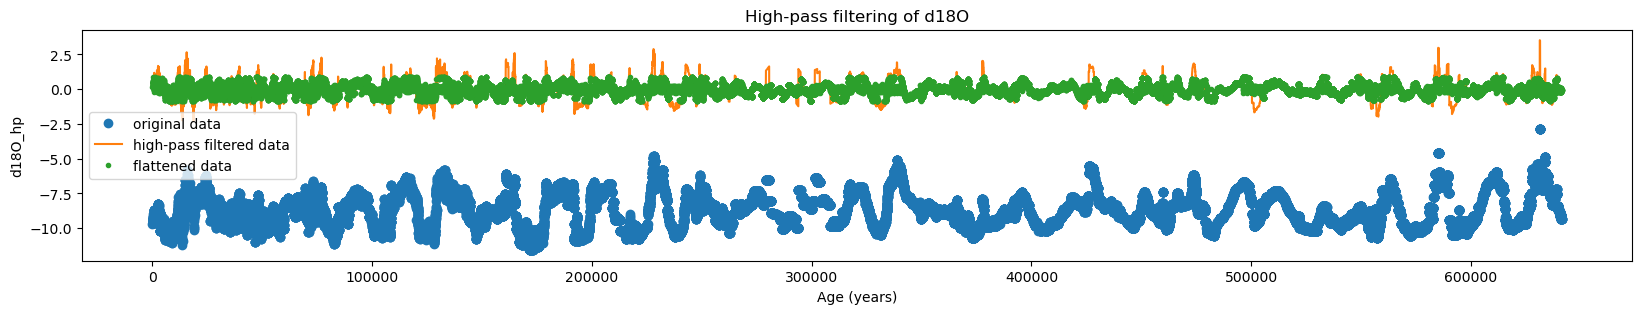

In [24]:

df_hp = remove_orbital_component(new_df, col_name='d18O')
df_flattened, _, _ = threshold_to_noise(df_hp, col=col + '_hp', lower_pct=10, upper_pct=90, noise_mean=0, sigma=0.1)
# plot new_df and df_hp
plt.figure(figsize=(20, 3))
plt.plot(new_df['age'], new_df[col], 'o', label='original data')
plt.plot(df_hp['age'], df_hp[col + '_hp'], '-', label='high-pass filtered data')
plt.plot(df_flattened['age'], df_flattened[col + '_hp'], '.', label='flattened data')
plt.xlabel('Age (years)')
plt.ylabel(col + '_hp')
plt.title('High-pass filtering of ' + col)
plt.legend()
plt.show()

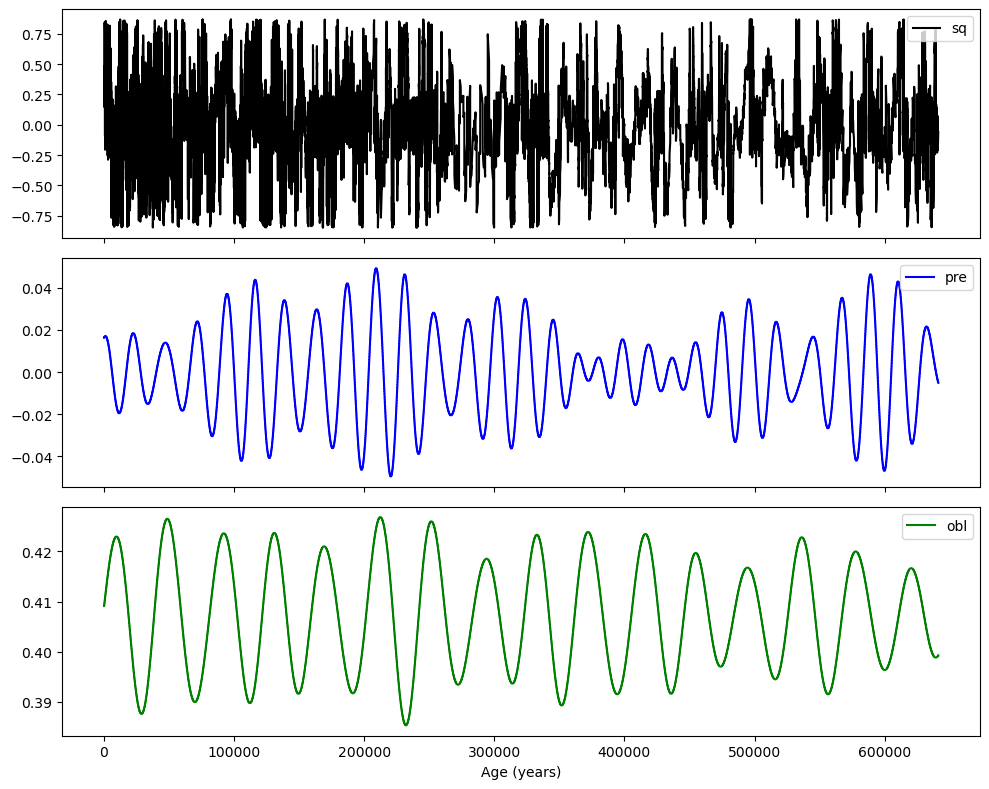

          age   d18O_hp
0           0  0.150830
1          10  0.231124
2          20  0.231418
3          30  0.311714
4          40  0.312011
...       ...       ...
64121  641210 -0.077534
64122  641220 -0.073614
64123  641230 -0.069705
64124  641240 -0.065807
64125  641250 -0.061921

[64126 rows x 2 columns]
          age       pre
0           0  0.016280
1          10  0.016280
2          20  0.016280
3          30  0.016280
4          40  0.016280
...       ...       ...
64121  641210 -0.005173
64122  641220 -0.005173
64123  641230 -0.005173
64124  641240 -0.005173
64125  641250 -0.005173

[64126 rows x 2 columns]
Length of df_sq_rs: 64126


In [25]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

df_sq, df_pre, df_obl = sa.interpolate_data_forcing(df_flattened, 10, if_plot=True)
print(df_sq)
print(df_pre)
# print the length of df_sq_rs and df_pre_rs
print('Length of df_sq_rs:', len(df_sq))

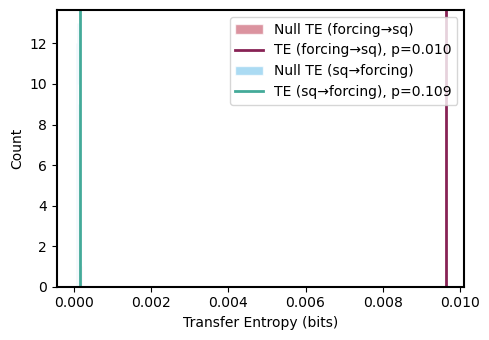

(True, <Figure size 500x350 with 1 Axes>)

In [26]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)


pre = df_pre['pre'].values      # source (precession)
sq = df_sq['d18O_hp'].values    # target (residual)


result =sa.transfer_entropy_surrogate_test(pre,sq,forcing_bins=4)
result